### 1) Implement changes to Fe/H calculation method:
####    a) change selection box to start at 21.9
### 2) Try new method: calculation mean color of entire SMASH field and then calculate metallicity
### 3) Plot all methods' Fe/H values with error bars versus radius from LMC/SMC centers
### 4) Plot color-color plots of all SMASH fields of interest with calibration overlaid

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import fitsio
from fitsio import FITS,FITSHDR
from astropy import units as u
from astropy.coordinates import SkyCoord
from scipy import stats
from astropy.table import Table, Column
from astropy.io import ascii
from scipy.interpolate import griddata
from sklearn import neighbors
import matplotlib.lines as mlines

In [2]:
data = '/Users/amyel/research/SMASH_project/datafiles/SMASH_SDSS_LAMOST_crossmatch.fits'
fx = fitsio.FITS(data)
objs = fx[1].read()

In [3]:
#deredden calibration sample
u_cal = (objs["U"]-(4.239*objs["EBV"]))
g_cal = (objs["G"]-(3.303*objs["EBV"]))
i_cal = (objs["I"]-(1.263*objs["EBV"]))
r_cal = (objs["R"]-(2.285*objs["EBV"]))
feh_cal = objs["FEH"]
u_g_cal = u_cal - g_cal
g_r_cal = g_cal - r_cal

In [4]:
#points array for grid interpolation
###creates 2770 vs 2 array of pairs of [u_g_cal,g_r_cal]
points = np.reshape((np.ravel([u_g_cal,g_r_cal],order='F')),(len(u_g_cal),2))

#x,y grid array for grid interpolation
###creates grid from [u_g_cal.min(),u_g_cal.max()]x[g_r_cal.min(),g_r_cal.max()] with 1000 increments
x_grid,y_grid = np.mgrid[(u_g_cal.min()):(u_g_cal.max()):1000j,(g_r_cal.min()):(g_r_cal.max()):1000j]

In [5]:
#use grid interpolation. points are data point coordinates
###feh_cal is the array of data values
###(x_grid,y_grid) are points at which to interpolate data
###method is method of interpolation:
#####nearest: return the value at the data point closest to the point of interpolation.
#####linear: tessellate the input point set to n-dimensional simplices, and interpolate linearly on each simplex
#####cubic: return the value determined from a cubic spline.
#create dictionary with keys nearest, linear, cubic that correspond to arrays of interpolated data
z_grid = {}
for i, method in enumerate(('nearest','linear','cubic')):
    key = method
    z_grid[key] = griddata(points,feh_cal,(x_grid,y_grid),method=method)
  
    

In [6]:
#use binned statistic 2d for original calibration sample
#creat dictionary with keys for original(z3), nearest(z0), linear(z1), and cubic(z2)
ret = {}
xedge = {}
yedge = {}
bin = {}

#original calibration
ret['original'],xedge['original'],yedge['original'],bin['original'] = stats.binned_statistic_2d((u_g_cal),(g_r_cal),feh_cal,'median',50)

#nearest interpolation
ret['nearest'],xedge['nearest'],yedge['nearest'],bin['nearest'] = stats.binned_statistic_2d(x_grid[:,0],y_grid[0,:],z_grid['nearest'][:,0],'median',50)

#linear interpolation
ret['linear'],xedge['linear'],yedge['linear'],bin['linear'] = stats.binned_statistic_2d(x_grid[np.isfinite(z_grid['linear'])],y_grid[np.isfinite(z_grid['linear'])],z_grid['linear'][np.isfinite(z_grid['linear'])],'median',50)

#cubic inerpolation
ret['cubic'],xedge['cubic'],yedge['cubic'],bin['cubic'] = stats.binned_statistic_2d(x_grid[np.isfinite(z_grid['cubic'])],y_grid[np.isfinite(z_grid['cubic'])],z_grid['cubic'][np.isfinite(z_grid['cubic'])],'median',50)


/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


In [7]:
fields = [1, 2, 3, 4, 5, 7, 8, 9, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 40, 42, 44, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 66, 68, 149, 150, 156, 176, 177, 178, 246]


In [8]:
#dictionaries & lists to be used in metallicity function
mean_metallicity = {}
median_metallicity = {}
std = {}
error = {}
color_mean = {}
color_median = {}
initial_stars = []
cut_stars = []

for i, method in enumerate(('original','nearest','linear','cubic','nearest_regressor','ivezic','uerr','gerr','rerr')):
    mean_metallicity[method] = []
    median_metallicity[method] = []
    color_mean[method] = []
    color_median[method] = []
    std[method] = []
    error[method] = []

In [9]:
def ivezic_equation(x,y):
    return ((-4.37) + (-8.56)*x + (15.5)*y + (-39.0)*x*y + (23.5)*x**2 + (20.5)*y**2 + (12.1)*(x**2)*y + (7.33)*x*(y**2) + (-10.1)*(x**3) + (-21.4)*y**3)


In [10]:
#function to calculate metallicity in SMASH fields of interest
###calculates metallicity using information from binned_statistic_2d 
###reads out metallicity using yumi's method
###output is four different metallicity values: original calibration, nearest interpolation, linear interpolation, cubic interpolation
def metallicity(filename):
    
    #read fits file
    fx = fitsio.FITS(filename)
    objs_new = fx[1].read()
    
    #extract field number from filename string
    newstr = ''.join((ch if ch in '0123456789' else ' ') for ch in filename)
    field_number = [int(i) for i in newstr.split()]
    
    #initial number of stars in each field
    print("number of initial stars in field "+str(field_number[0])+": "+str(len(objs_new)))
    initial_stars.append(objs_new)
    
    #deredden the colors from input file
    u = (objs_new["U"]-(4.239*objs_new["EBV"]))
    g = (objs_new["G"]-(3.303*objs_new["EBV"]))
    i = (objs_new["I"]-(1.263*objs_new["EBV"]))
    r = (objs_new["R"]-(2.285*objs_new["EBV"]))

    #make cuts
    selected = np.where(((g-i)>=0.11)&((g-i)<=0.44)&(g>=21.9)&(g<=22.8)&(u<=30)&(r<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))
    u = u[selected]
    g = g[selected]
    i = i[selected]
    r = r[selected]
    u_g = u-g
    g_r = g-r
    uerr = objs_new['UERR'][selected]
    gerr = objs_new['GERR'][selected]
    rerr = objs_new['RERR'][selected]
    
    #weights to compute weighted average
    wt_uerr = 1/(uerr**2)
    wt_gerr = 1/(gerr**2)
    wt_rerr = 1/(rerr**2)
    wts = [wt_uerr,wt_gerr,wt_rerr]
    
    #number of stars after cuts
    print("number of stars after cuts in field "+str(field_number[0])+": "+str(len(u)))
    cut_stars.append(len(u))
    stars = len(u)
    
    #original metallicity values from binned_statistic_sd from original calibration sample 
    ind, = np.where(((u_g)>=xedge['original'].min())&((u_g)<=xedge['original'].max())&((g_r)>=yedge['original'].min())&((g_r)<=yedge['original'].max()))
    ix = np.searchsorted(xedge['original'],(u_g)[ind])
    ix = ix - 1
    iy = np.searchsorted(yedge['original'],(g_r)[ind])
    iy = iy - 1
    feh = ret['original'][ix,iy]
    N = np.count_nonzero(~np.isnan(feh))
    mean_metallicity['original'].append(np.nanmean(feh))
    print("mean metallicity for original method:",(np.nanmean(feh)))
    median_metallicity['original'].append(np.nanmedian(feh))
    std['original'].append(np.nanstd(feh))
    error['original'].append((np.nanstd(feh))/np.sqrt(N))

    #weighted averages computed using error in the u, g, and r bands
    for i, method in enumerate(('uerr','gerr','rerr')):
        wt = 1/(wts[i]**2)
        wt = wt[ind]
        selected = np.where((np.isnan(feh)!=True))
        feh = feh[selected]
        N = np.count_nonzero(~np.isnan(feh))
        wt = wt[selected]
        mean_metallicity[method].append((np.sum(wt*feh))/(np.sum(wt)))
        std[method].append(np.nanstd(feh))
        error[method].append((np.nanstd(feh))/np.sqrt(N))
        print("weighted mean using "+str(method)+': ',((np.sum(wt*feh))/(np.sum(wt))))    
    
    #read out metallicity values from binned_statistic_2d from original calibration sample, and then the different interpolation methods
    for i, method in enumerate(('nearest','linear','cubic')):
        ind, = np.where(((u_g)>=xedge[method].min())&((u_g)<=xedge[method].max())&((g_r)>=yedge[method].min())&((g_r)<=yedge[method].max()))
        ix = np.searchsorted(xedge[method],(u_g)[ind])
        ix = ix - 1
        iy = np.searchsorted(yedge[method],(g_r)[ind])
        iy = iy - 1
        feh = ret[method][ix,iy]
        N = np.count_nonzero(~np.isnan(feh))
        mean_metallicity[method].append(np.nanmean(feh))
        median_metallicity[method].append(np.nanmedian(feh))
        print("mean metallicity for "+method+" method:",(np.nanmean(feh)))
        std[method].append(np.nanstd(feh))
        error[method].append((np.nanstd(feh))/np.sqrt(N))
        
    #compute mean/median colors inside field, and then metallicity
    for i, method in enumerate(('original','nearest','linear','cubic')):
        ind, = np.where(((u_g)>=xedge[method].min())&((u_g)<=xedge[method].max())&((g_r)>=yedge[method].min())&((g_r)<=yedge[method].max()))
        mean_u_g = np.nanmean(u_g[ind])
        mean_g_r = np.nanmean(g_r[ind])
        ix = np.searchsorted(xedge[method],mean_u_g)
        ix = ix - 1
        iy = np.searchsorted(yedge[method],mean_g_r)
        iy = iy - 1
        feh = ret[method][ix,iy]
        color_mean[method].append(np.nanmean(feh))
        print("color mean Fe/H for "+method+" method:",(np.nanmean(feh)))
    
    for i, method in enumerate(('original','nearest','linear','cubic')):
        ind, = np.where(((u_g)>=xedge[method].min())&((u_g)<=xedge[method].max())&((g_r)>=yedge[method].min())&((g_r)<=yedge[method].max()))
        median_u_g = np.nanmedian(u_g[ind])
        median_g_r = np.nanmedian(g_r[ind])
        ix = np.searchsorted(xedge[method],median_u_g)
        ix = ix - 1
        iy = np.searchsorted(yedge[method],median_g_r)
        iy = iy - 1
        feh = ret[method][ix,iy]
        color_median[method].append(np.nanmedian(feh))
        print("color median Fe/H for "+method+" method:",(np.nanmedian(feh)))
        
    #use machine learning algorithm Nearest Neighbors
    ###The target is predicted by local interpolation of the targets associated of the nearest neighbors in the training set.
    sample = np.reshape(np.ravel([u_g,g_r],order='F'),(len(u_g),2))   
    knn = neighbors.KNeighborsRegressor(5,weights='uniform')
    feh = knn.fit(points,feh_cal).predict(sample)
    mean_metallicity['nearest_regressor'].append(np.nanmean(feh))
    median_metallicity['nearest_regressor'].append(np.nanmedian(feh))
    print("mean metallicity for nearest neighbor regression method:",(np.nanmean(feh)))
    std['nearest_regressor'].append(np.nanstd(feh))
    error['nearest_regressor'].append((np.nanstd(feh))/np.sqrt(stars))
    
    #use equation (4) from Ivezic et al. 2008 to estimate metallicity
    ### x=(u-g) for (g-r)<=0.4; x=(u-g)-2(g-r)+0.8 for (g-r)>0.4
    ### y=(g-r)
    feh = []
    x = u_g -(2*g_r) + 0.8
    index = np.arange(0,len(u_g))
    
    for i in index:
        feh.append([ivezic_equation(u_g[i],g_r[i]) if g_r[i] <= 0.4 else ivezic_equation(x[i],g_r[i])])
    #feh.append(ivezic_equation(u_g[i],g_r[i]))
    
    N = np.count_nonzero(~np.isnan(feh))
    mean_metallicity['ivezic'].append(np.nanmean(feh))
    median_metallicity['ivezic'].append(np.nanmedian(feh))
    std['ivezic'].append(np.nanstd(feh))
    error['ivezic'].append((np.nanstd(feh))/np.sqrt(N))
    print('mean metallicity for ivezic equation method: ',(np.nanmean(feh)))
    
    return 0


In [11]:
if __name__=="__main__":
    for number in fields:
        metallicity('/Users/amyel/research/SMASH_project/datafiles/SMASH_fields/vsix/starsthree/Field{}_allobj_deep_stars.fits.gz'.format(number))

              

number of initial stars in field 1: 46634
number of stars after cuts in field 1: 2849
mean metallicity for original method: -1.1979015532135964
weighted mean using uerr:  -0.9239828911219762
weighted mean using gerr:  -1.4937749602417645
weighted mean using rerr:  -1.1723892892659067
mean metallicity for nearest method: -1.2540112091944768
mean metallicity for linear method: -1.311933441922211
mean metallicity for cubic method: -1.772713209358949
color mean Fe/H for original method: -2.4757843017578125
color mean Fe/H for nearest method: nan
color mean Fe/H for linear method: -2.478885079389925
color mean Fe/H for cubic method: -2.4546183163684
color median Fe/H for original method: nan
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.8211051798948004
color median Fe/H for cubic method: -2.408344682337285
mean metallicity for nearest neighbor regression method: -1.8376961
mean metallicity for ivezic equation method:  3.696527253139739


/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: Mean of empty slice
/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: Mean of empty slice
/Users/amyel/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


number of initial stars in field 2: 61991
number of stars after cuts in field 2: 3435
mean metallicity for original method: -1.3346915160917907
weighted mean using uerr:  -0.9289434889667549
weighted mean using gerr:  -1.3596072004451587
weighted mean using rerr:  -1.3570118782818312
mean metallicity for nearest method: -0.9029419451951981
mean metallicity for linear method: -1.4256130739987312
mean metallicity for cubic method: -1.9129858953913004
color mean Fe/H for original method: -1.9125463962554932
color mean Fe/H for nearest method: nan
color mean Fe/H for linear method: -1.9150277003104201
color mean Fe/H for cubic method: -1.8688022871453192
color median Fe/H for original method: -1.9125463962554932
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -2.1164908161897644
color median Fe/H for cubic method: -2.1424770006042873
mean metallicity for nearest neighbor regression method: -1.5474763
mean metallicity for ivezic equation method:  -1.8805398460

mean metallicity for nearest neighbor regression method: -1.574589
mean metallicity for ivezic equation method:  -1.7634766693265416
number of initial stars in field 14: 776768
number of stars after cuts in field 14: 85748
mean metallicity for original method: -1.418008371895485
weighted mean using uerr:  -1.3576441640145105
weighted mean using gerr:  -1.4229064594390308
weighted mean using rerr:  -1.032790976735841
mean metallicity for nearest method: -0.8545645975872226
mean metallicity for linear method: -1.4947916411362585
mean metallicity for cubic method: -1.6895067489986746
color mean Fe/H for original method: -2.200093984603882
color mean Fe/H for nearest method: nan
color mean Fe/H for linear method: -2.1164908161897644
color mean Fe/H for cubic method: -2.1424770006042873
color median Fe/H for original method: -2.200093984603882
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -2.1164908161897644
color median Fe/H for cubic method: -2.14247700060

number of initial stars in field 26: 52301
number of stars after cuts in field 26: 3767
mean metallicity for original method: -1.31284201884011
weighted mean using uerr:  -1.2649437821191671
weighted mean using gerr:  -1.3312614800853517
weighted mean using rerr:  -1.3240721860505942
mean metallicity for nearest method: -0.9859796489577696
mean metallicity for linear method: -1.3384864596638966
mean metallicity for cubic method: -1.7199255715569752
color mean Fe/H for original method: -1.5431206226348877
color mean Fe/H for nearest method: nan
color mean Fe/H for linear method: -1.5128520483966148
color mean Fe/H for cubic method: -1.5025171636863859
color median Fe/H for original method: -1.5431206226348877
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.5128520483966148
color median Fe/H for cubic method: -1.5025171636863859
mean metallicity for nearest neighbor regression method: -1.4807949
mean metallicity for ivezic equation method:  -1.6401901271

mean metallicity for nearest neighbor regression method: -1.5683641
mean metallicity for ivezic equation method:  -1.6461374301046277
number of initial stars in field 35: 1606580
number of stars after cuts in field 35: 27253
mean metallicity for original method: -1.1714805520256524
weighted mean using uerr:  -0.40851264377847674
weighted mean using gerr:  -1.2436001683791231
weighted mean using rerr:  -1.1317044211466134
mean metallicity for nearest method: -0.9552534205733605
mean metallicity for linear method: -1.165237859296871
mean metallicity for cubic method: -1.3443969235561257
color mean Fe/H for original method: -1.447492003440857
color mean Fe/H for nearest method: nan
color mean Fe/H for linear method: -1.1436360954911318
color mean Fe/H for cubic method: -1.1078426046405707
color median Fe/H for original method: -1.447492003440857
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.1436360954911318
color median Fe/H for cubic method: -1.1078426

number of initial stars in field 50: 1155082


/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in less_equal
/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: Mean of empty slice
/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: Mean of empty slice
/Users/amyel/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


number of stars after cuts in field 50: 223
mean metallicity for original method: -1.132754921913147
weighted mean using uerr:  -1.132754921913147
weighted mean using gerr:  -1.132754921913147
weighted mean using rerr:  -1.132754921913147
mean metallicity for nearest method: nan
mean metallicity for linear method: -1.5511666465983662
mean metallicity for cubic method: -2.523232251219853
color mean Fe/H for original method: nan
color mean Fe/H for nearest method: nan
color mean Fe/H for linear method: nan
color mean Fe/H for cubic method: nan
color median Fe/H for original method: nan
color median Fe/H for nearest method: nan
color median Fe/H for linear method: nan
color median Fe/H for cubic method: nan
mean metallicity for nearest neighbor regression method: -2.1491137
mean metallicity for ivezic equation method:  7.612548223910407
number of initial stars in field 51: 1574573
number of stars after cuts in field 51: 210235
mean metallicity for original method: -1.2986248185849176
weig

number of initial stars in field 59: 88849
number of stars after cuts in field 59: 2148
mean metallicity for original method: -1.4055117055179907
weighted mean using uerr:  -1.168619360528653
weighted mean using gerr:  -1.3961751523541917
weighted mean using rerr:  -0.3102047780627036
mean metallicity for nearest method: -1.096127740542094
mean metallicity for linear method: -1.4387011566556698
mean metallicity for cubic method: -1.8780588524925106
color mean Fe/H for original method: -1.5431206226348877
color mean Fe/H for nearest method: nan
color mean Fe/H for linear method: -1.5128520483966148
color mean Fe/H for cubic method: -1.5025171636863859
color median Fe/H for original method: -1.824390172958374
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.8671866534121997
color median Fe/H for cubic method: -1.9607130425756147
mean metallicity for nearest neighbor regression method: -1.5753149
mean metallicity for ivezic equation method:  -1.71210287984

number of initial stars in field 156: 122018
number of stars after cuts in field 156: 636
mean metallicity for original method: -1.280798856549316
weighted mean using uerr:  -0.7156624127134866
weighted mean using gerr:  -1.247042238164128
weighted mean using rerr:  -1.177993930447206
mean metallicity for nearest method: -1.1350830793380737
mean metallicity for linear method: -1.4034030389056613
mean metallicity for cubic method: -2.071533889687346
color mean Fe/H for original method: -2.5291123390197754
color mean Fe/H for nearest method: nan
color mean Fe/H for linear method: -2.271069247157712
color mean Fe/H for cubic method: -2.311403819188303
color median Fe/H for original method: nan
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -2.120358209774938
color median Fe/H for cubic method: -7.132377762609695
mean metallicity for nearest neighbor regression method: -1.7279106
mean metallicity for ivezic equation method:  -0.25097107259186685
number of in

/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice
/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice
/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars
/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in double_scalars


In [12]:
#ra and dec of each SMASH field and of the centers of LMC/SMC
ra = np.array([2.58282, 4.74128, 5.8295, 6.23604, 11.0282, 11.2637, 12.6438, 15.3642, 17.2959, 19.3929, 20.1116, 21.1397, 22.3556, 32.3014, 33.2987, 33.7735, 38.0154, 40.8729, 48.7252, 55.0714, 62.0399, 62.2076, 71.5224, 72.8794, 73.2326, 73.826, 74.3797, 74.8251, 75.6417, 78.0543, 79.5644, 81.6974, 83.023, 84.5087, 85.416, 87.2541, 87.3605, 89.5211, 96.3535, 96.7494, 98.0372, 98.2317, 107.298, 108.637, 111.26, 111.286, 114.087, 114.673, 118.049, 120.112, 128.154, 130.919, 351.667, 351.815, 115.38663, 10.65102, 22.45883, 25.12044, 101.835])
dec = np.array([-69.7946, -77.0834, -73.9689, -72.3856, -71.6294, -74.8041, -82.474, -70.7182, -75.4505, -78.5112, -71.2591, -72.825, -74.3674, -73.2717, -77.5124, -67.4354, -70.2838, -74.5334, -72.4893, -76.4147, -72.0384, -68.4171, -75.3739, -68.7777, -80.7479, -70.5799, -84.3086, -72.3767, -67.5258, -66.2141, -72.8687, -66.6022, -76.3886, -73.2367, -66.8939, -71.7809, -68.5956, -70.2803, -79.9982, -67.1805, -75.1855, -70.3668, -68.3137, -54.6223, -59.3505, -64.5201, -76.1913, -70.9916, -67.0089, -84.4426, -72.6595, -76.0996, -72.0863, -67.6899, -54.888583, -67.7937, -67.39283, -71.2175, -52.264999])
#associated SkyCoord object
fields = SkyCoord(ra,dec,unit='deg')

#LMC center
ra_lmc = 81.900000
dec_lmc = -69.866667
#SMC center
ra_smc = 13.183333
dec_smc = -72.828333
#associated SkyCoord objects
lmc = SkyCoord(ra_lmc,dec_lmc,unit='deg')
smc = SkyCoord(ra_smc,dec_smc,unit='deg')

#calculate radii from LMC/SMC center
radii_lmc = fields.separation(lmc)
radii_smc = fields.separation(smc)

#convert to degrees
ra

In [15]:
radii_lmc = radii_lmc.degree
radii_smc = radii_smc.degree


In [55]:
print(radii_lmc)


[25.42435918 21.21373378 22.29166393 22.97655363 22.09013874 20.61283069
 18.777821   21.33248223 18.9381918  17.87451074 19.7130009  18.79554027
 17.97757787 15.55482973 15.00553399 17.21874881 14.63726446 13.05829563
 10.86567121 10.01119571  6.79846065  7.12638021  6.29928513  3.36256505
 11.07141497  2.82110298 14.50923241  3.39296238  3.26038287  3.92366097
  3.0928098   3.2653267   6.52977674  3.46886254  3.24152966  2.59765973
  2.31494727  2.6283081  10.73030148  6.04313529  7.14867067  5.55998054
  9.1268542  19.35105419 16.12350527 12.42007655 11.10152017 10.89907687
 13.37566433 16.12203722 14.72448054 15.06590979 26.75408346 29.72475832
 21.06654624 24.34583867 20.92892597 18.26569686 19.85430887]


In [56]:
print(radii_smc)

[ 4.54291267  4.77548986  2.38846904  2.12209395  1.36733023  2.04667004
  9.64625323  2.21729586  2.85133618  5.87911673  2.64786924  2.34750354
  3.00823996  5.56719018  6.89580836  8.75936346  8.18837283  7.88698565
 10.44406215 11.3859477  14.35855176 16.33158031 15.50784084 19.16860416
 14.82914944 18.34260182 15.242577   17.62845536 20.76428382 22.35641166
 18.58043962 23.10280618 17.72352287 19.59476228 23.91678051 21.11482473
 23.23346551 22.64281743 18.7371779  26.68675245 21.49711723 24.7091863
 28.36096059 40.2916125  36.7927058  32.37145465 23.86781329 27.85023781
 31.79417953 19.5056824  28.97237396 26.56388843  6.49188425  8.78187312
 41.78279384  5.10527962  6.26934469  4.01218679 40.54911557]


In [18]:
index = np.argsort(radii_lmc)

<ErrorbarContainer object of 3 artists>

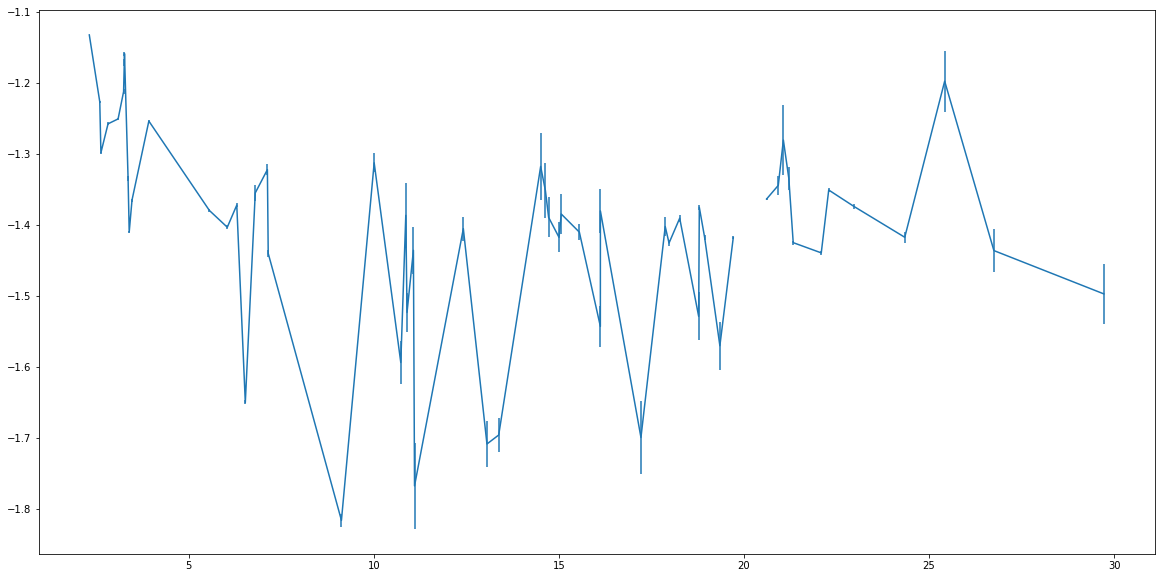

In [28]:
#make plots of Fe/H verses metallicity w/ error bars
#first try original method
fig, ax = plt.subplots(figsize=(20, 10))
ax.errorbar(radii_lmc[index],np.array(mean_metallicity['original'])[index],yerr=np.array(error['original'])[index])


<ErrorbarContainer object of 3 artists>

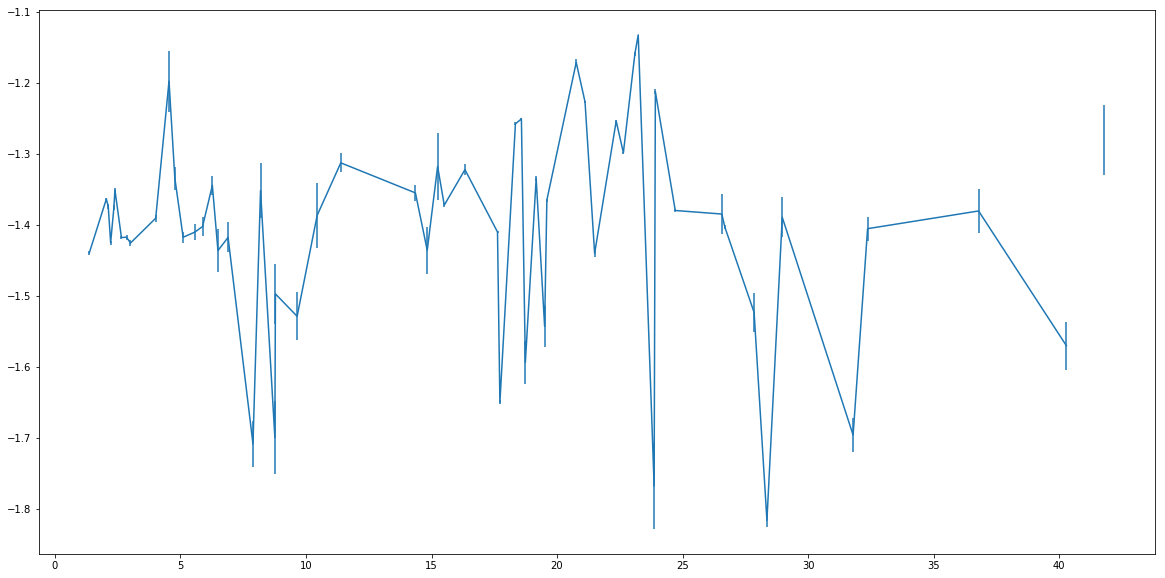

In [30]:
#make plots of Fe/H verses metallicity w/ error bars
#first try original method
index = np.argsort(radii_smc)
fig, ax = plt.subplots(figsize=(20, 10))
ax.errorbar(radii_smc[index],np.array(mean_metallicity['original'])[index],yerr=np.array(error['original'])[index])


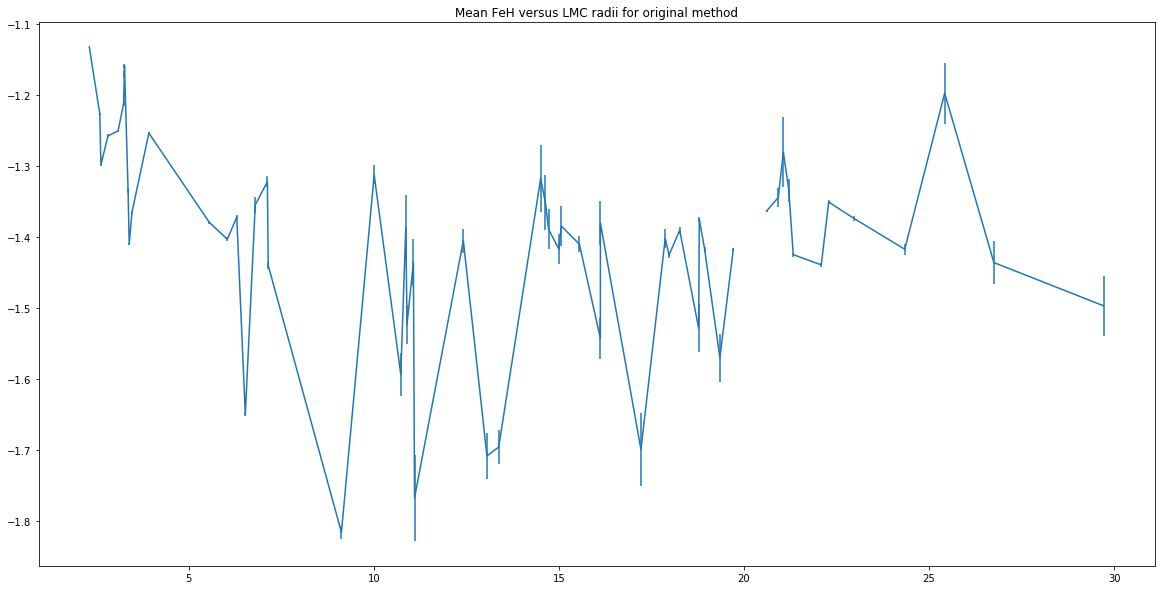

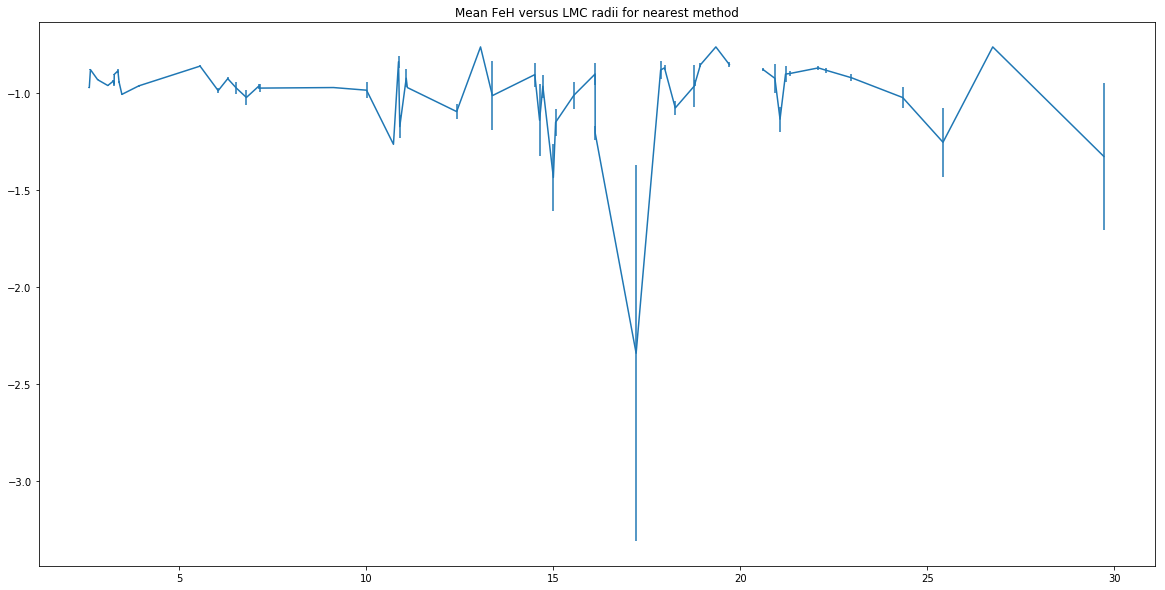

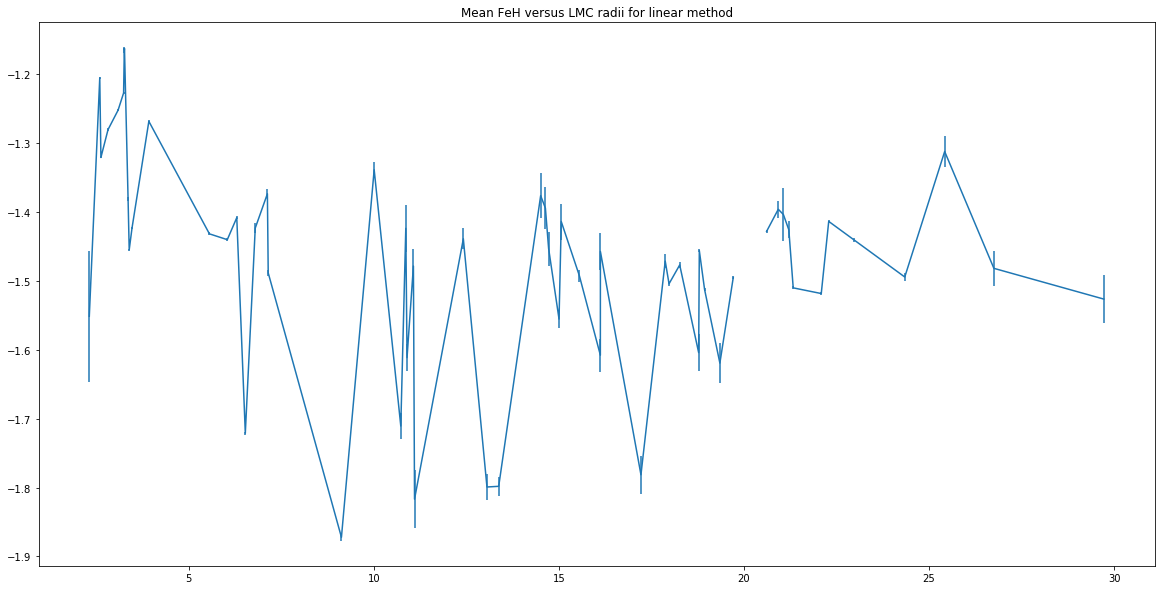

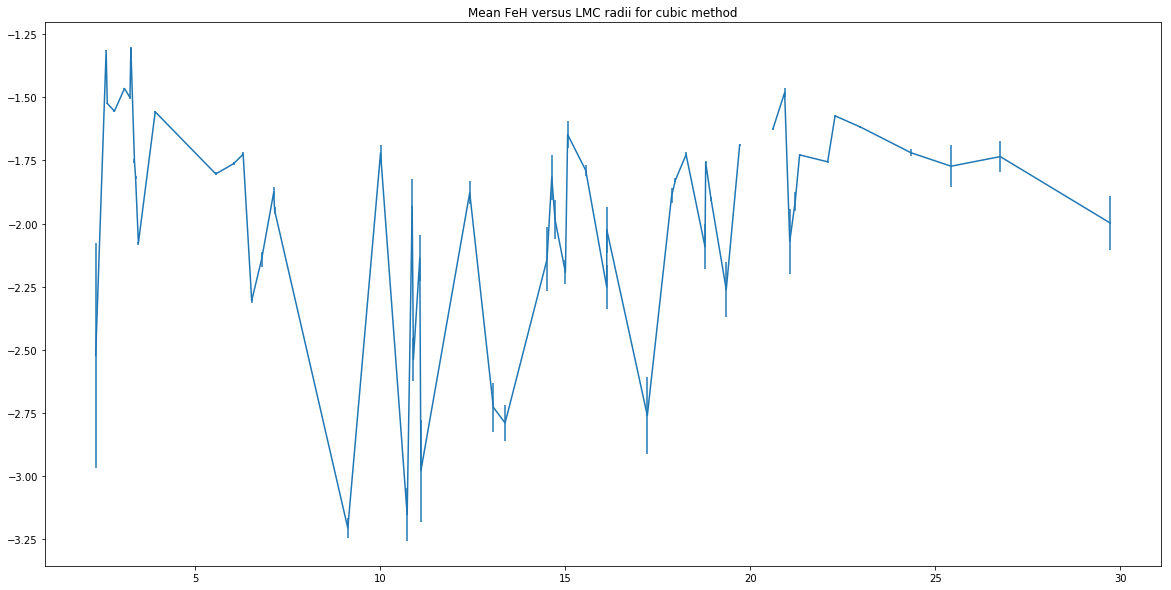

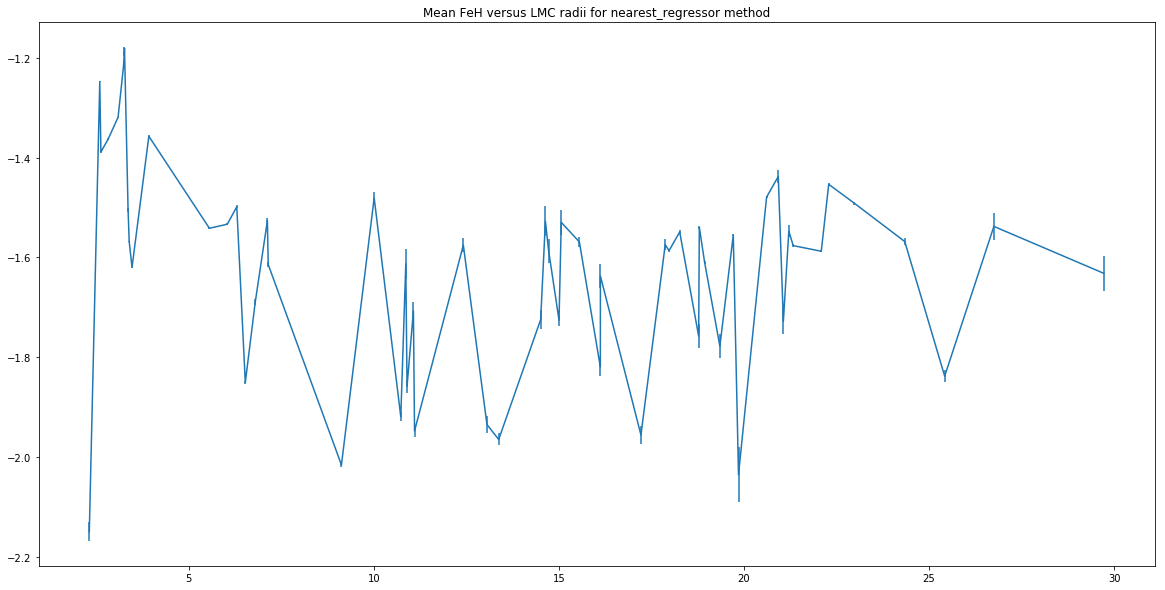

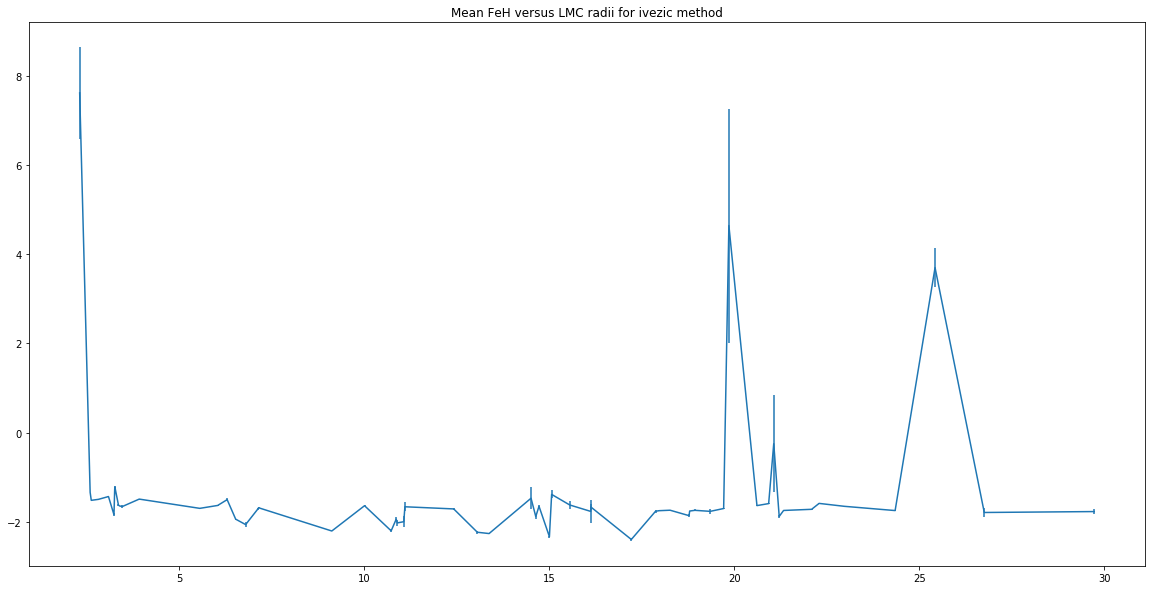

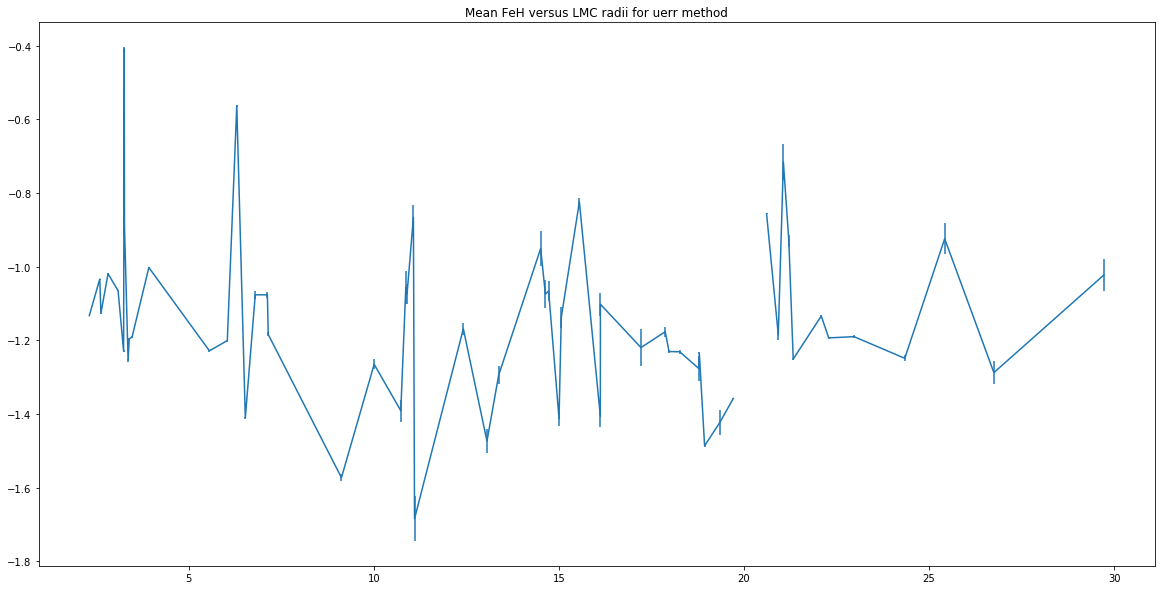

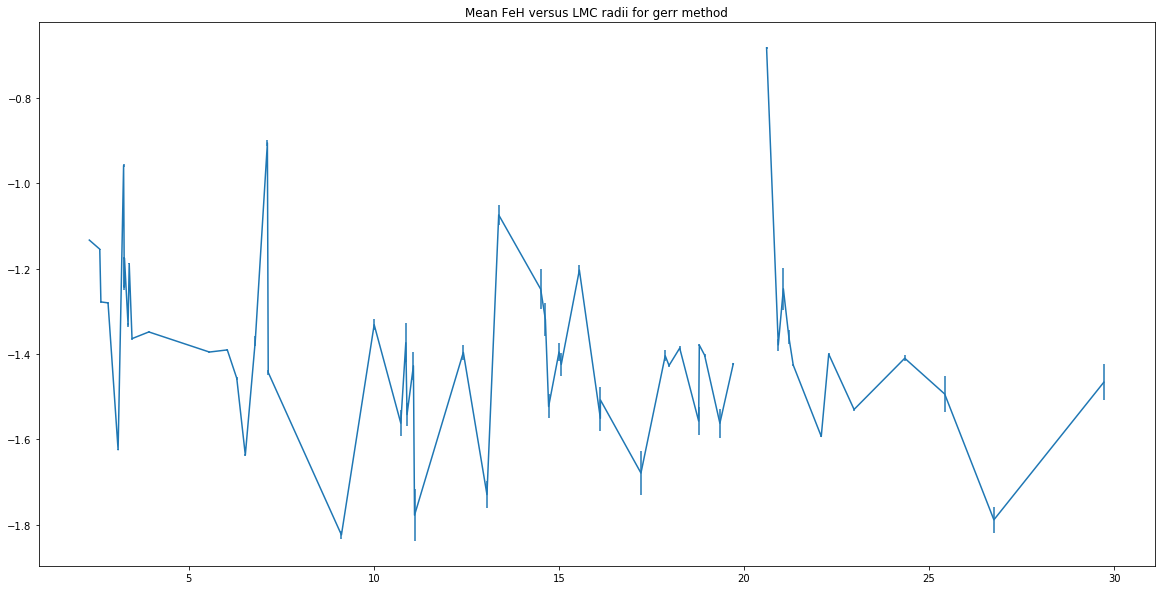

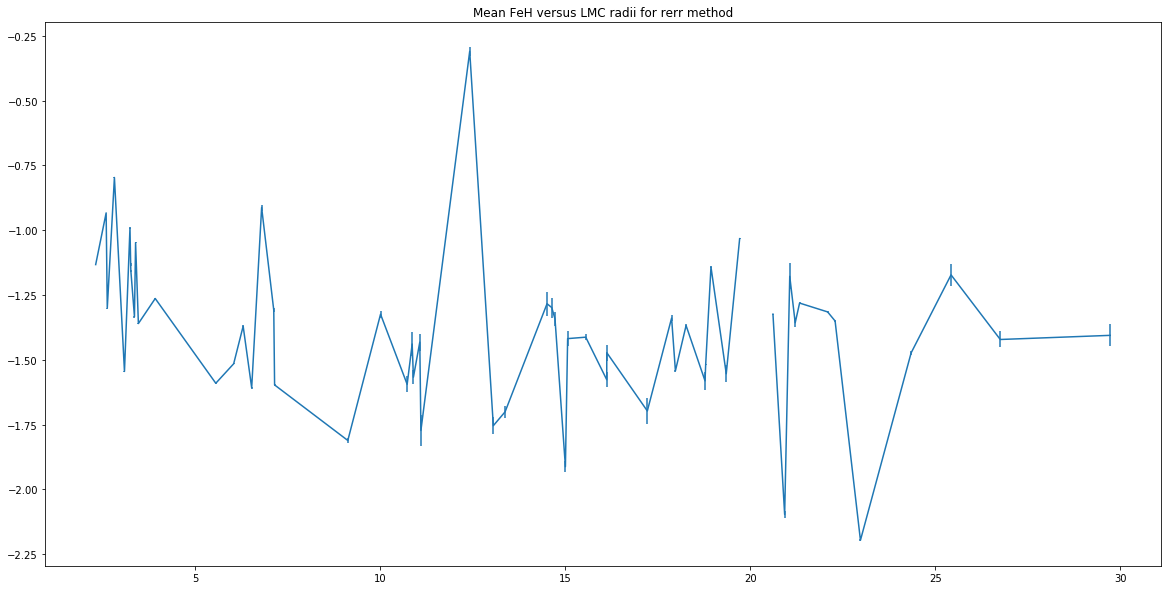

In [33]:
index = np.argsort(radii_lmc)
for i, method in enumerate(('original','nearest','linear','cubic','nearest_regressor','ivezic','uerr','gerr','rerr')):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.errorbar(radii_lmc[index],np.array(mean_metallicity[method])[index],yerr=np.array(error[method])[index])
    ax.set_title('Mean FeH versus LMC radii for '+method+' method')
    

IndexError: index 36 is out of bounds for axis 1 with size 0

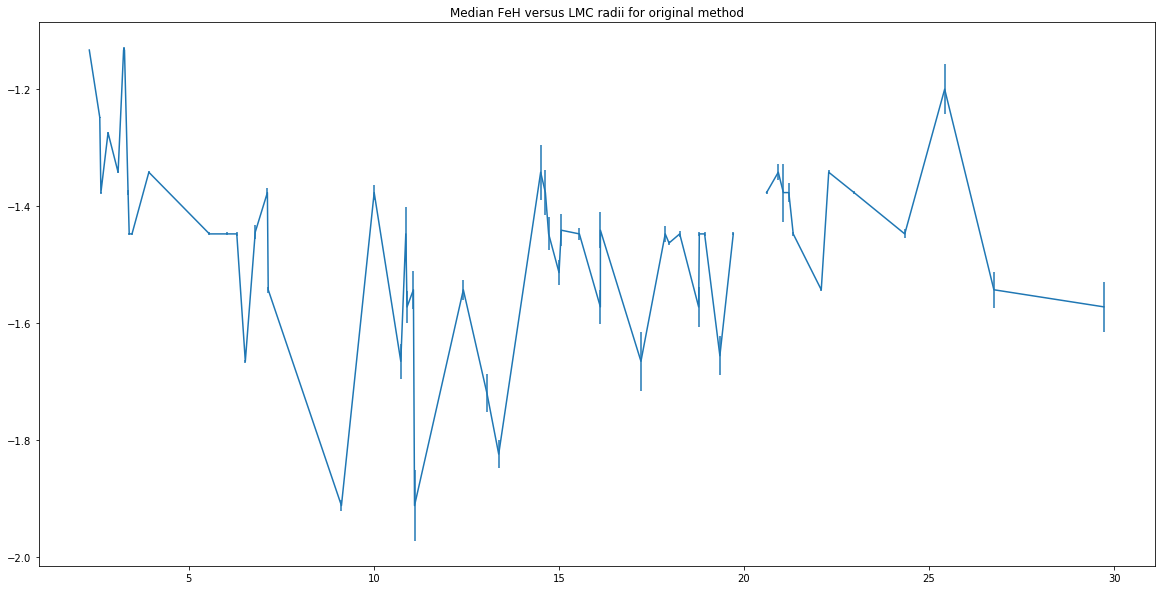

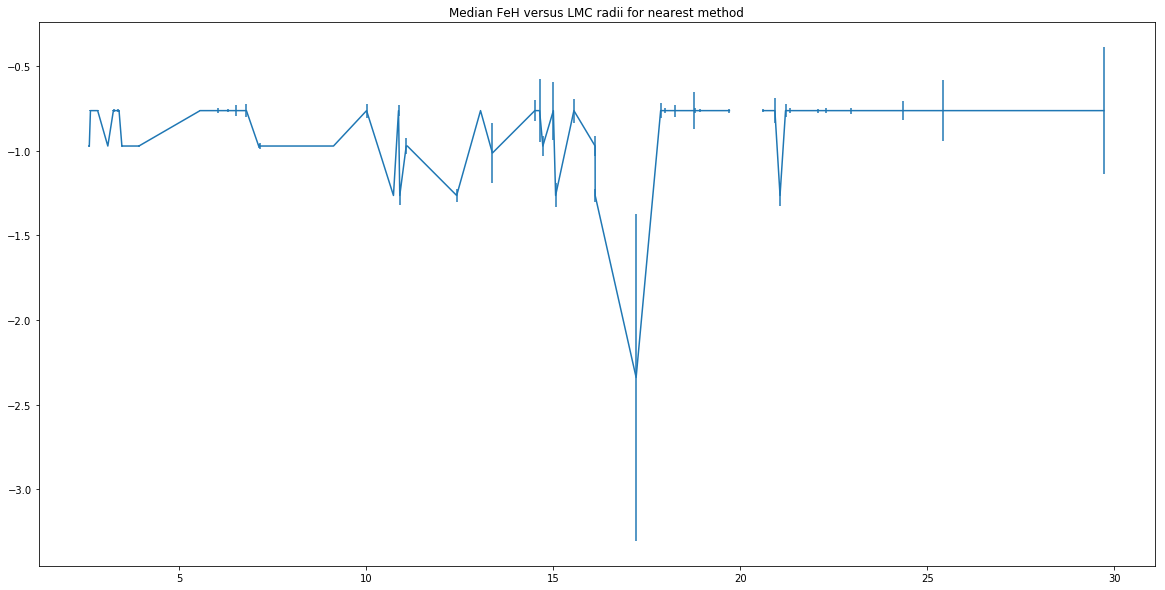

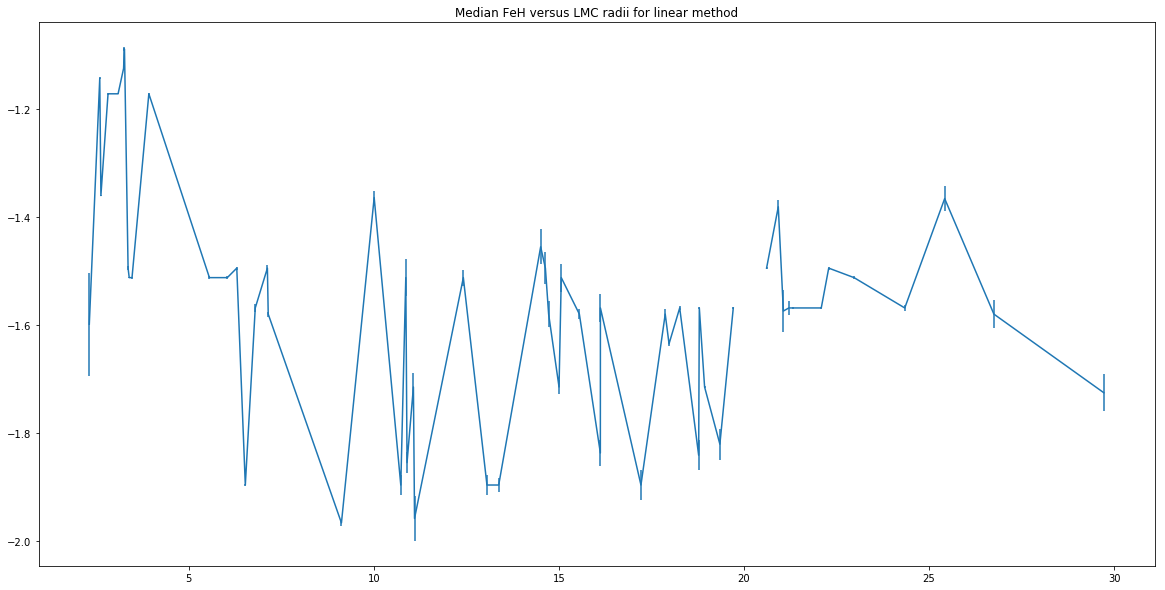

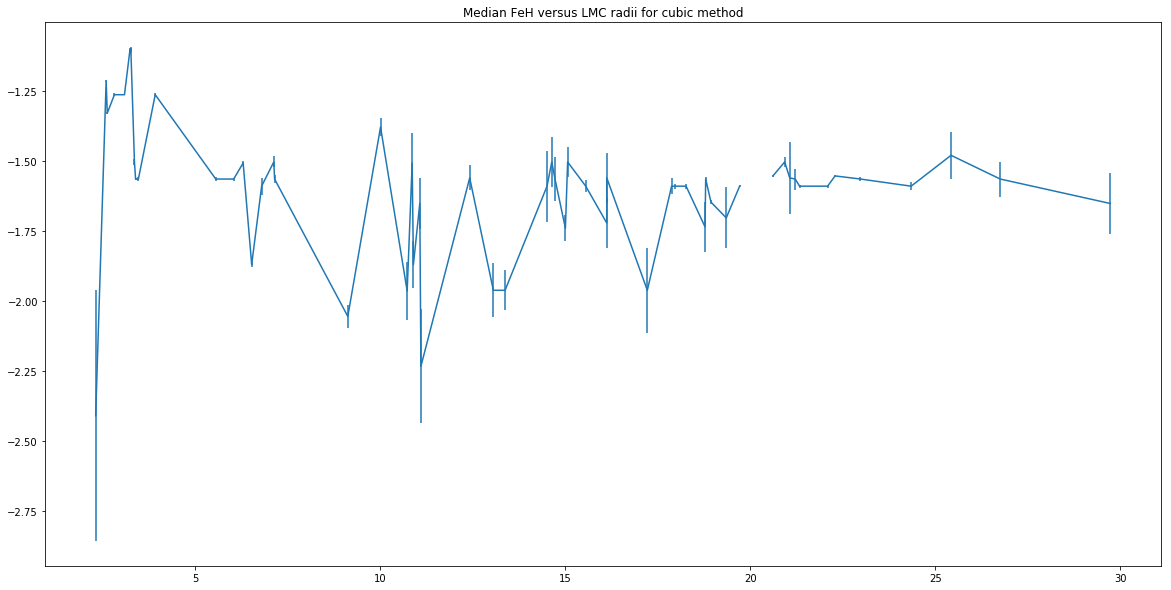

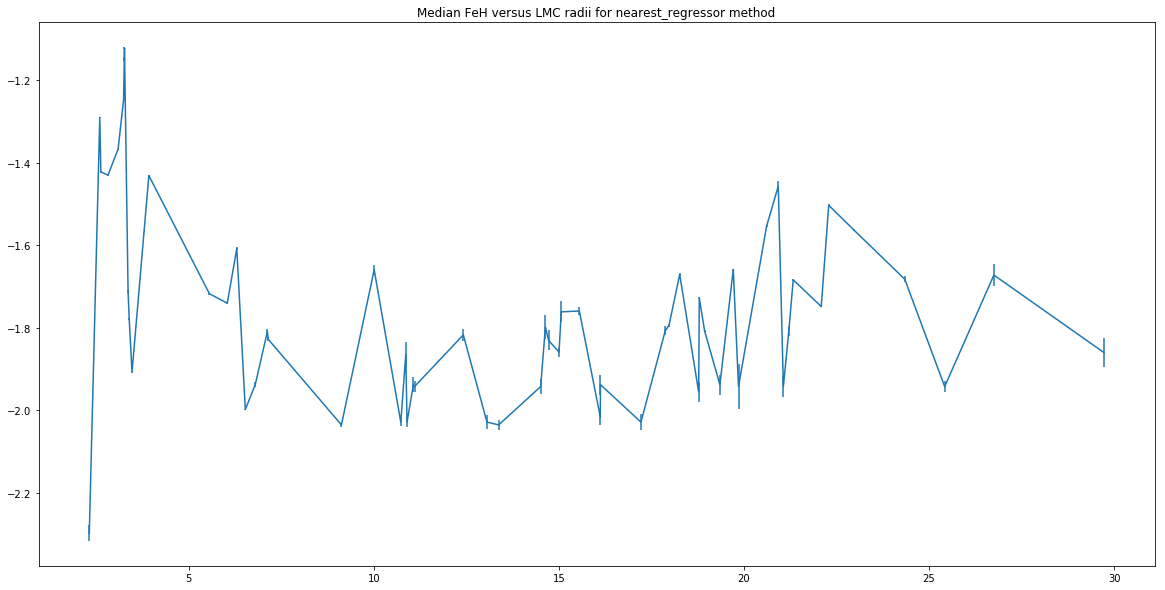

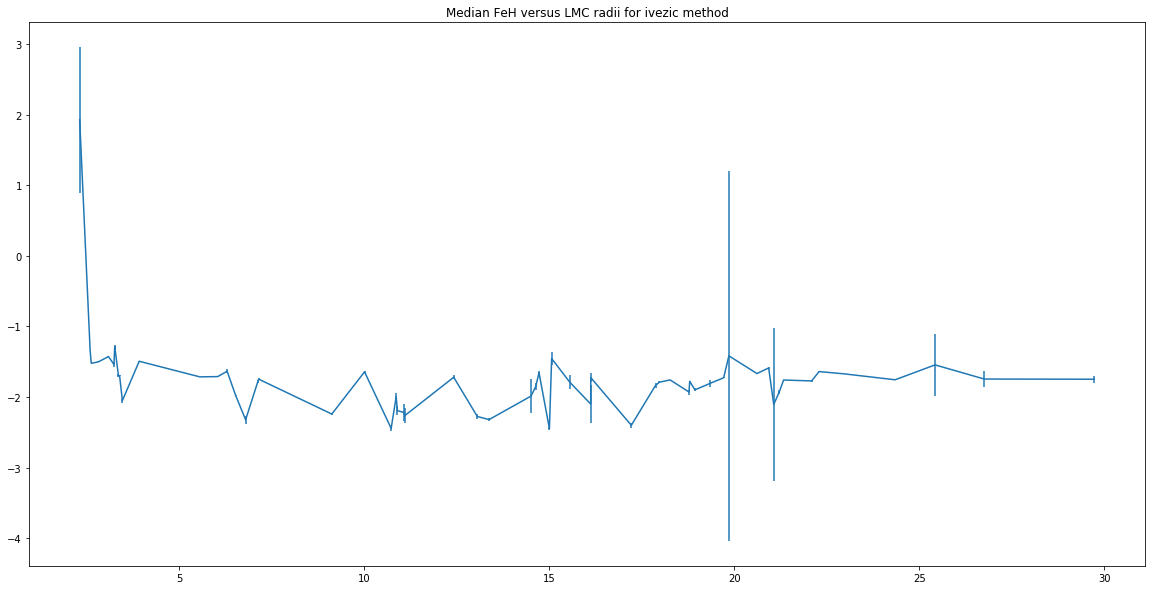

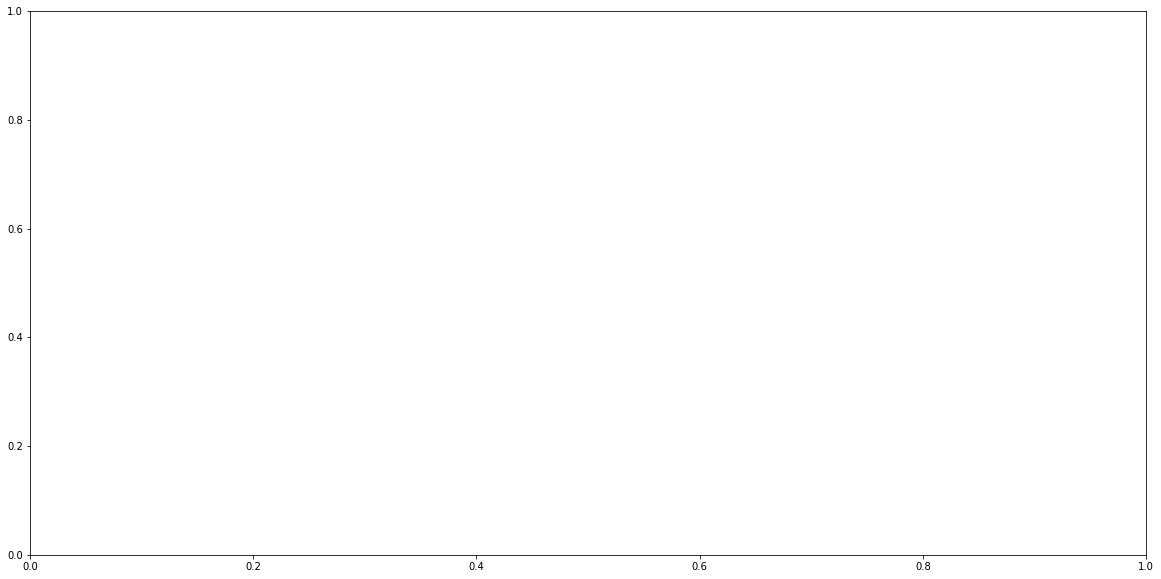

In [34]:
index = np.argsort(radii_lmc)
for i, method in enumerate(('original','nearest','linear','cubic','nearest_regressor','ivezic','uerr','gerr','rerr')):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.errorbar(radii_lmc[index],np.array(median_metallicity[method])[index],yerr=np.array(error[method])[index])
    ax.set_title('Median FeH versus LMC radii for '+method+' method')
    

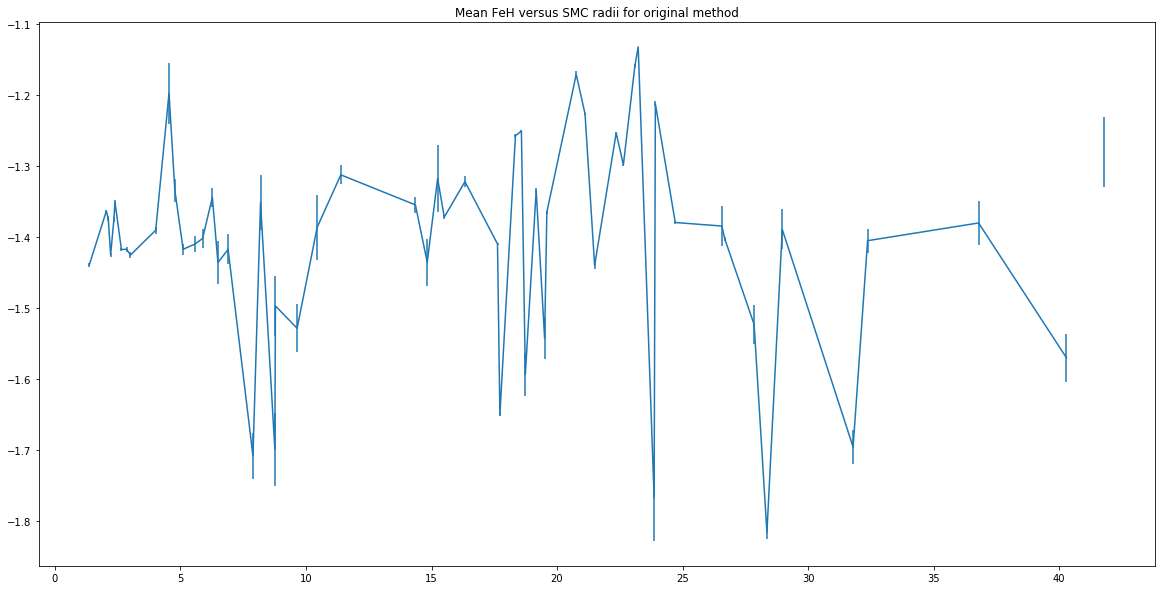

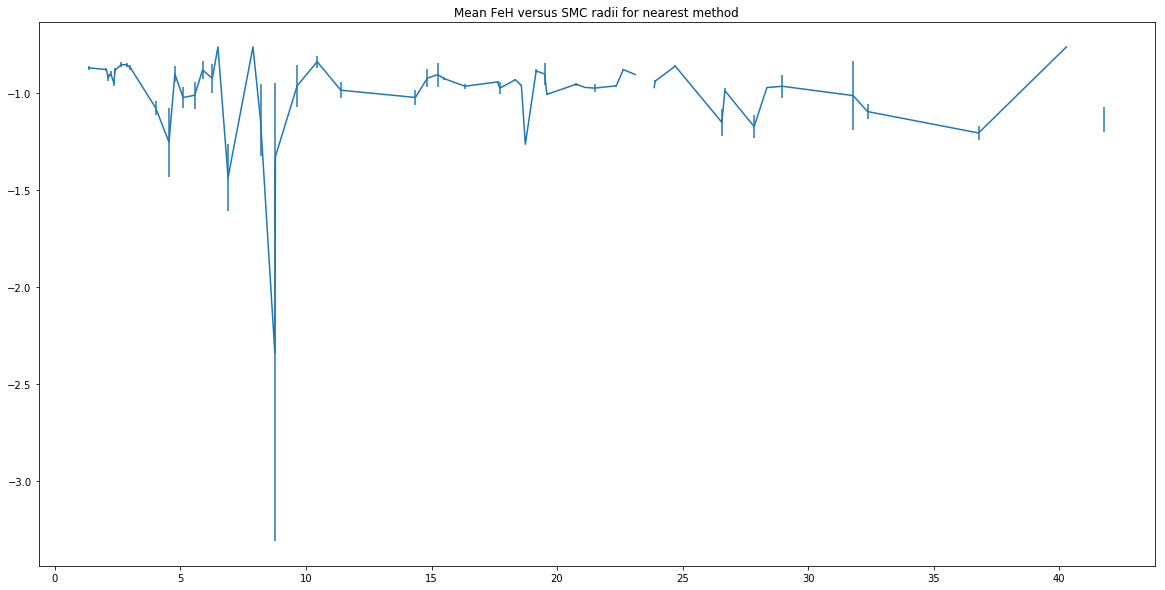

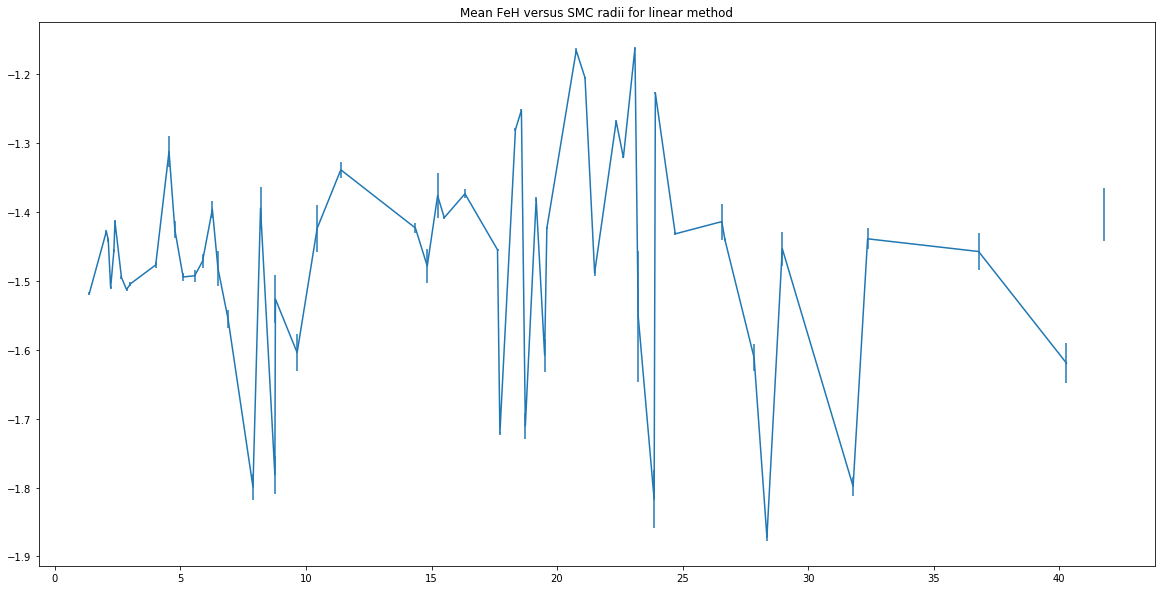

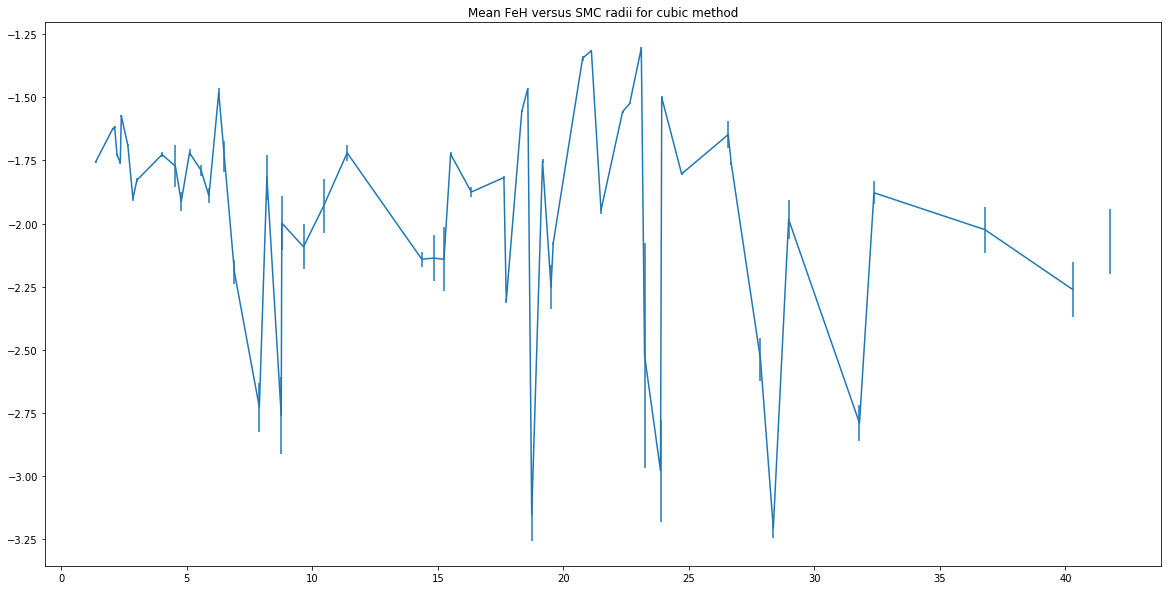

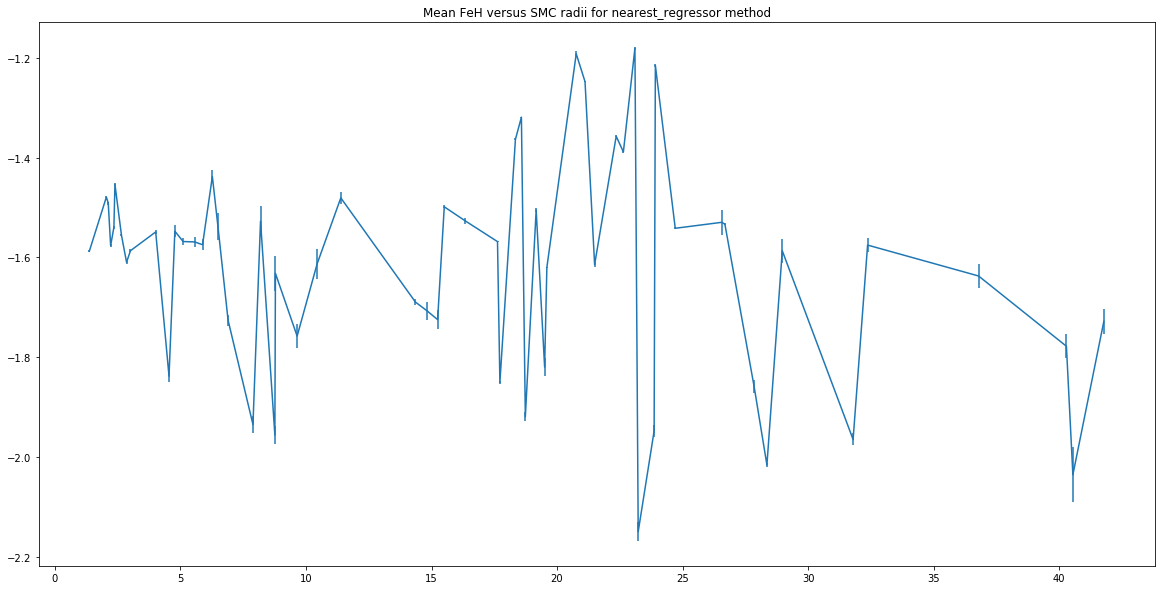

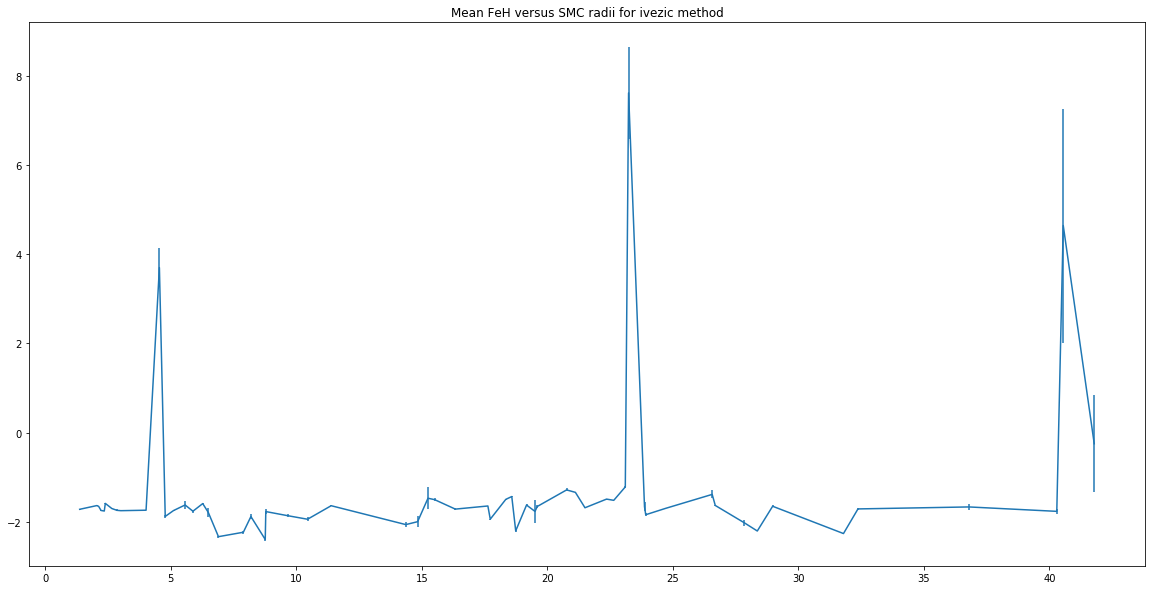

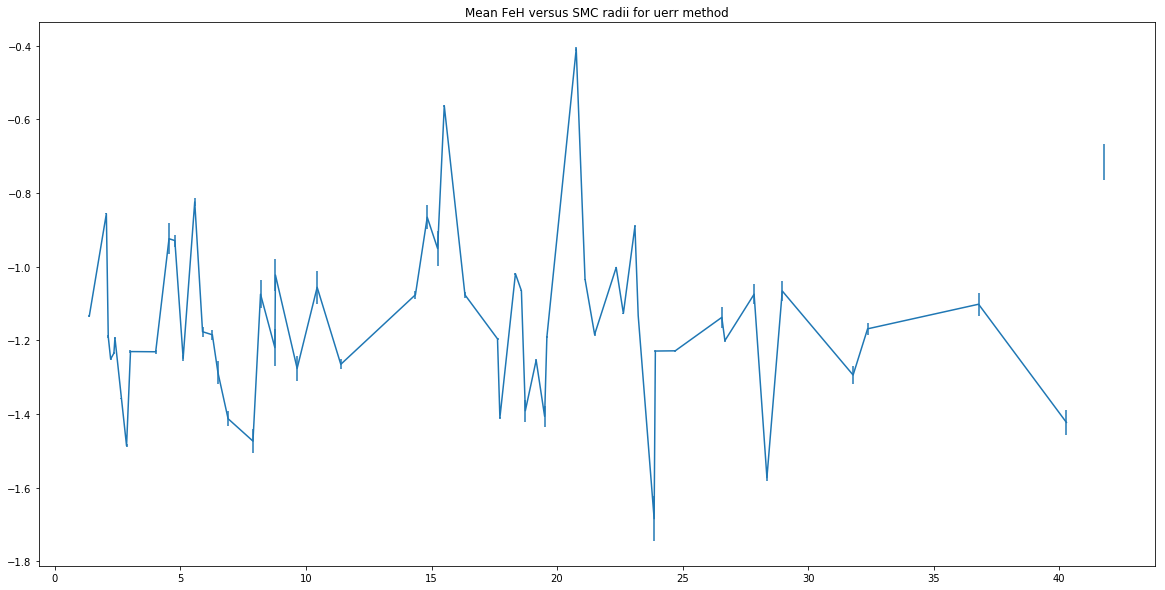

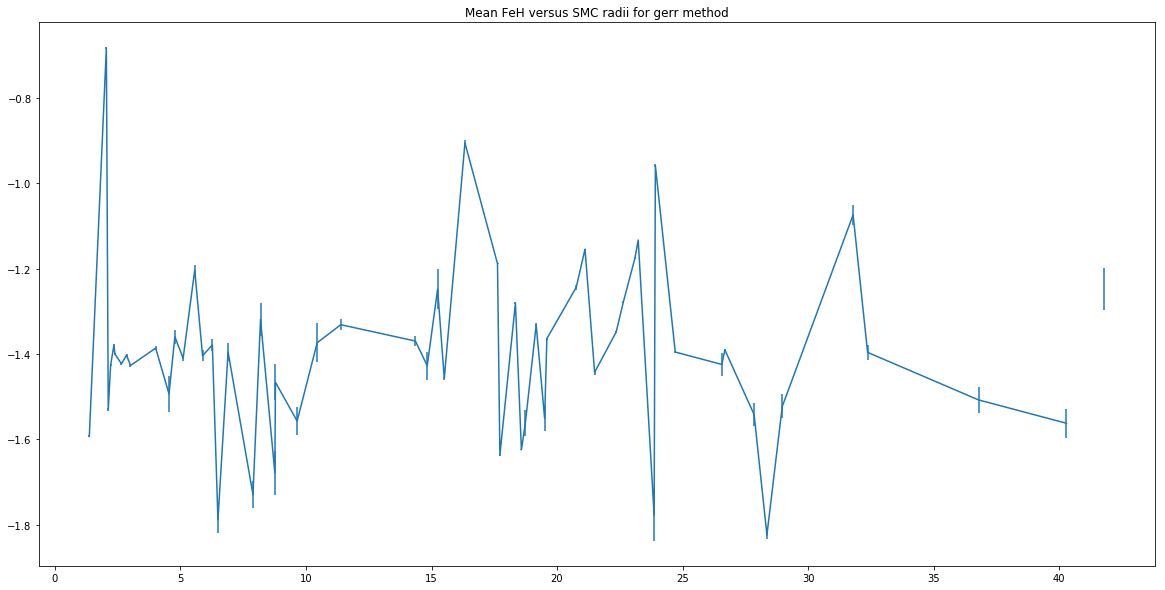

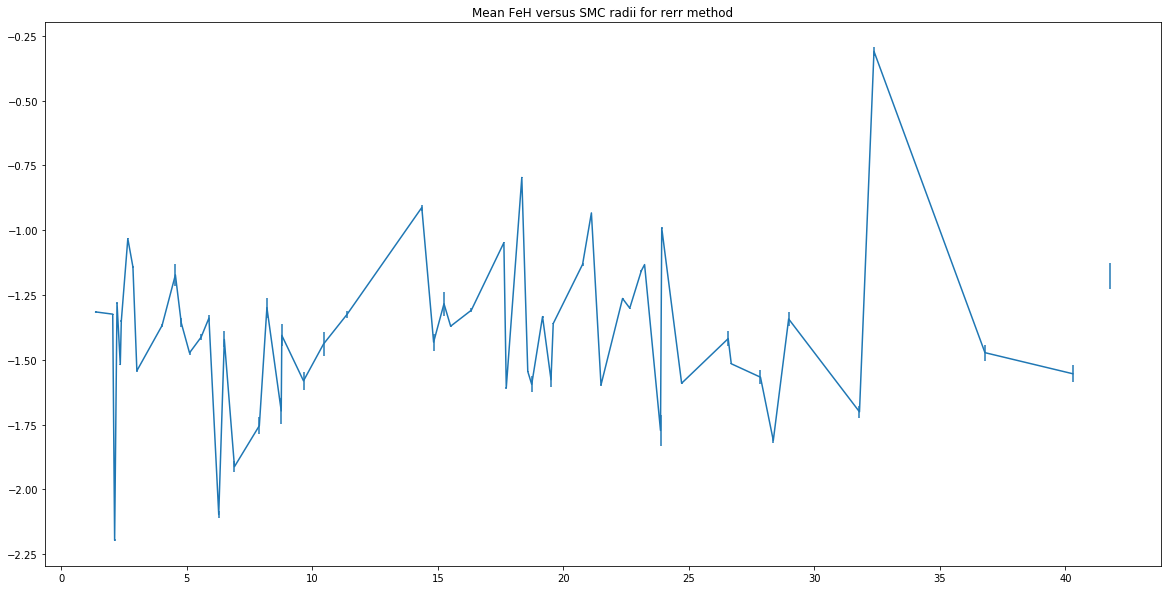

In [36]:
index = np.argsort(radii_smc)
for i, method in enumerate(('original','nearest','linear','cubic','nearest_regressor','ivezic','uerr','gerr','rerr')):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.errorbar(radii_smc[index],np.array(mean_metallicity[method])[index],yerr=np.array(error[method])[index])
    ax.set_title('Mean FeH versus SMC radii for '+method+' method')
    

Text(0.5,1,'Mean FeH versus LMC radii for color mean method')

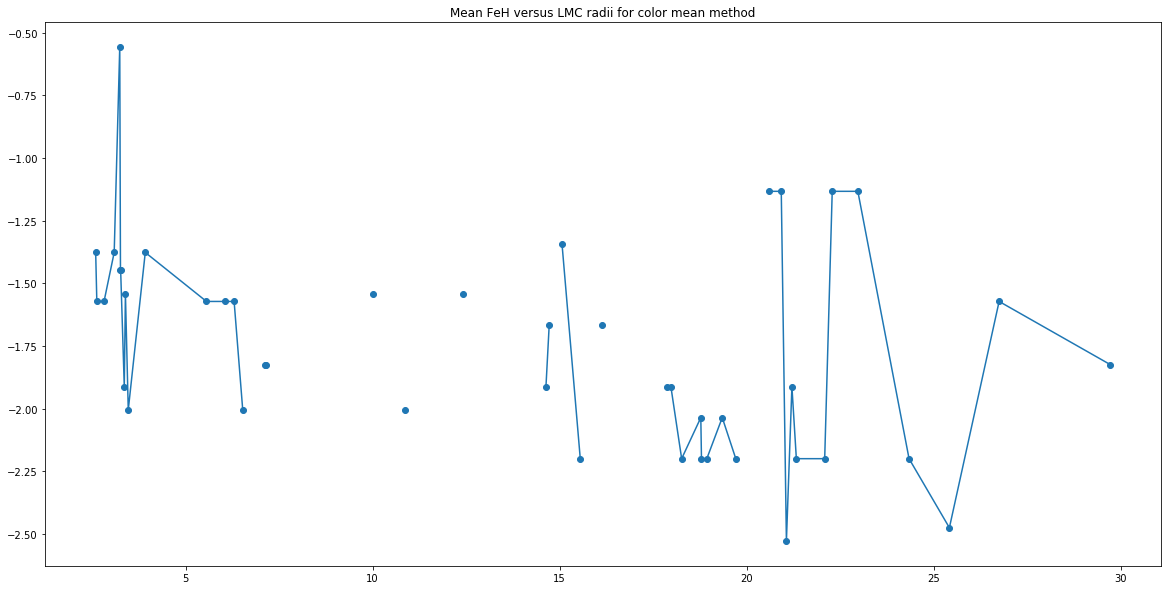

In [40]:
index = np.argsort(radii_lmc)
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(radii_lmc[index], np.array(color_mean['original'])[index], '-o')
#ax.scatter(radii_lmc[index],np.array(color_mean['original'])[index])
#ax.errorbar(radii_lmc[index],np.array(color_mean['original'])[index],yerr=np.array(error[method])[index])
ax.set_title('Mean FeH versus LMC radii for color mean method')

    

### Now, make stellar density plots of each field w/ calibration overlaid

In [44]:
from scipy.stats import kde
data = '/Users/amyel/research/SMASH_project/datafiles/SMASH_SDSS_LAMOST_crossmatch.fits'
fx = fitsio.FITS(data)
objs = fx[1].read()

In [45]:

objs = fx[1].read()
u_std = (objs["U"]-(4.239*objs["EBV"]))
g_std = (objs["G"]-(3.303*objs["EBV"]))
i_std = (objs["I"]-(1.263*objs["EBV"]))
r_std = (objs["R"]-(2.285*objs["EBV"]))
u_g_std = u_std - g_std
g_r_std = g_std - r_std
selected = np.where((u_std<=30)&(r_std<=30)&(g_std<=30))
u_std,g_std,r_std = u_std[selected],g_std[selected],r_std[selected]


In [46]:
xx_std, yy_std = np.mgrid[u_g_std.min():u_g_std.max():1000j, g_r_std.min():g_r_std.max():1000j]
positions = np.vstack([xx_std.ravel(), yy_std.ravel()])
values = np.vstack([u_g_std, g_r_std])
k_std = kde.gaussian_kde(values)

In [47]:
zz_std = np.reshape(k_std(positions).T, xx_std.shape)

In [48]:
 def density_plots(filename):
    
    fx = fitsio.FITS(filename)
    objs = fx[1].read()
    
    newstr = ''.join((ch if ch in '0123456789' else ' ') for ch in filename)
    field_number = [int(i) for i in newstr.split()]
    
    u = (objs["U"]-(4.239*objs["EBV"]))
    g = (objs["G"]-(3.303*objs["EBV"]))
    i = (objs["I"]-(1.263*objs["EBV"]))
    r = (objs["R"]-(2.285*objs["EBV"]))
    selected = np.where((u<=22)&(r<=22)&(g<=22)&(objs['CHI']<3)&(abs(objs['SHARP'])<1)&(objs['PROB']>.8))
    u,g,r = u[selected],g[selected],r[selected]
    u_g = u-g
    g_r = g-r
    
    fig, ax = plt.subplots(figsize=(20, 10))
    hess = stats.binned_statistic_2d(u_g, g_r, None, 'count',bins=1000)
    im = ax.pcolormesh(hess.x_edge,hess.y_edge,hess.statistic.T,cmap='bone',norm=clr.LogNorm())
    ax.contour(xx_std,yy_std,zz_std,cmap='spring')
    cb = fig.colorbar(im,ax=ax,label='count in bin')
    ax.set_xlim(-.5,2.7)
    ax.set_ylim(-.5,1.6)
    ax.set_title('Density Plot of SMASH Field '+str(field_number[0])+' with Contours of SMASH Calibration Data Overlaid')
    
    plt.show(block=False)
    print('done with field '+str(field_number))
    return 0


In [53]:
fields = [1, 2, 3, 4, 5, 7, 8, 9, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 40, 42, 44, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 66, 68, 149, 150, 156, 176, 177, 178, 246]
import matplotlib.colors as clr

/Users/amyel/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


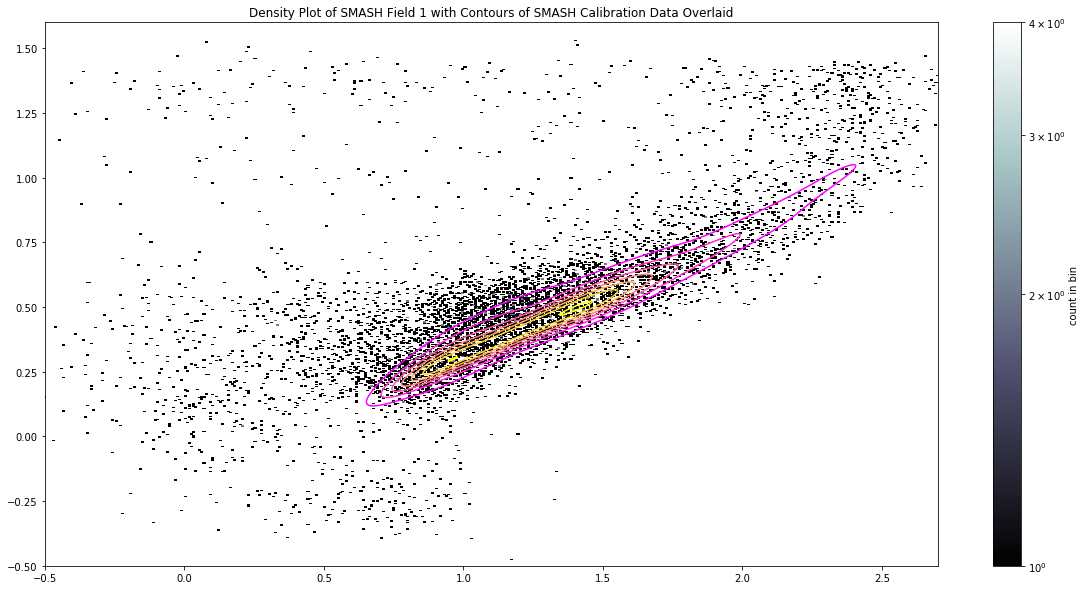

done with field [1]


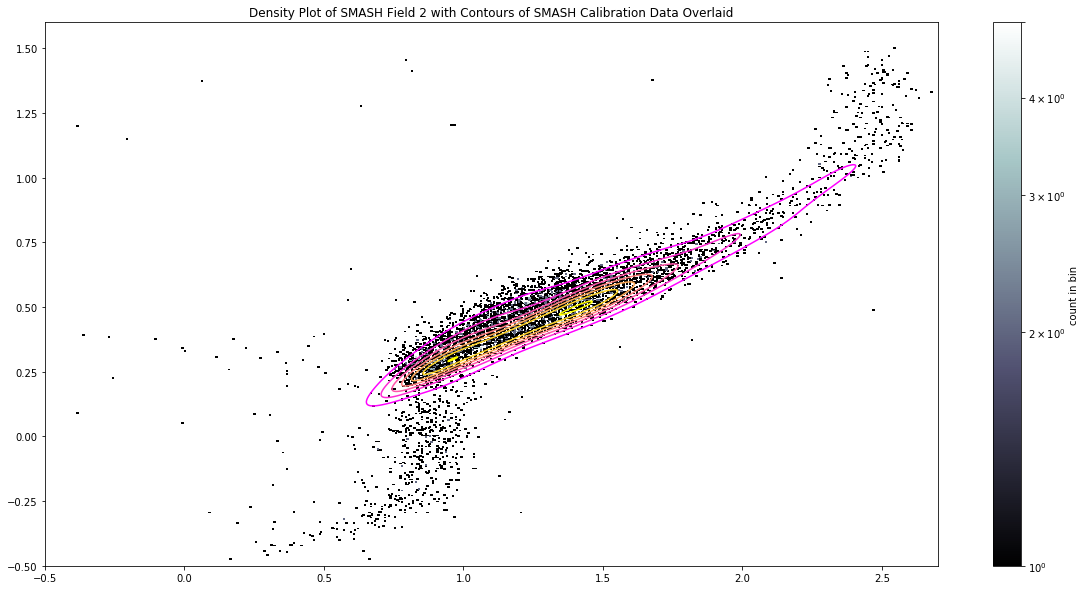

done with field [2]


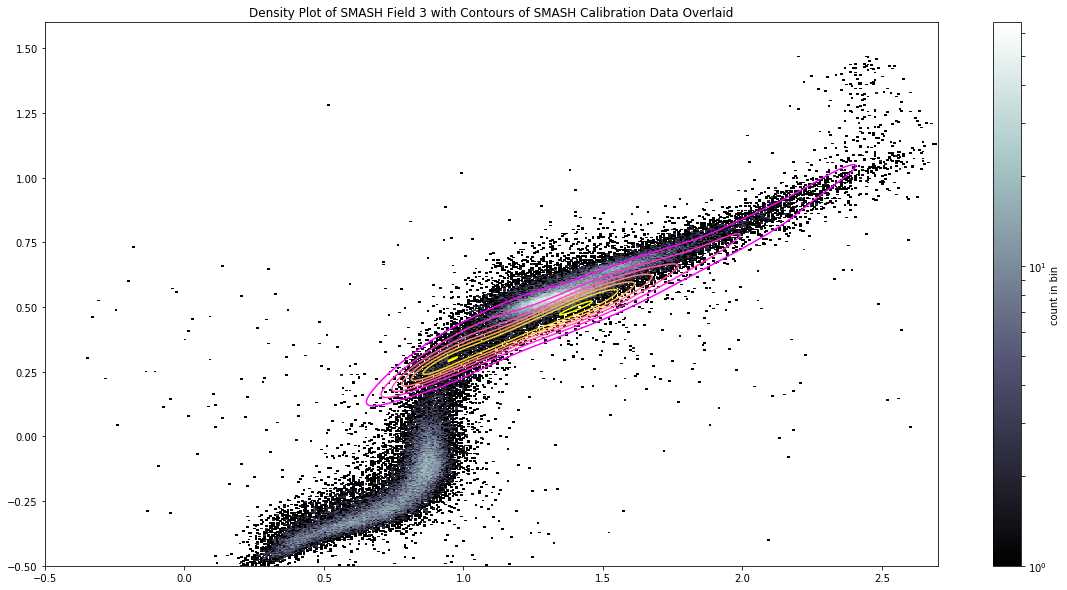

done with field [3]


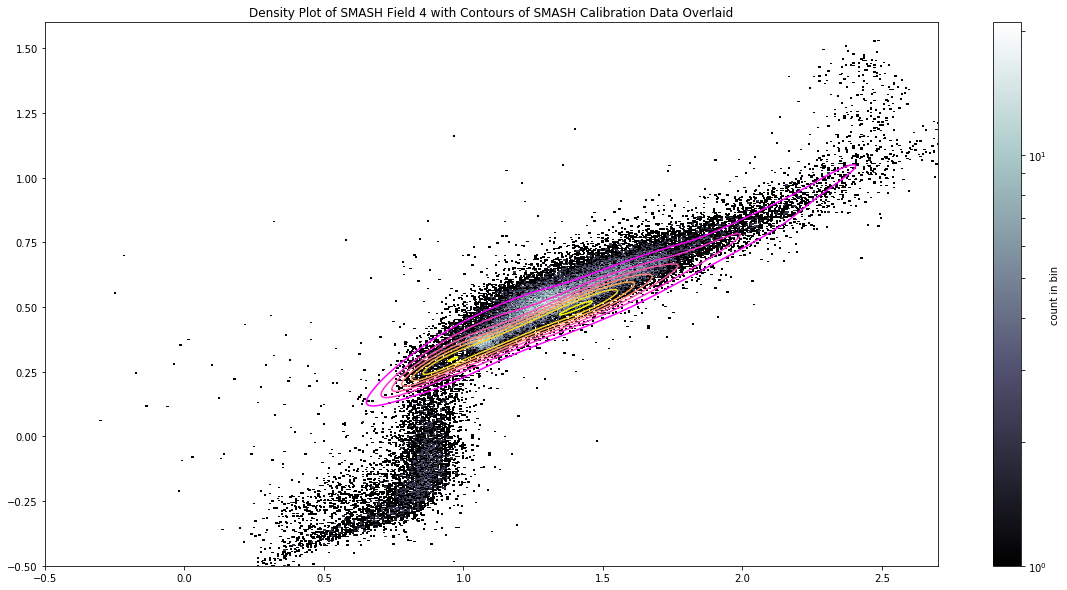

done with field [4]


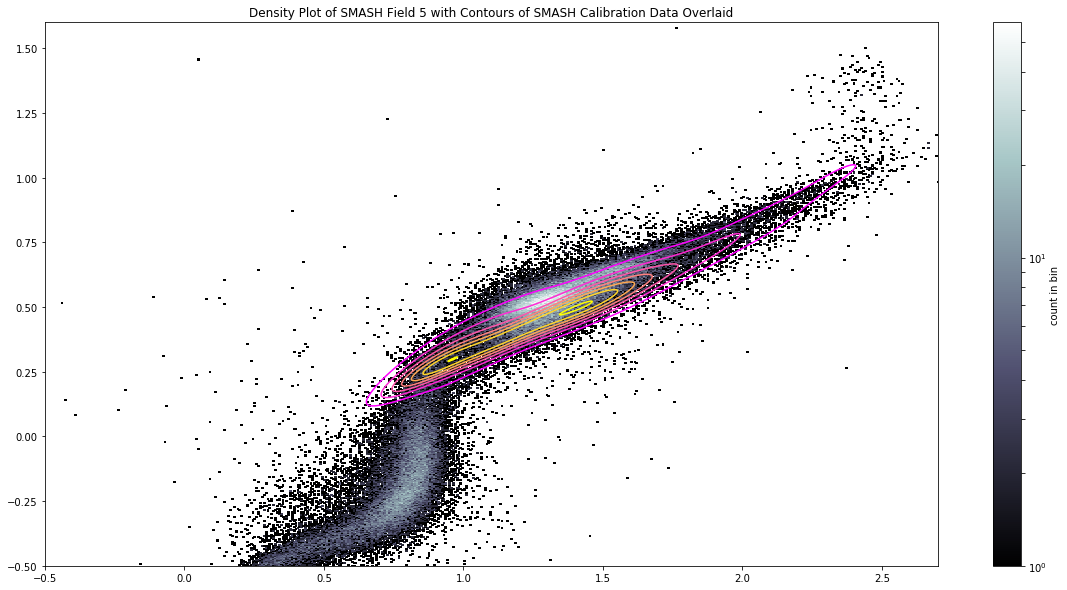

done with field [5]


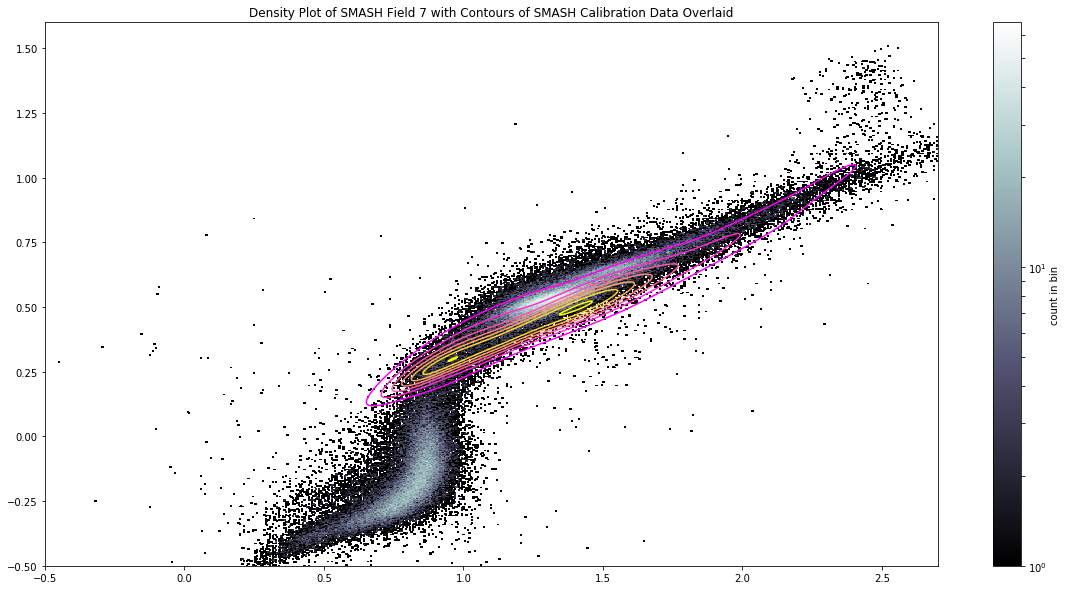

done with field [7]


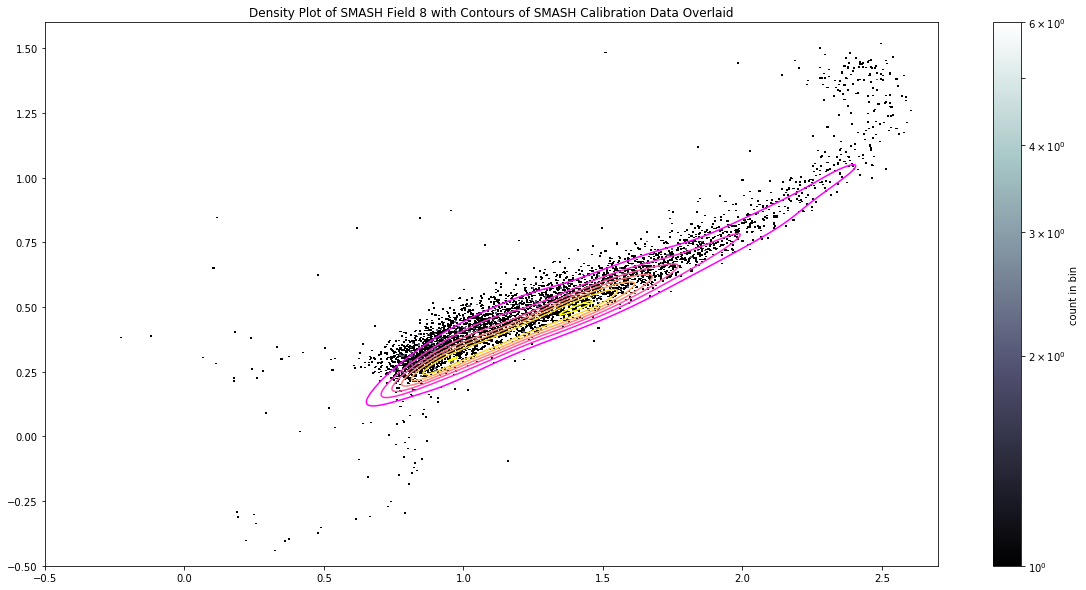

done with field [8]


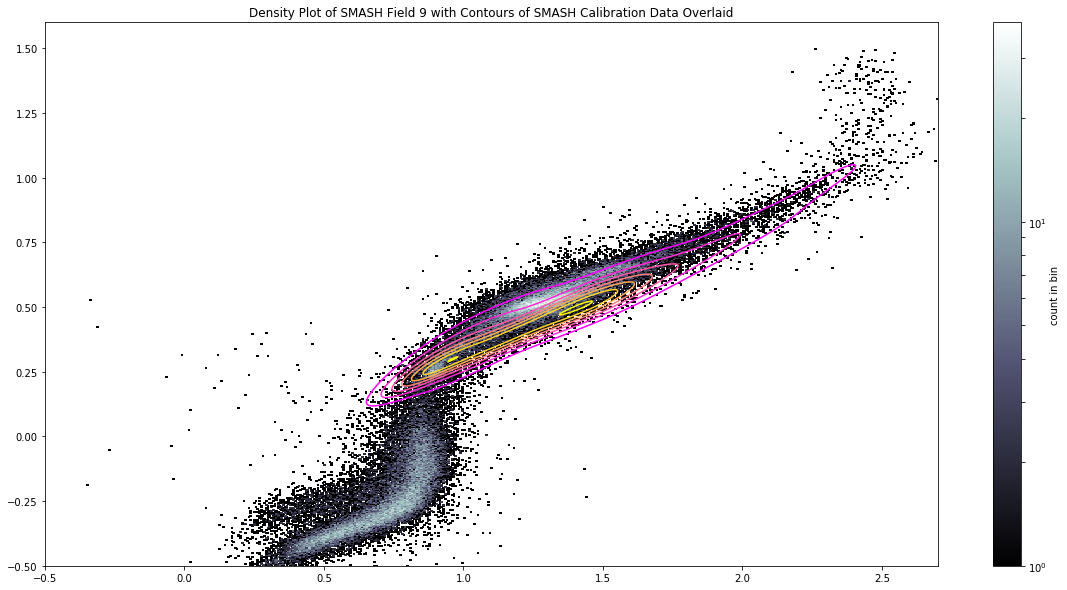

done with field [9]


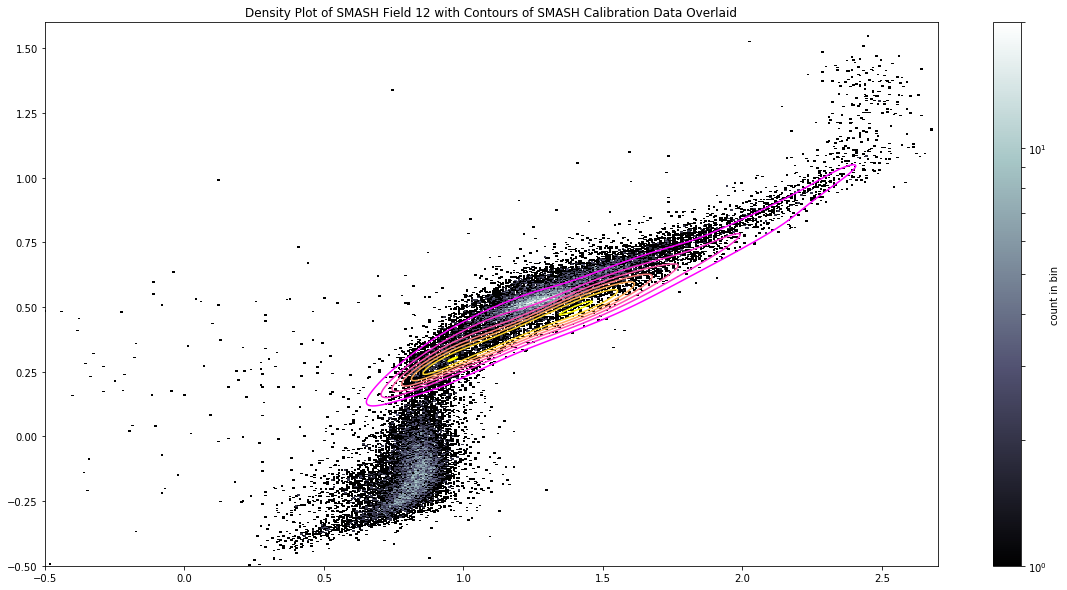

done with field [12]


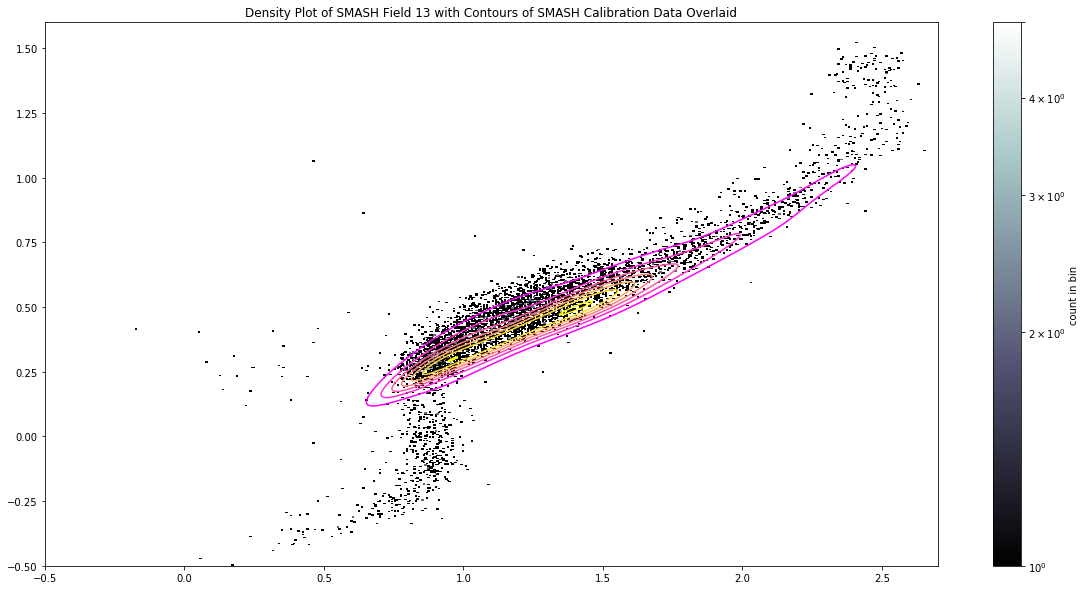

done with field [13]


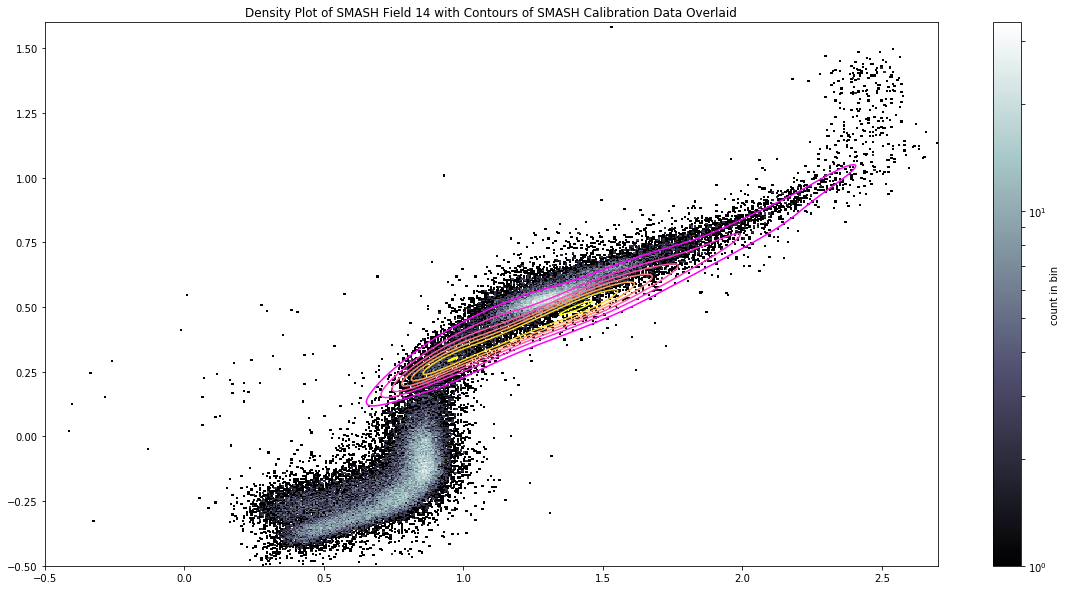

done with field [14]


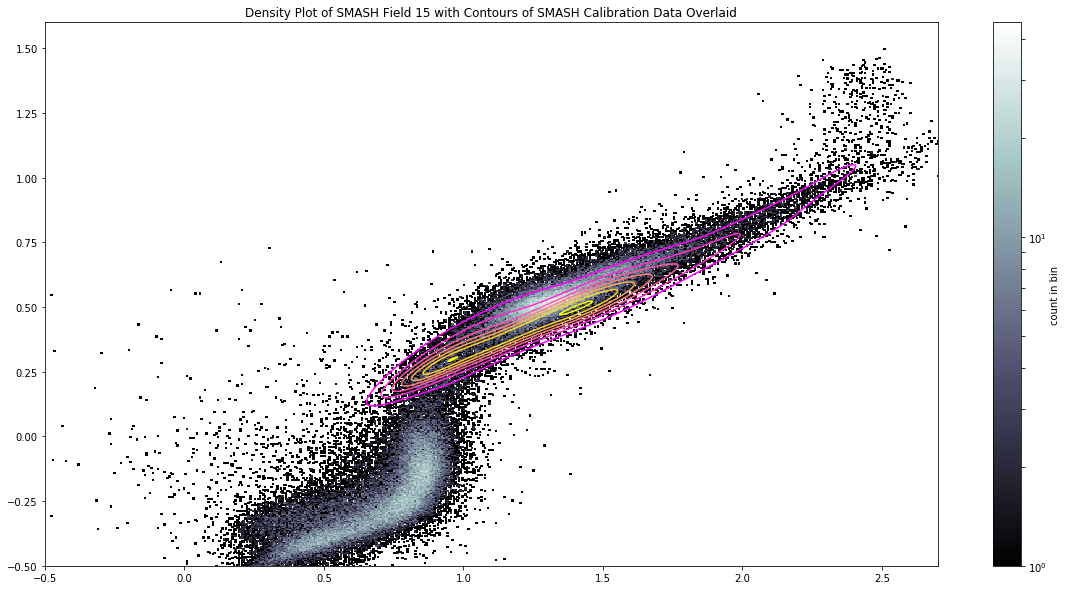

done with field [15]


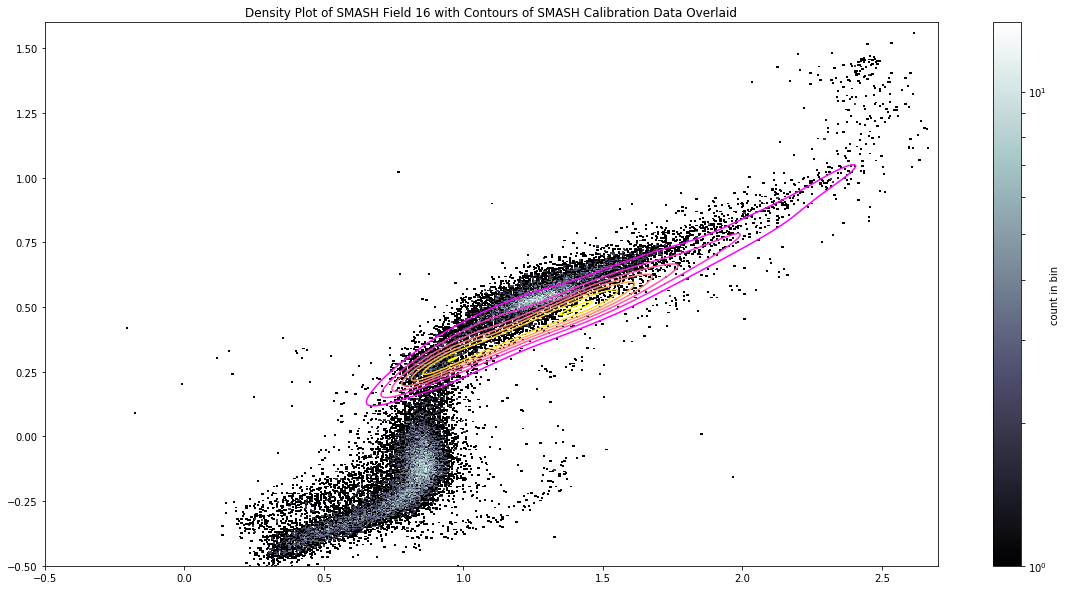

done with field [16]


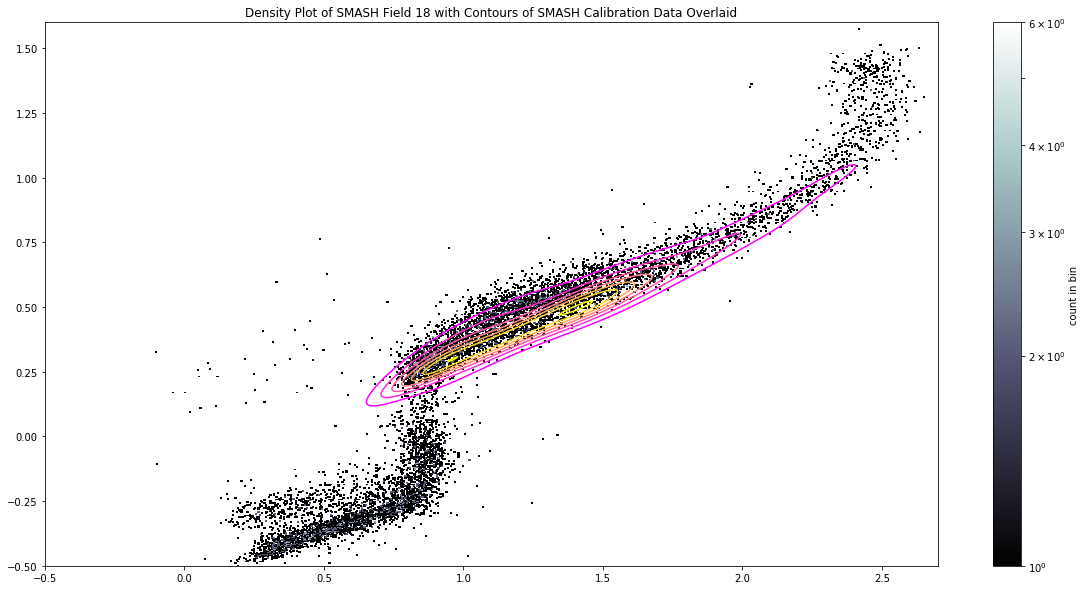

done with field [18]


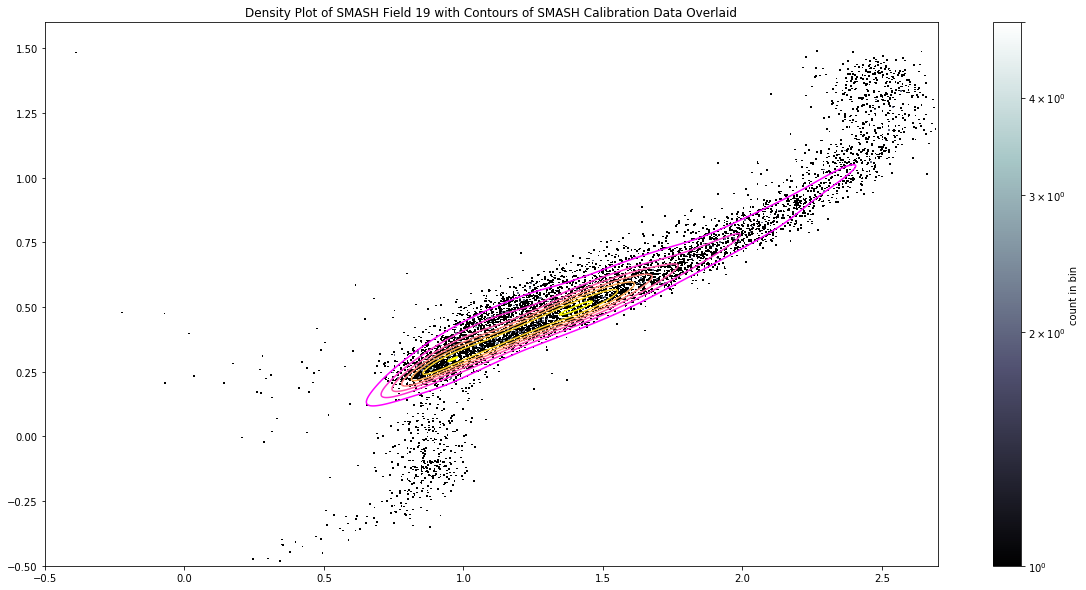

done with field [19]


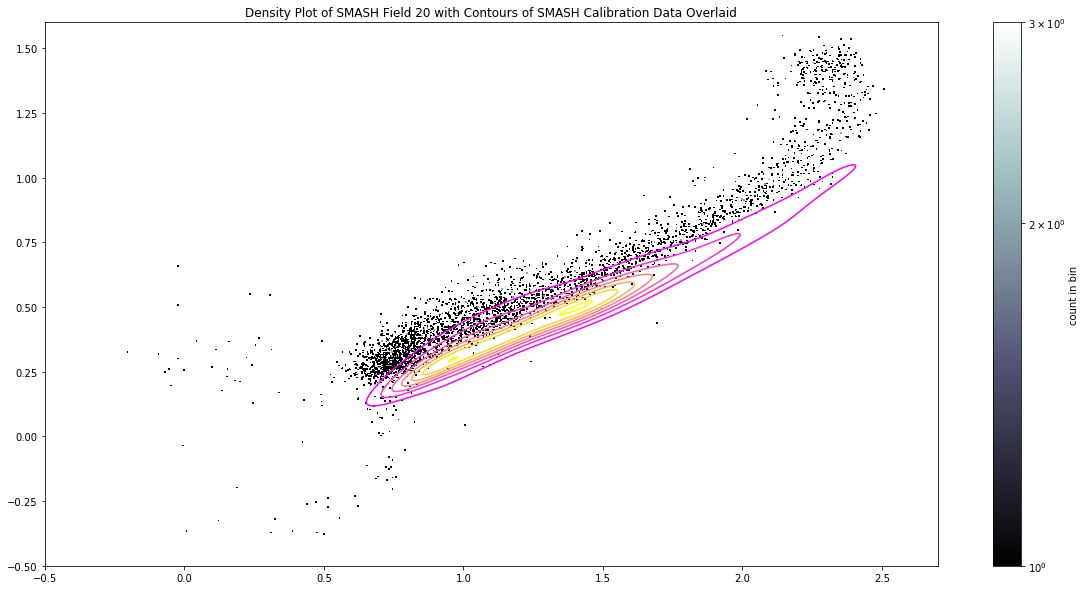

done with field [20]


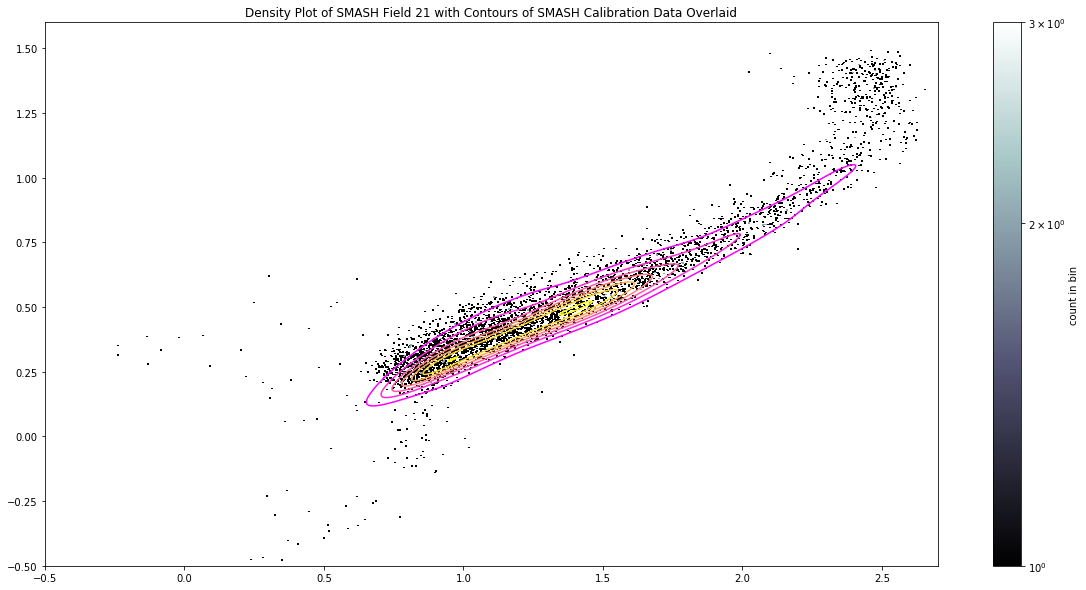

done with field [21]


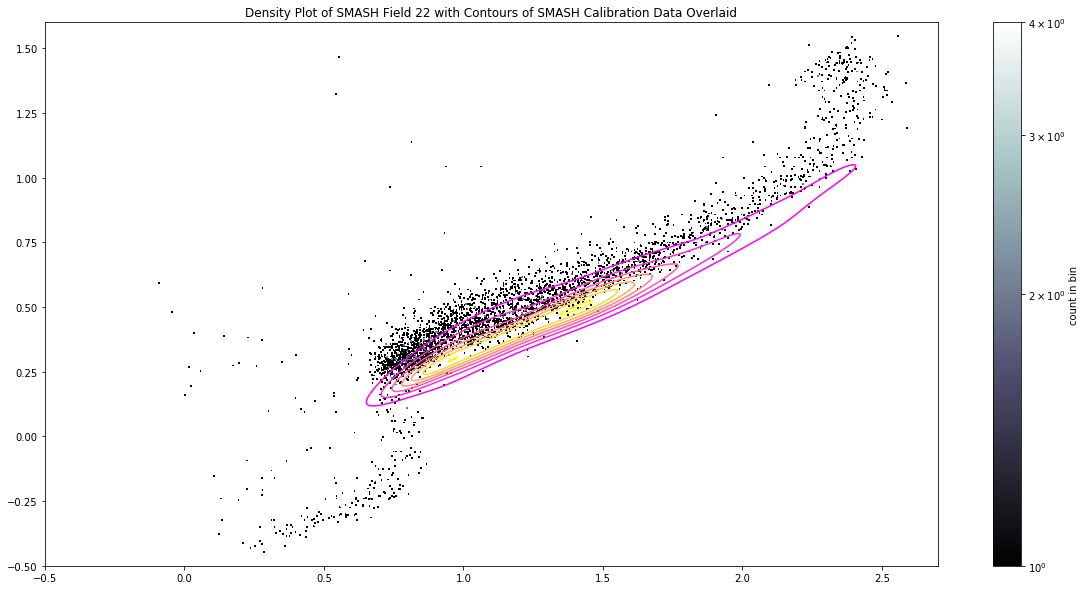

done with field [22]


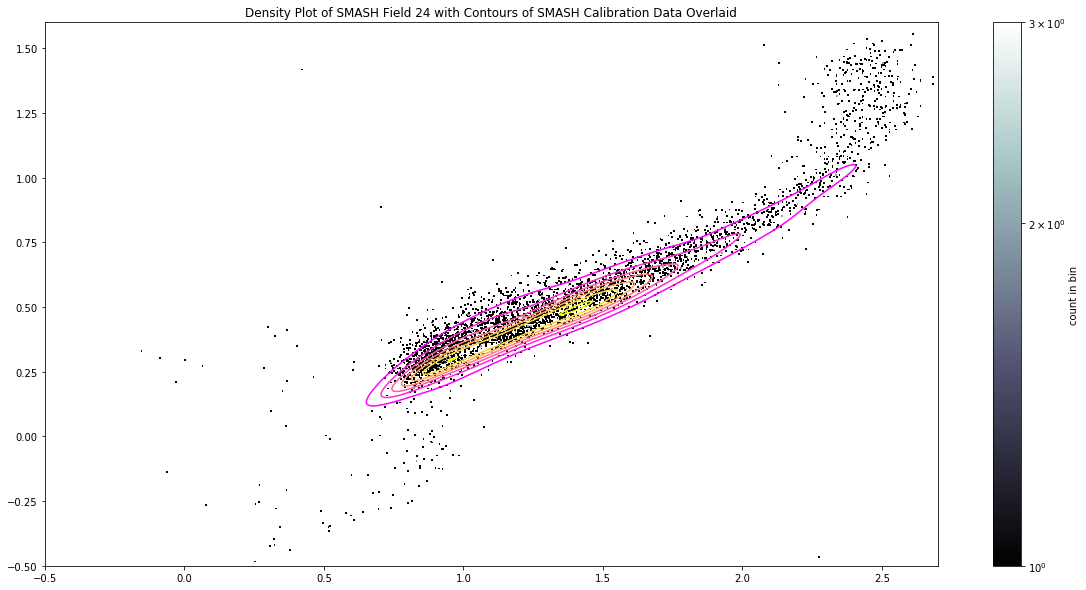

done with field [24]


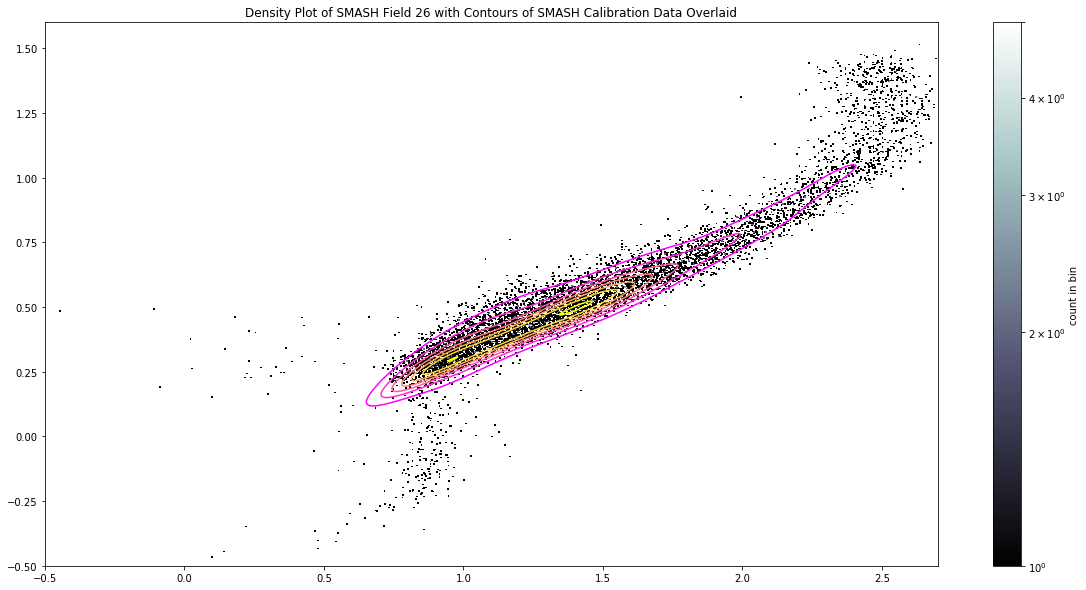

done with field [26]


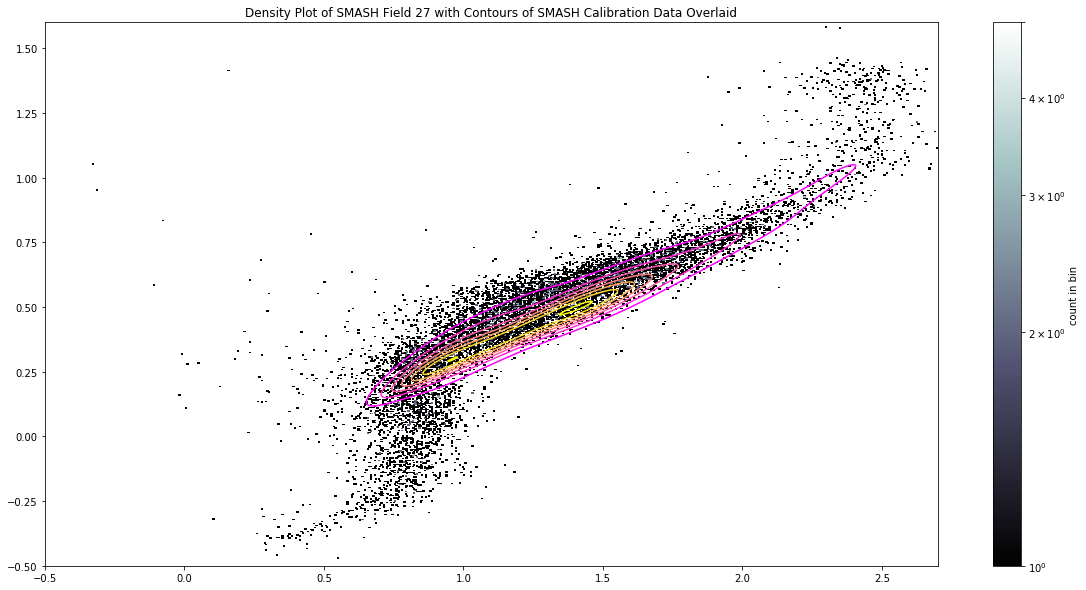

done with field [27]


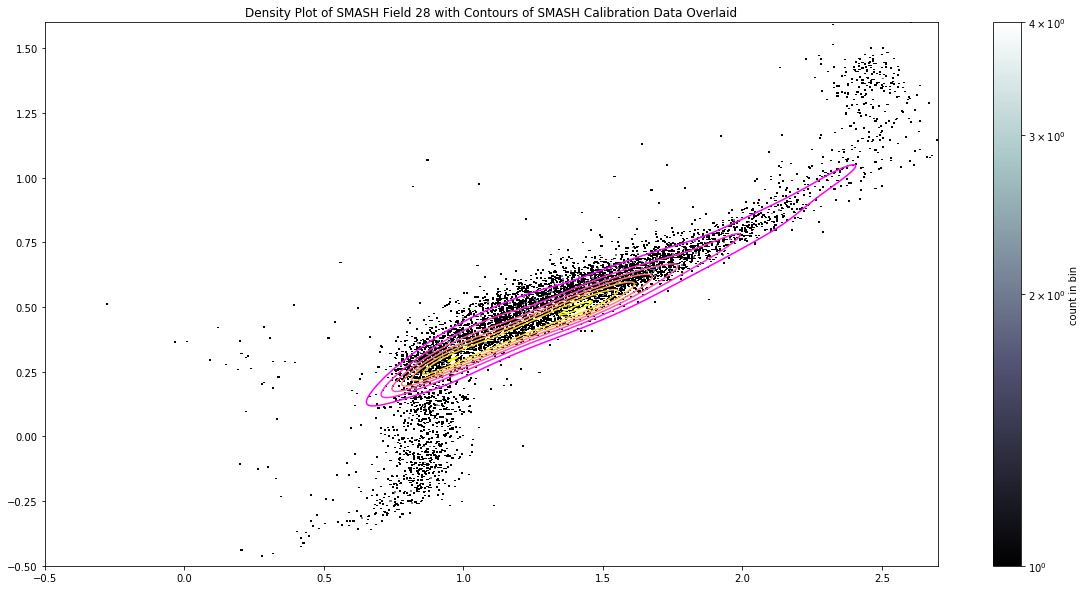

done with field [28]


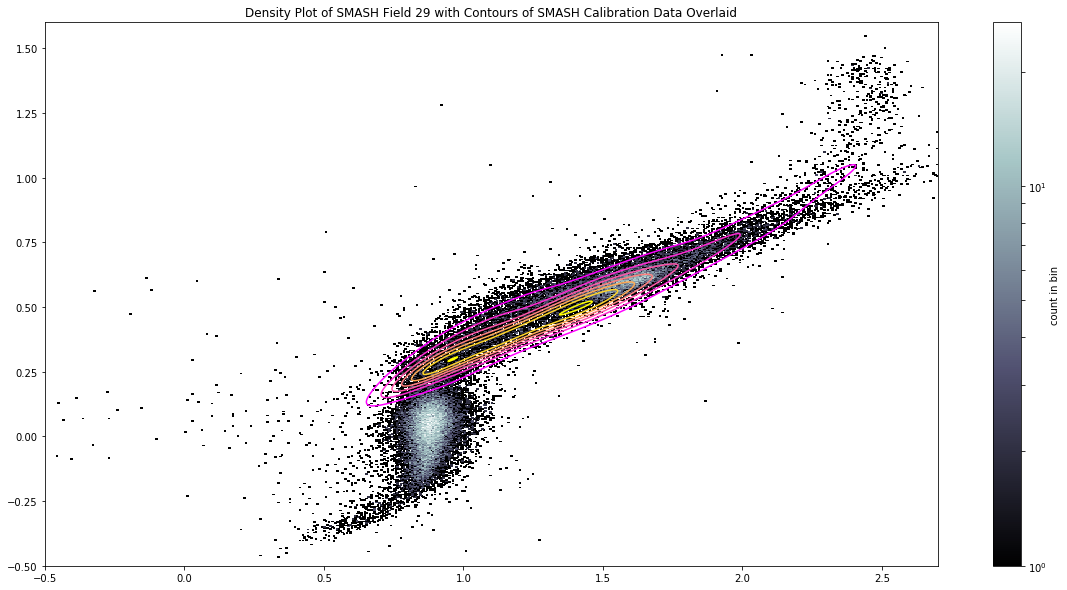

done with field [29]


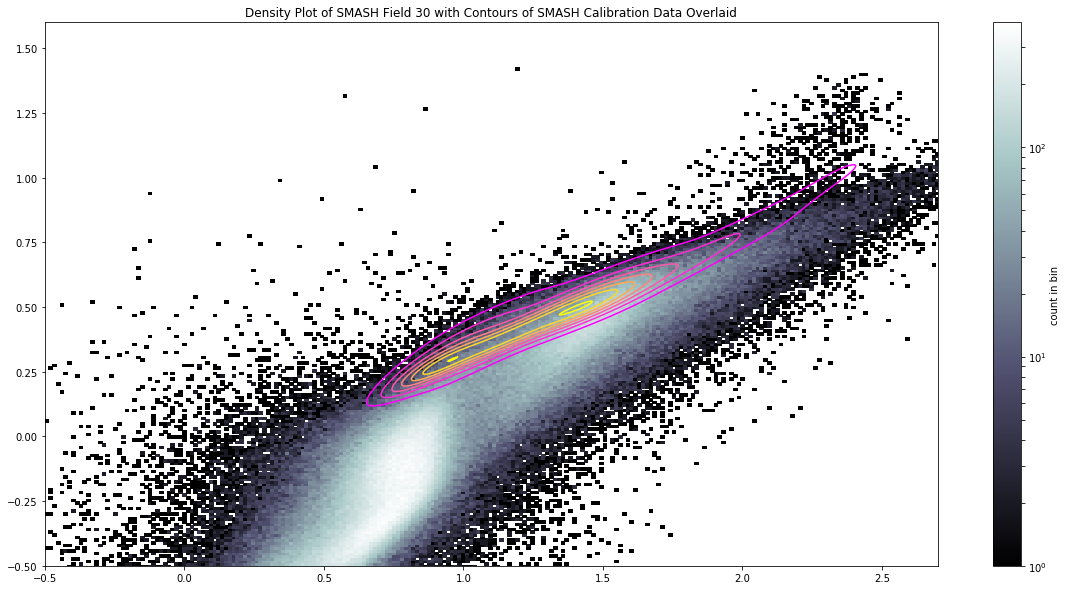

done with field [30]


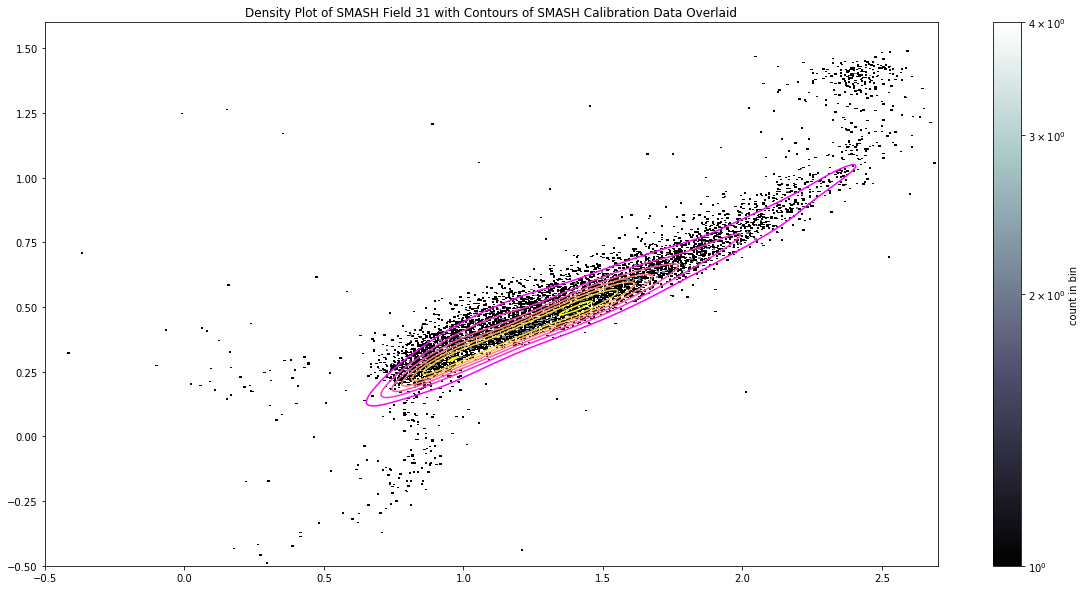

done with field [31]


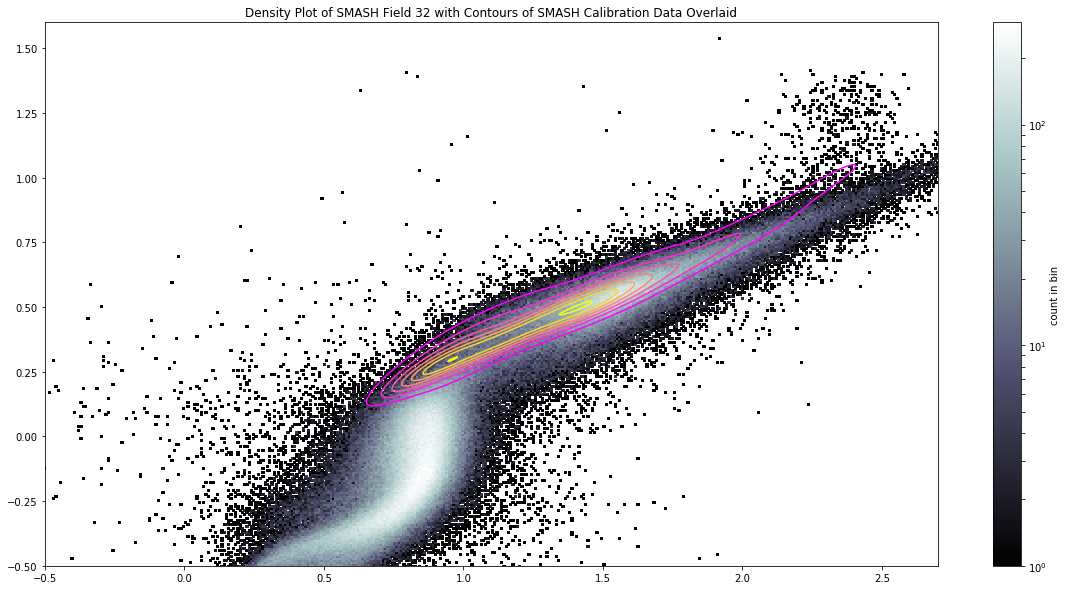

done with field [32]


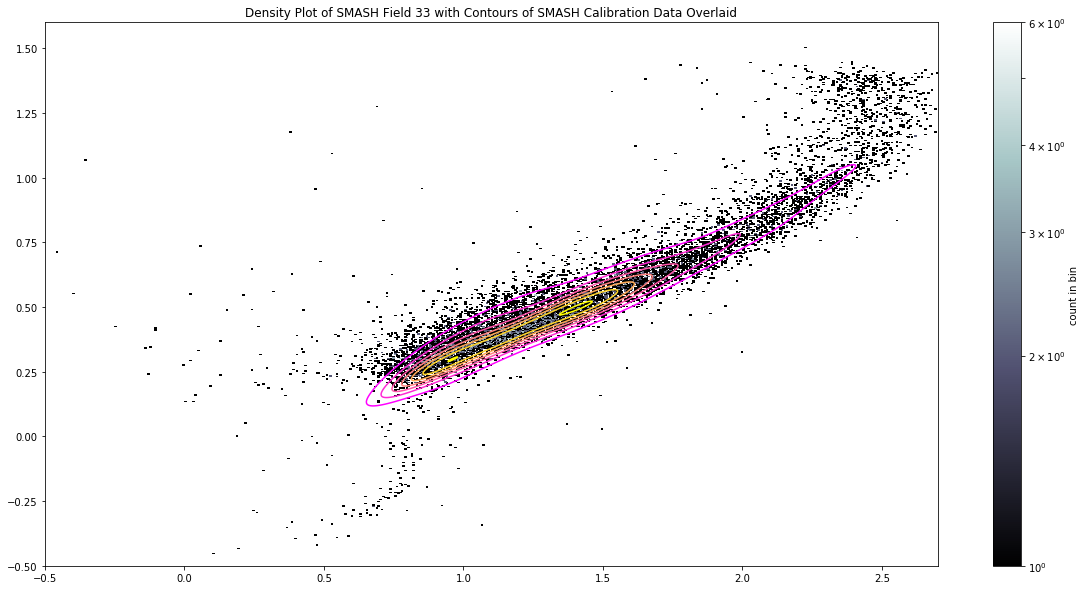

done with field [33]


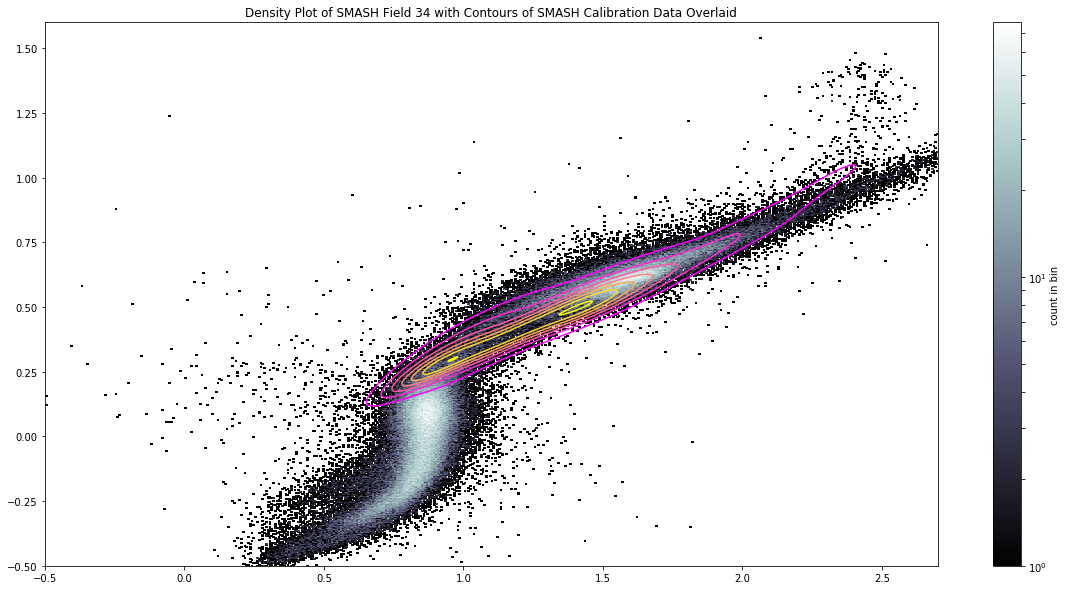

done with field [34]


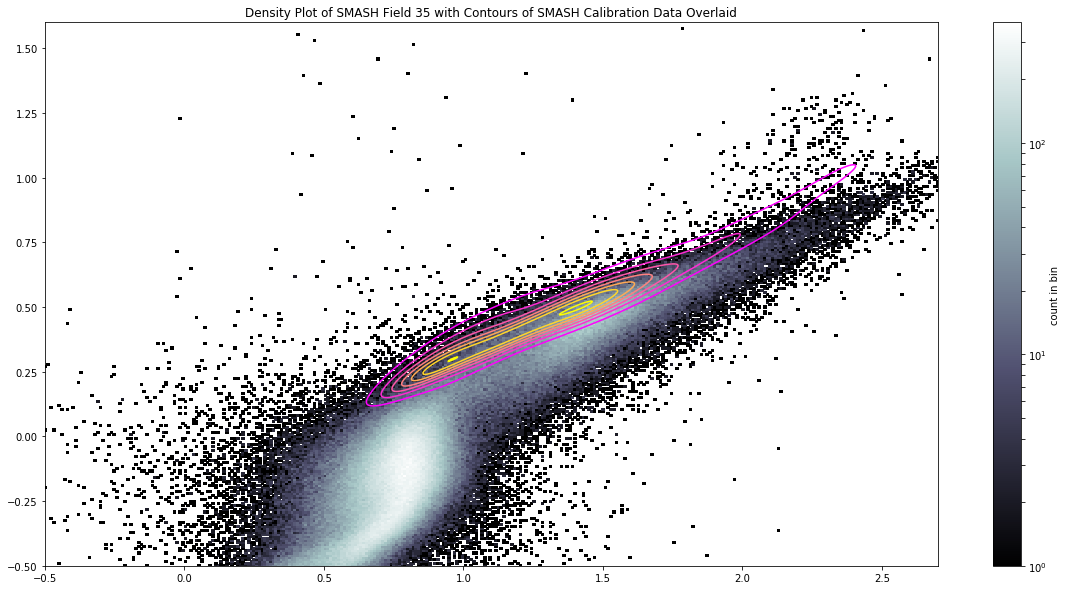

done with field [35]


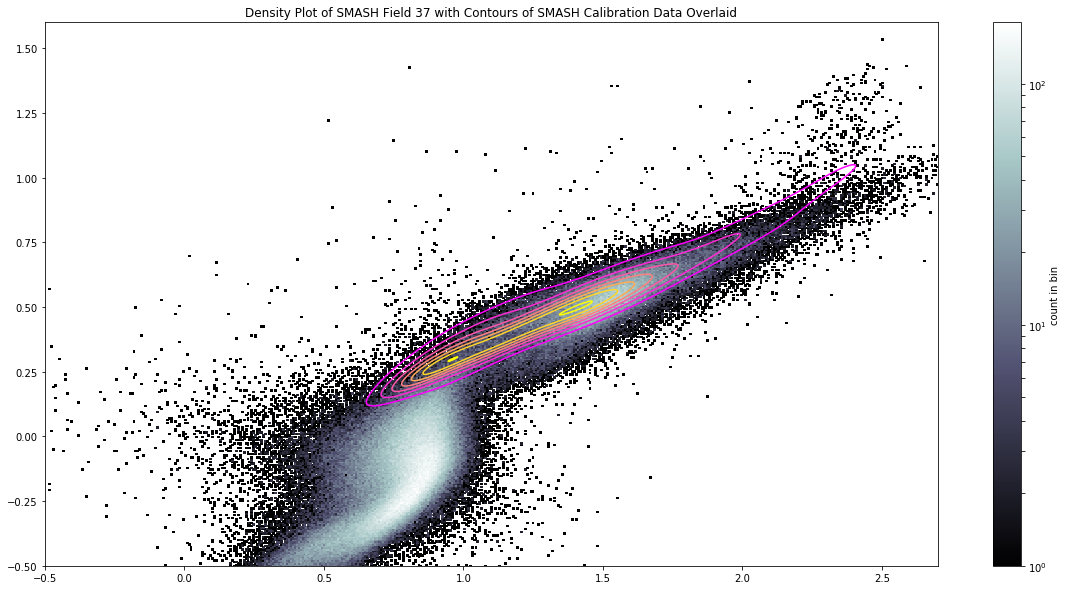

done with field [37]


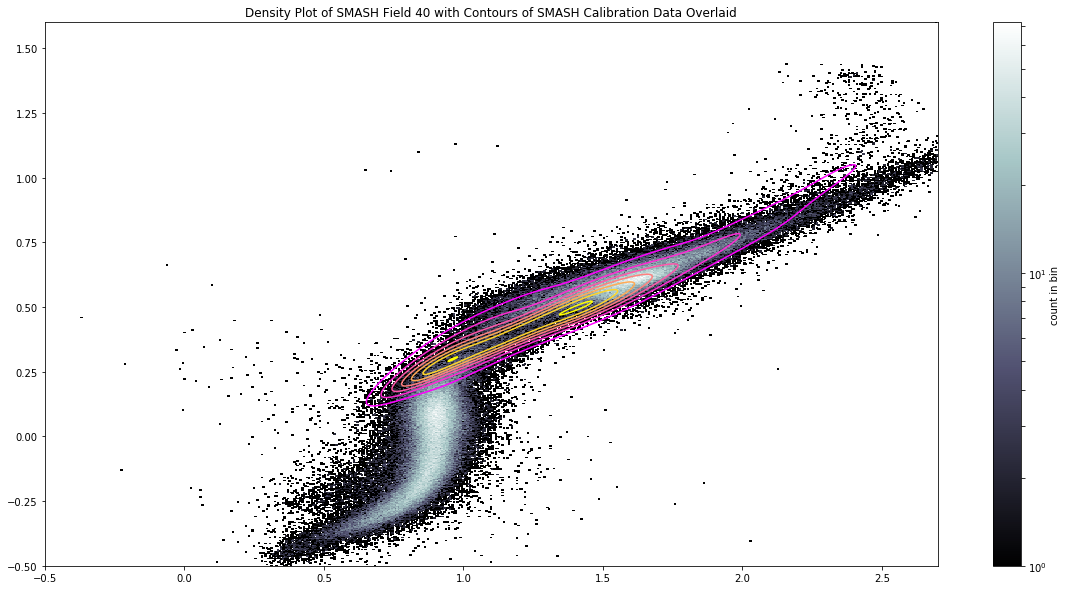

done with field [40]


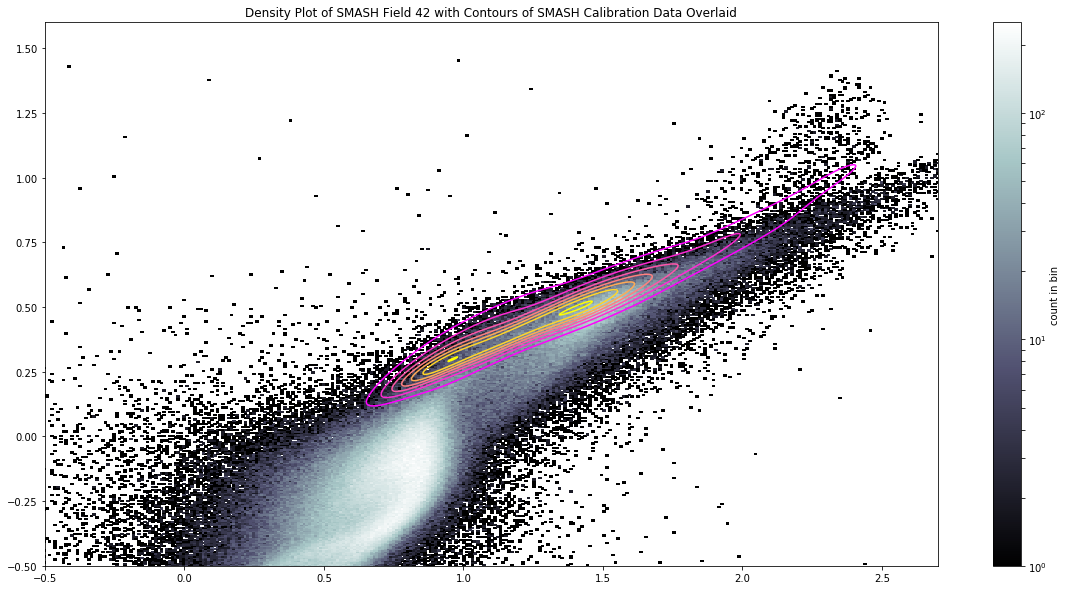

done with field [42]


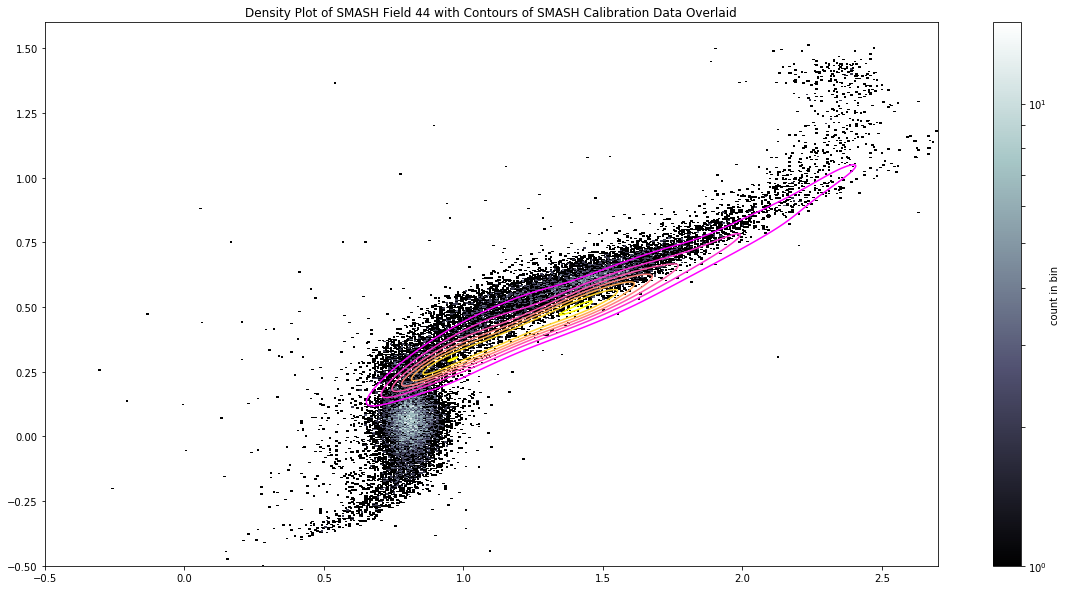

done with field [44]


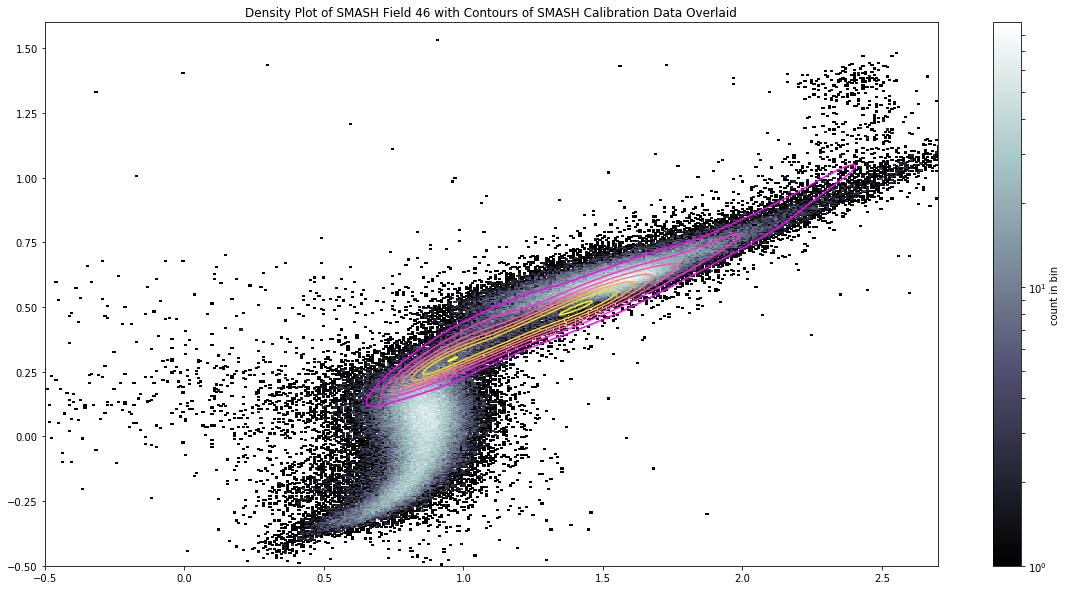

done with field [46]


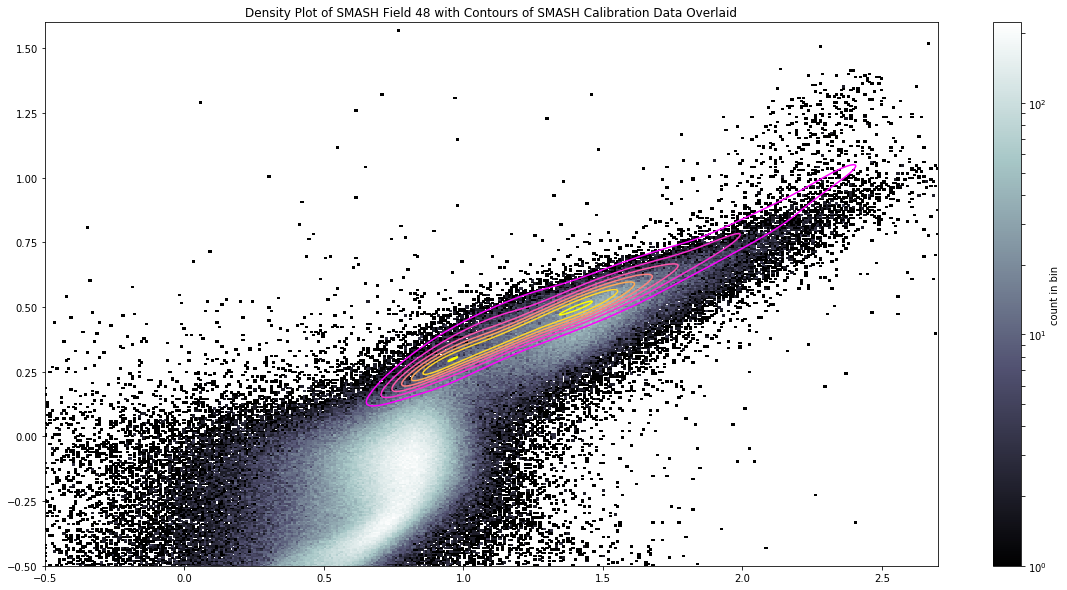

done with field [48]


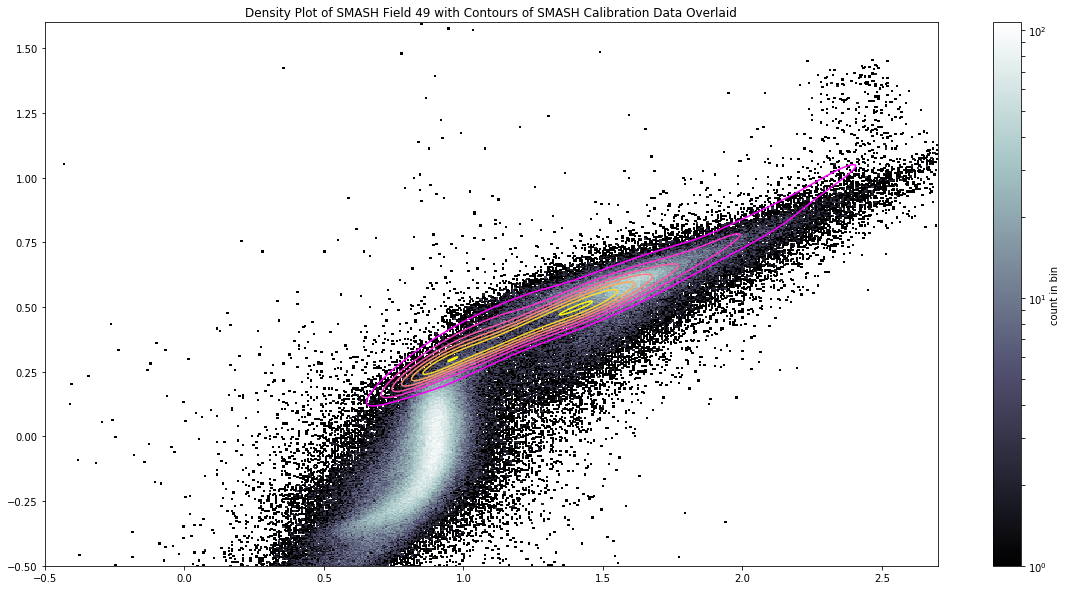

done with field [49]


/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less_equal
  del sys.path[0]


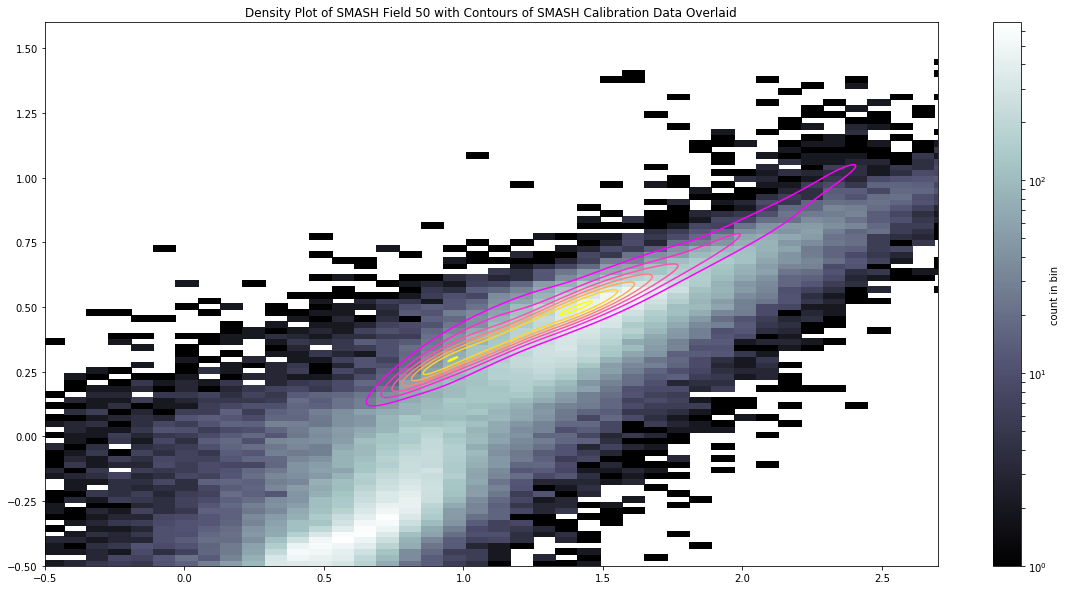

done with field [50]


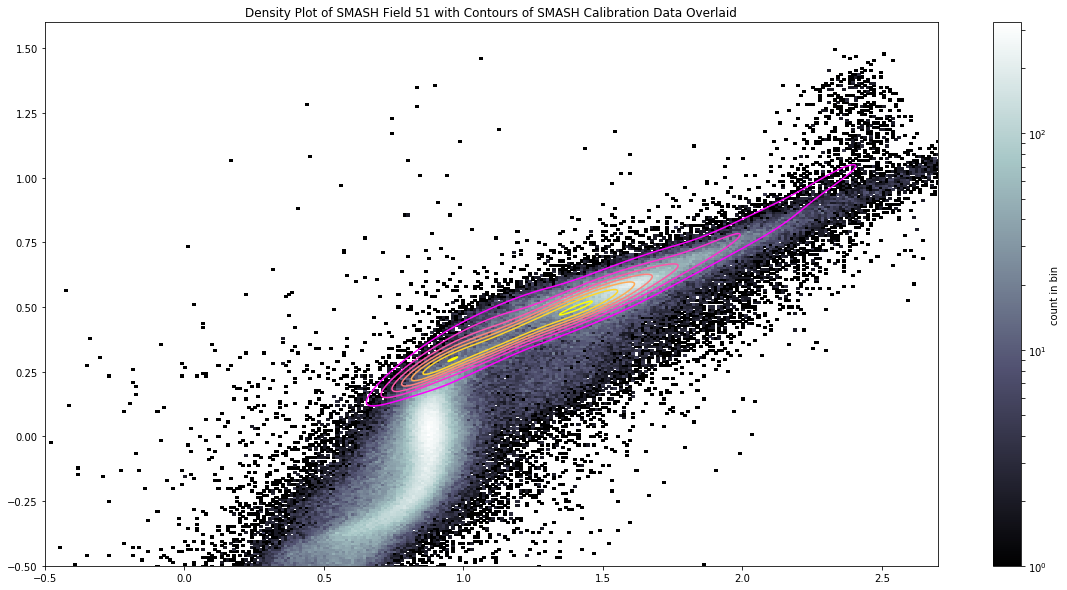

done with field [51]


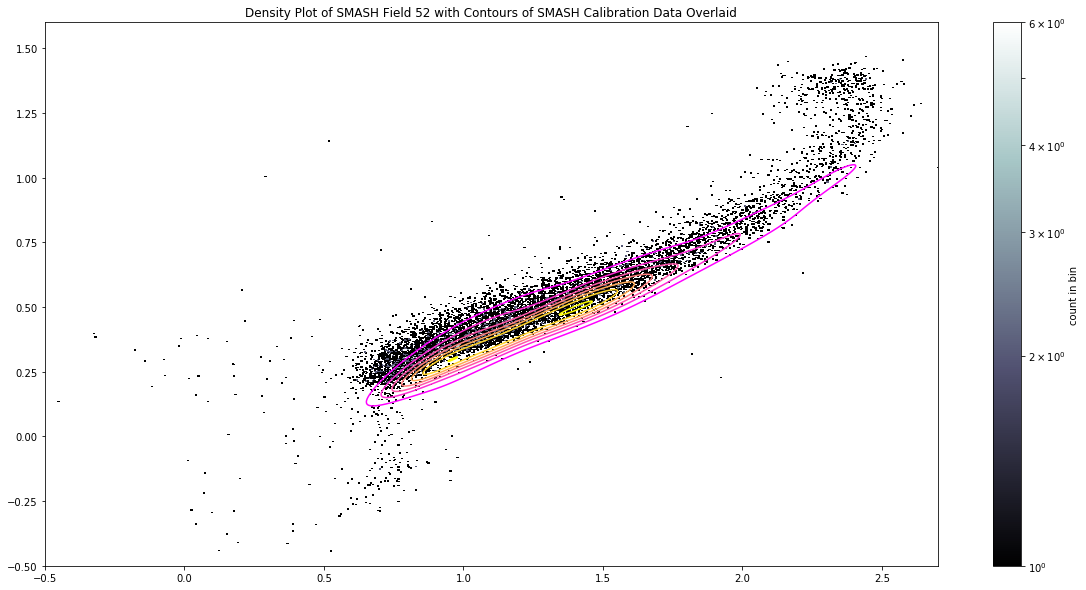

done with field [52]


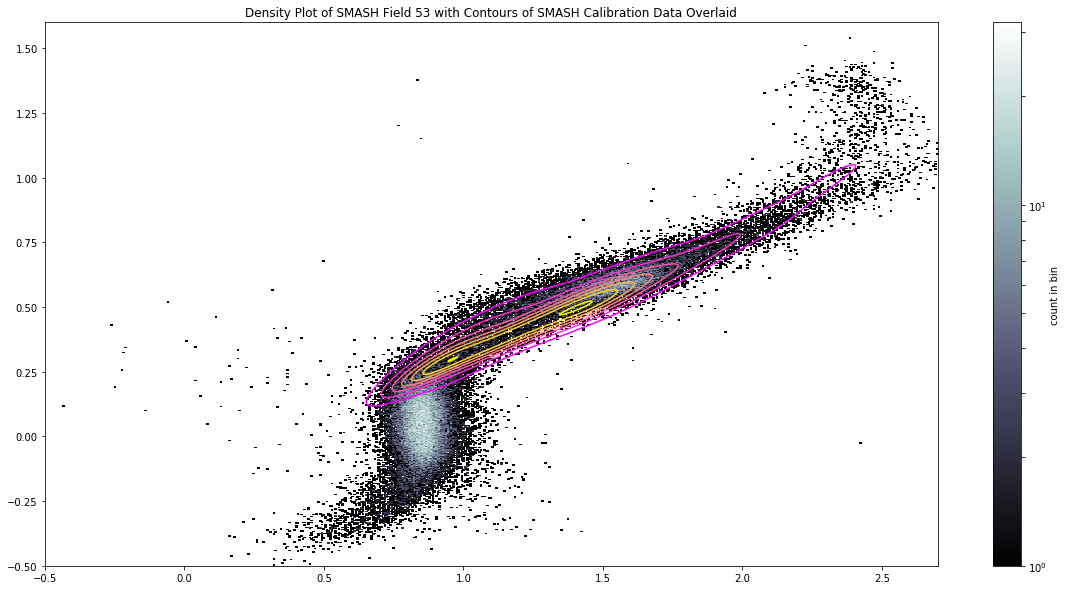

done with field [53]


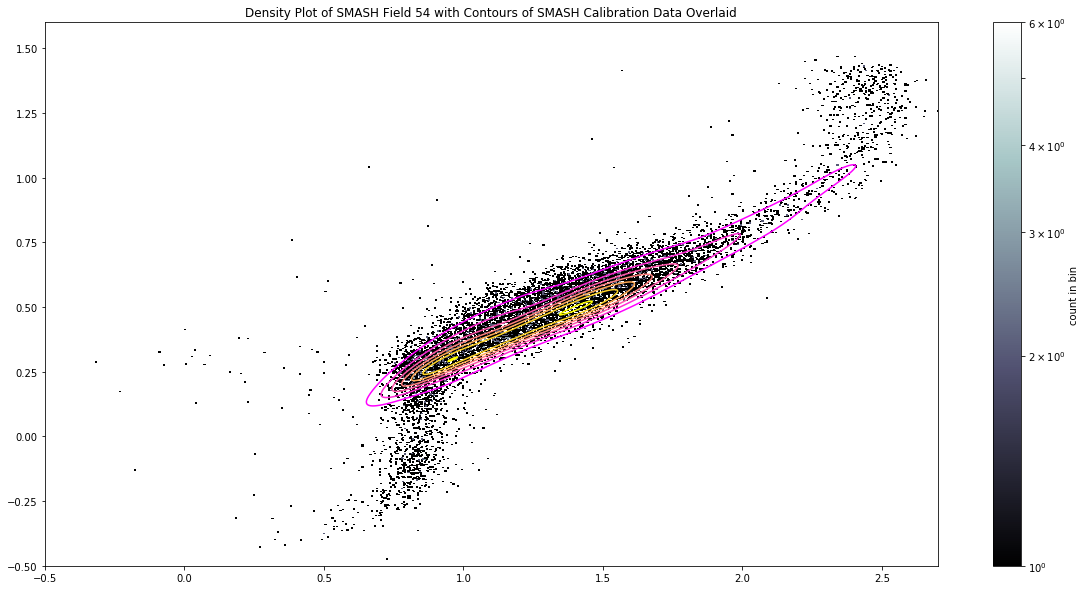

done with field [54]


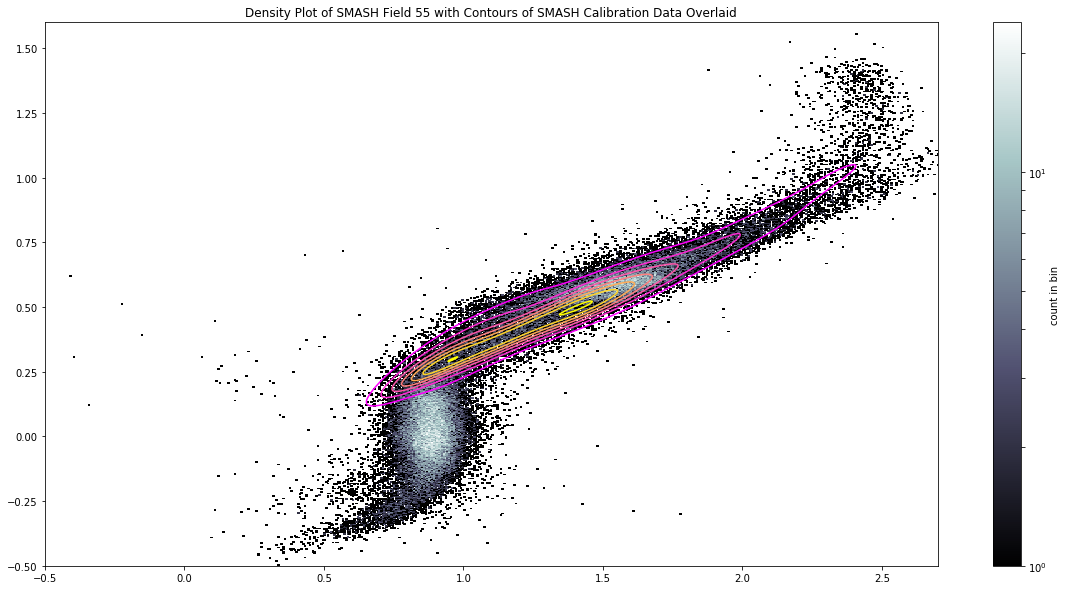

done with field [55]


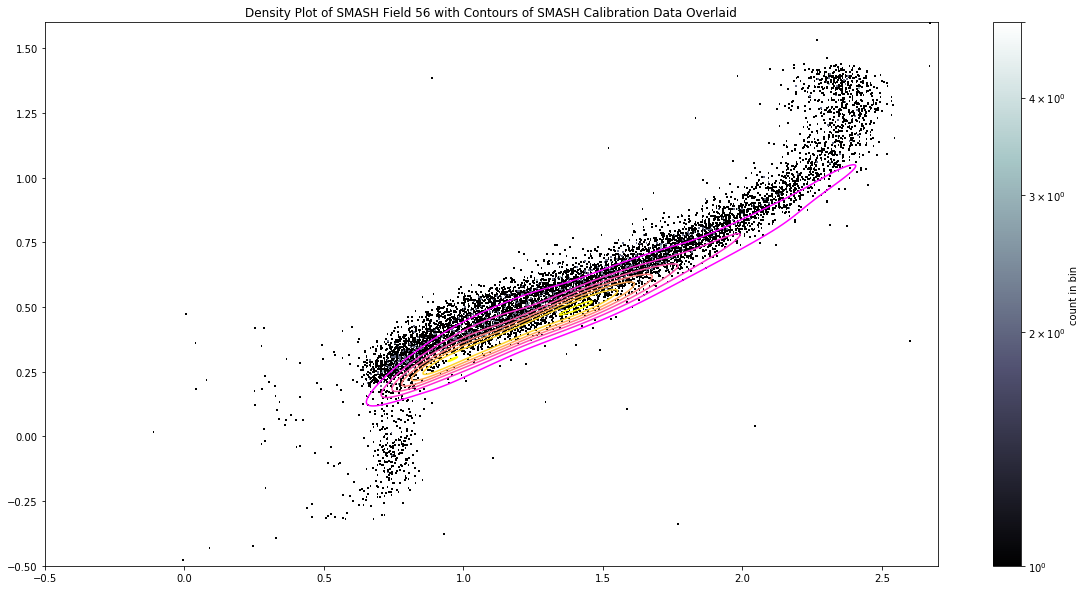

done with field [56]


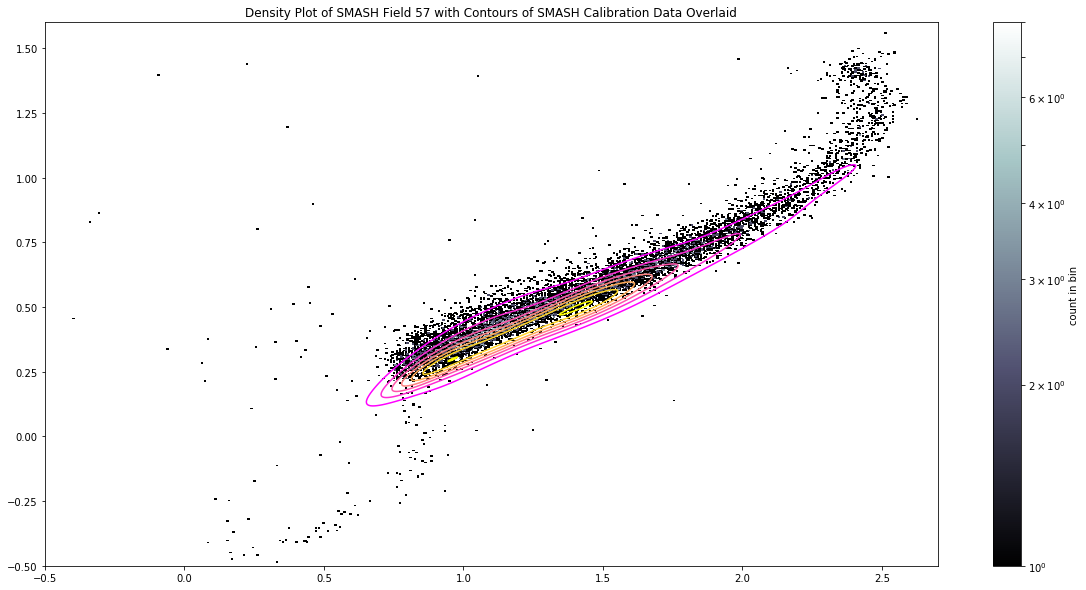

done with field [57]


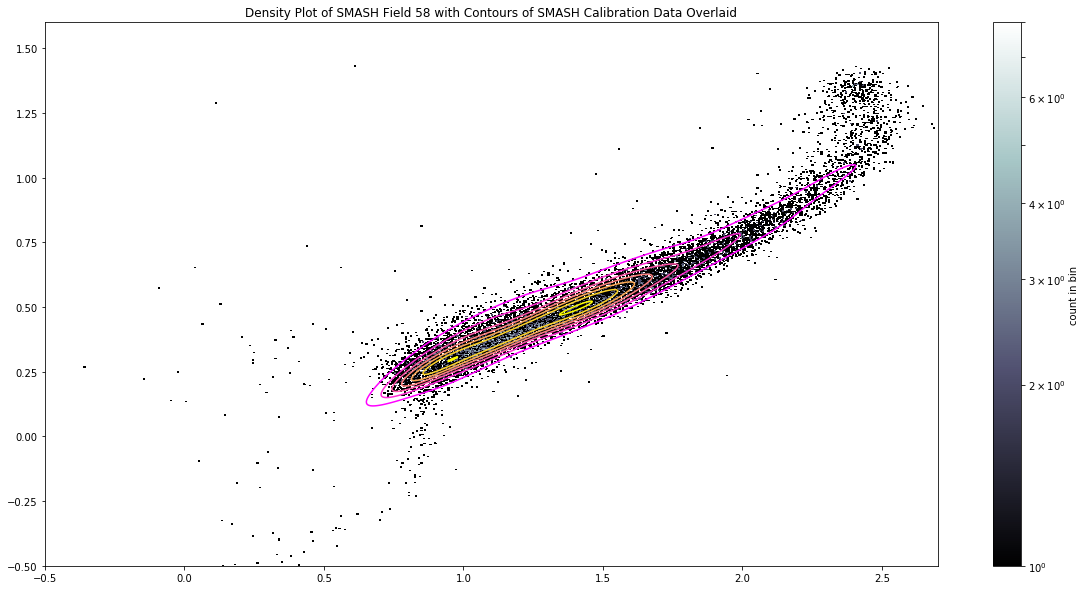

done with field [58]


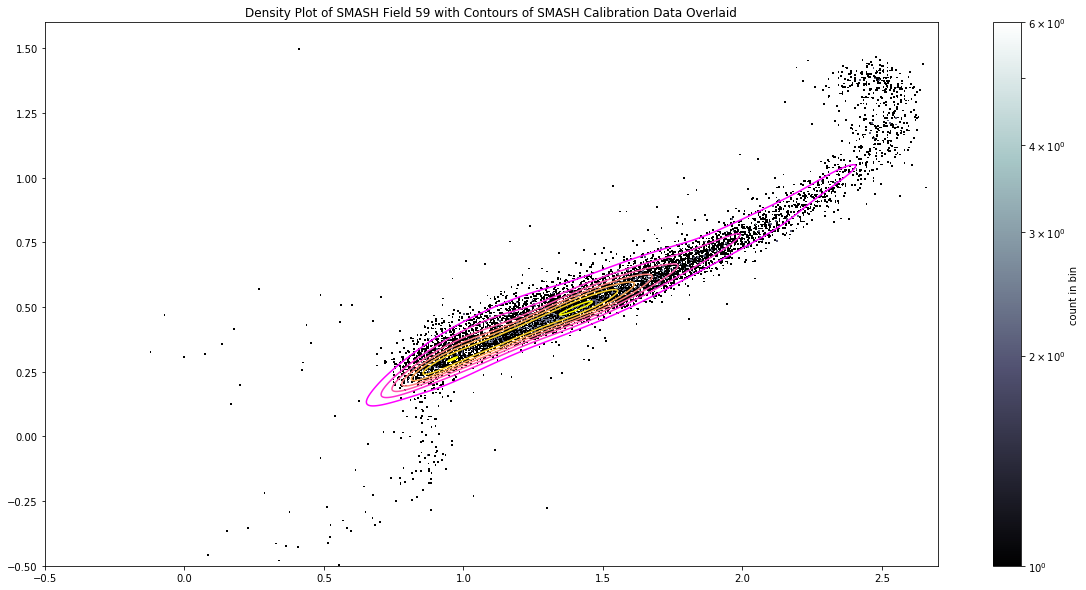

done with field [59]


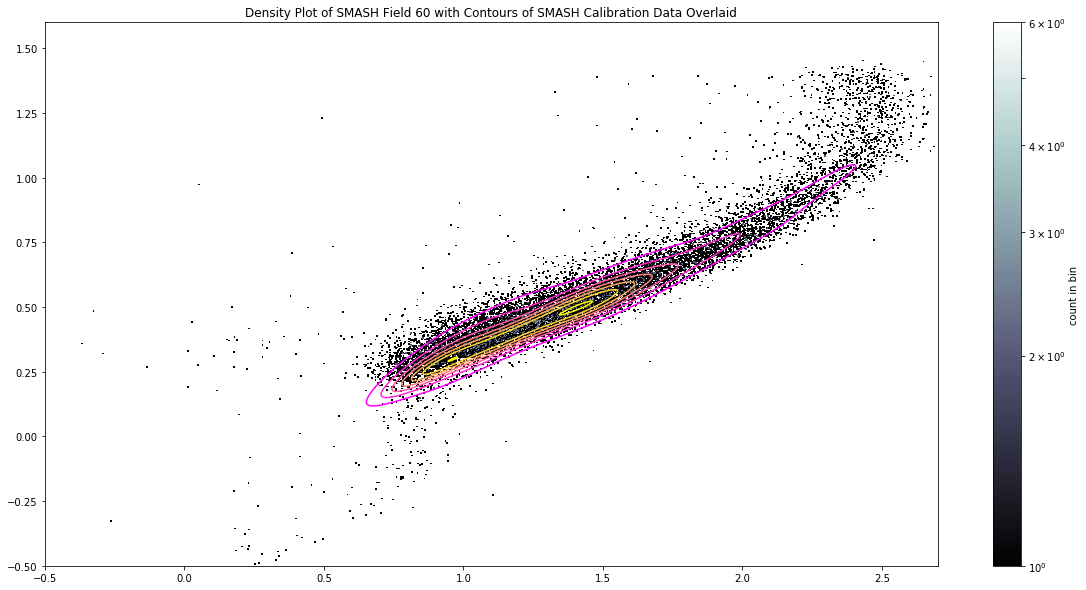

done with field [60]


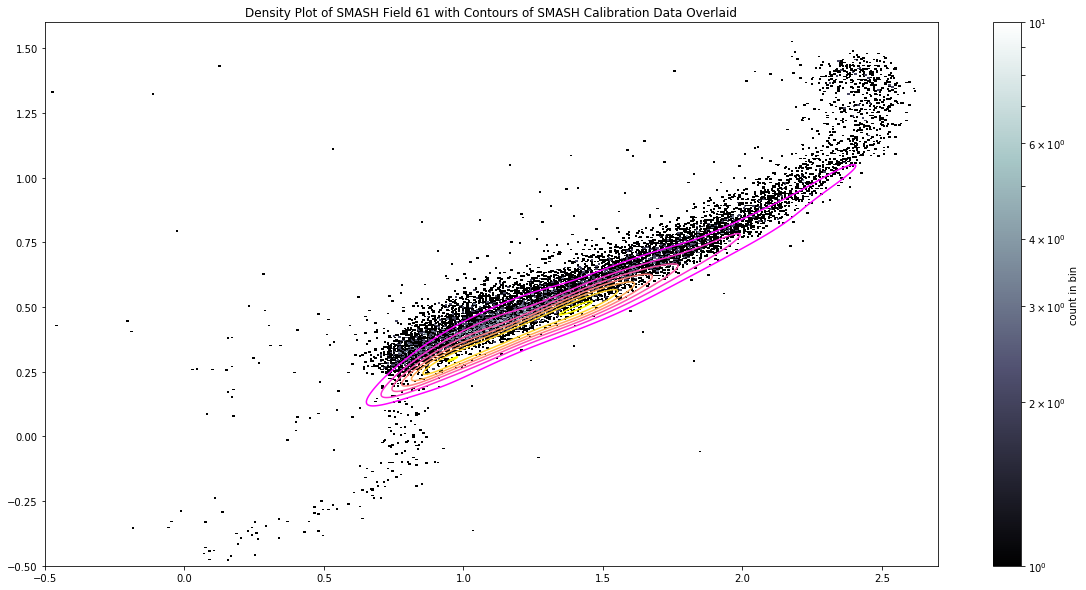

done with field [61]


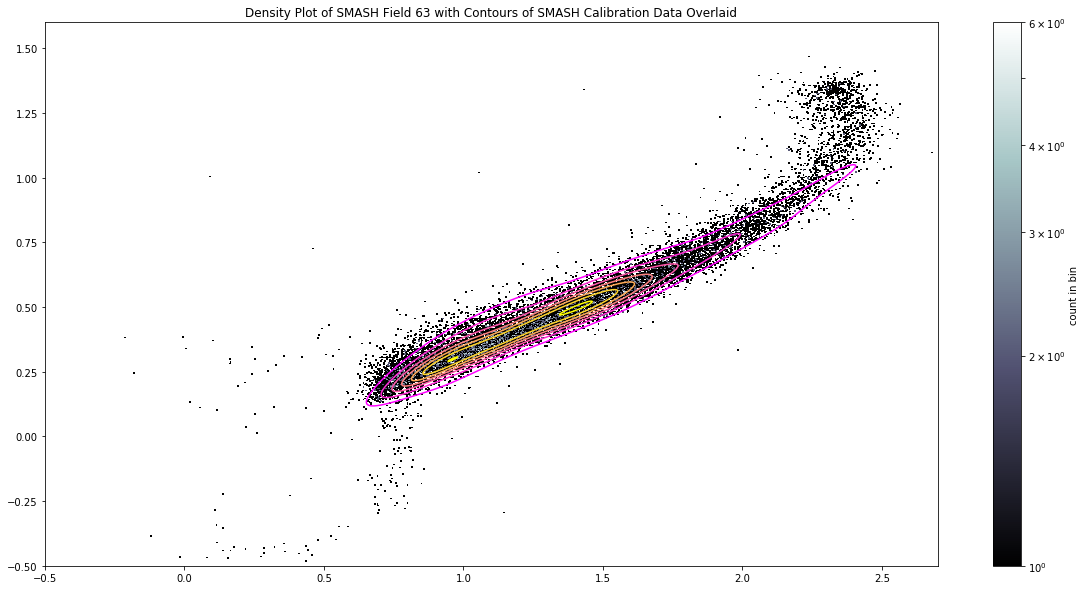

done with field [63]


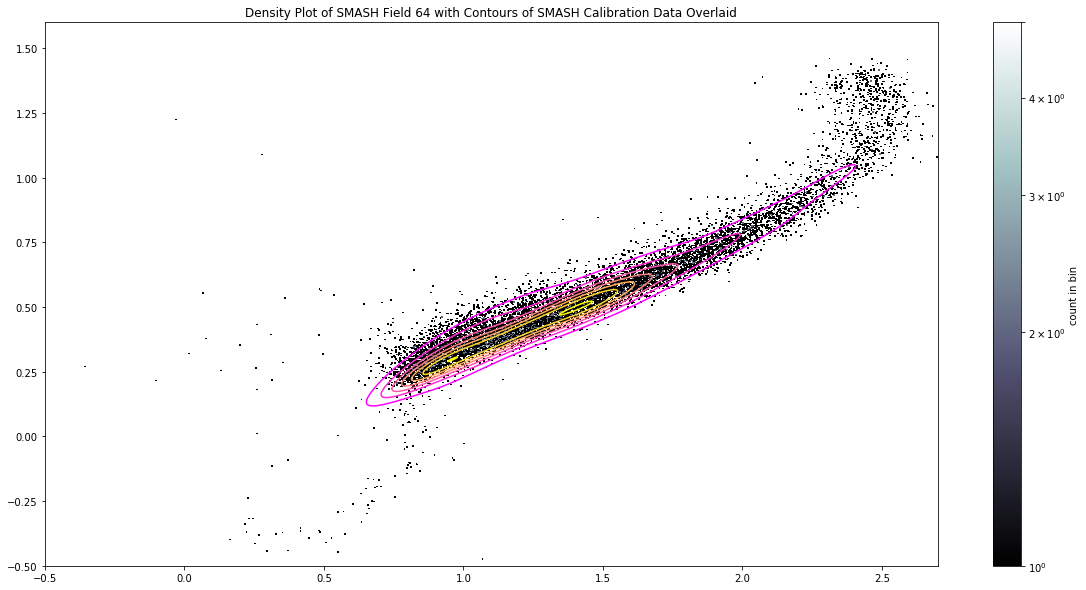

done with field [64]


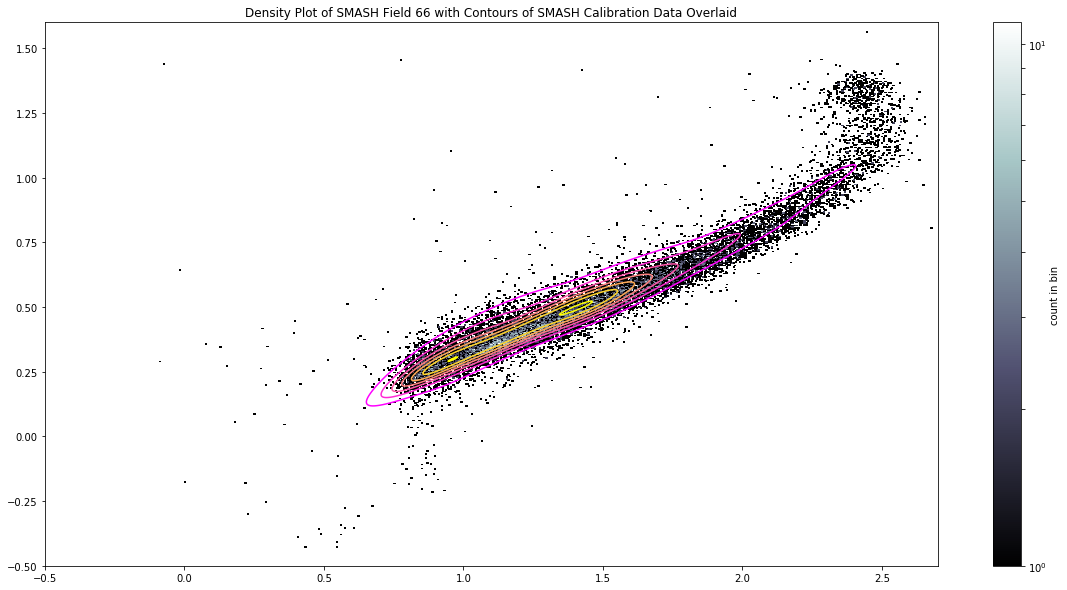

done with field [66]


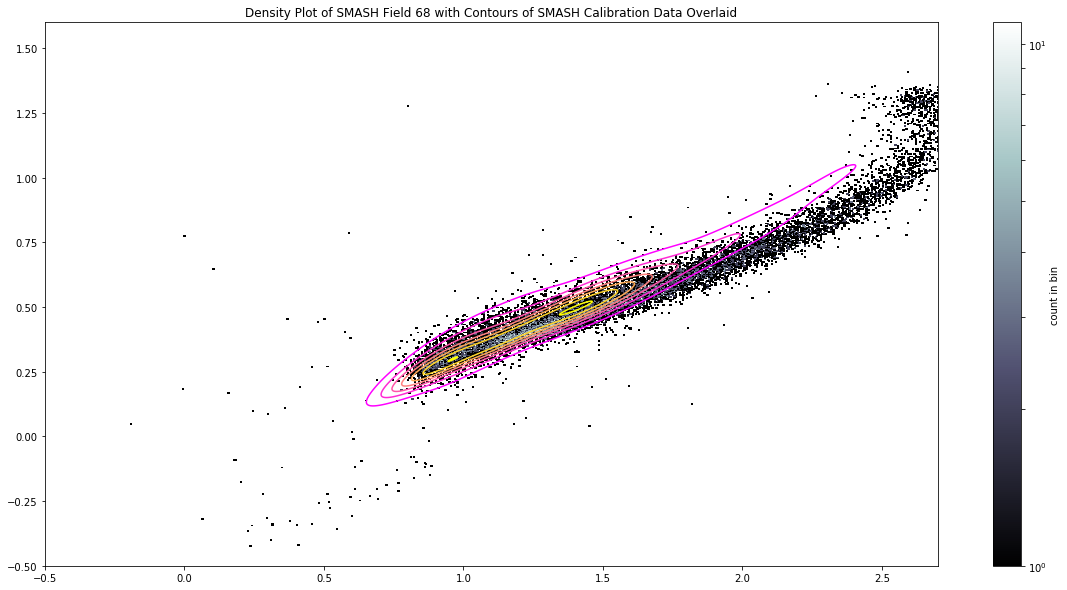

done with field [68]


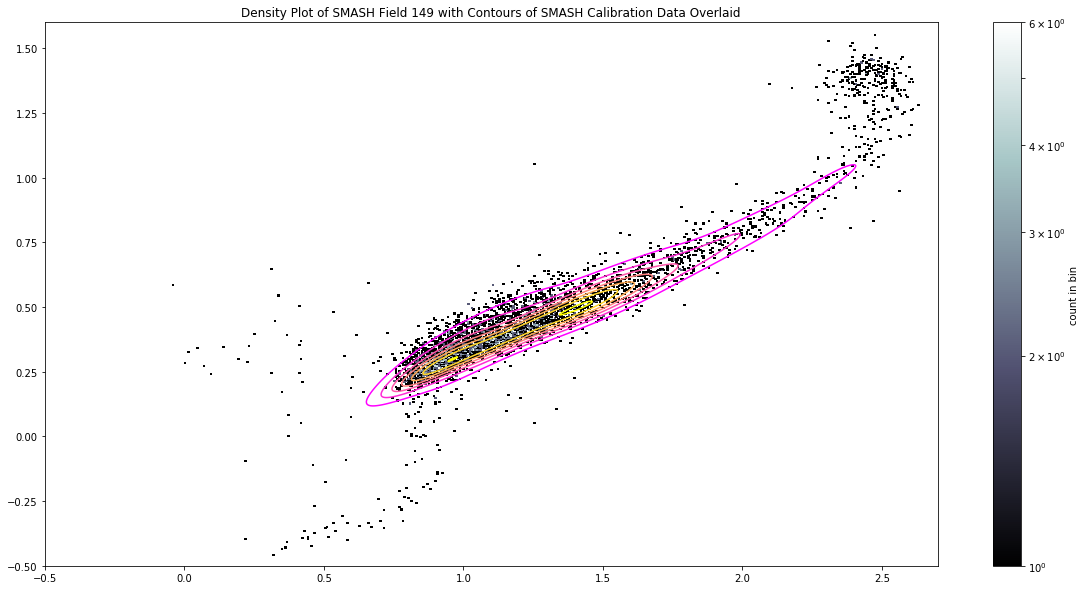

done with field [149]


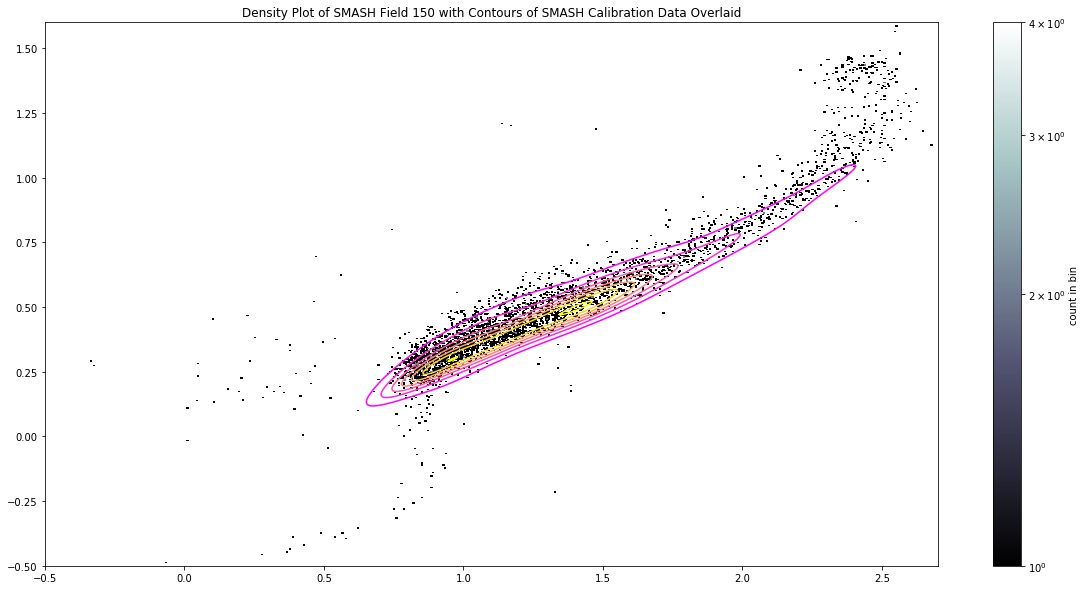

done with field [150]


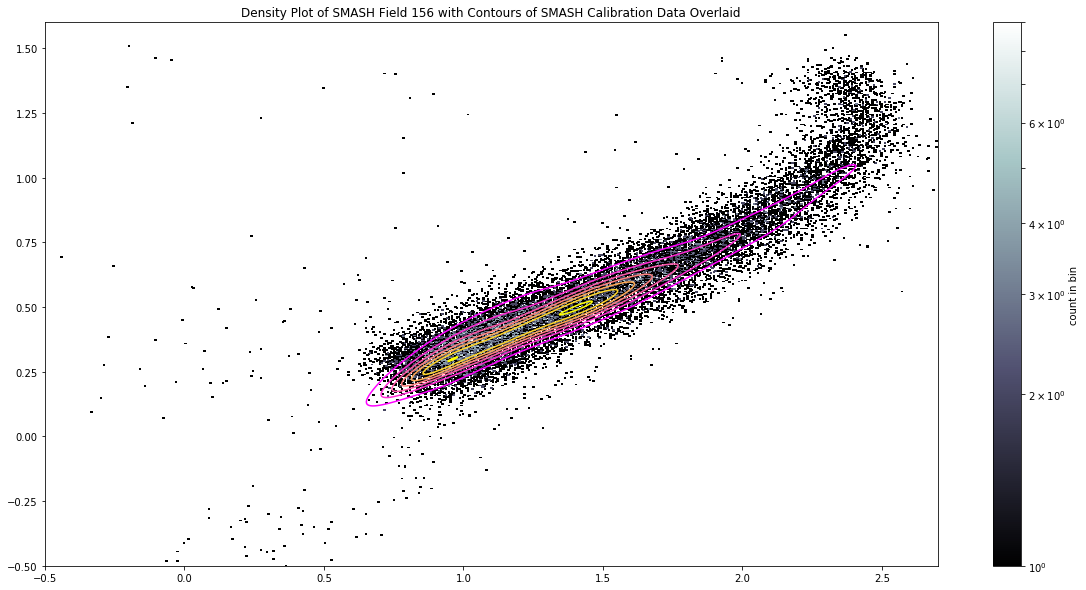

done with field [156]


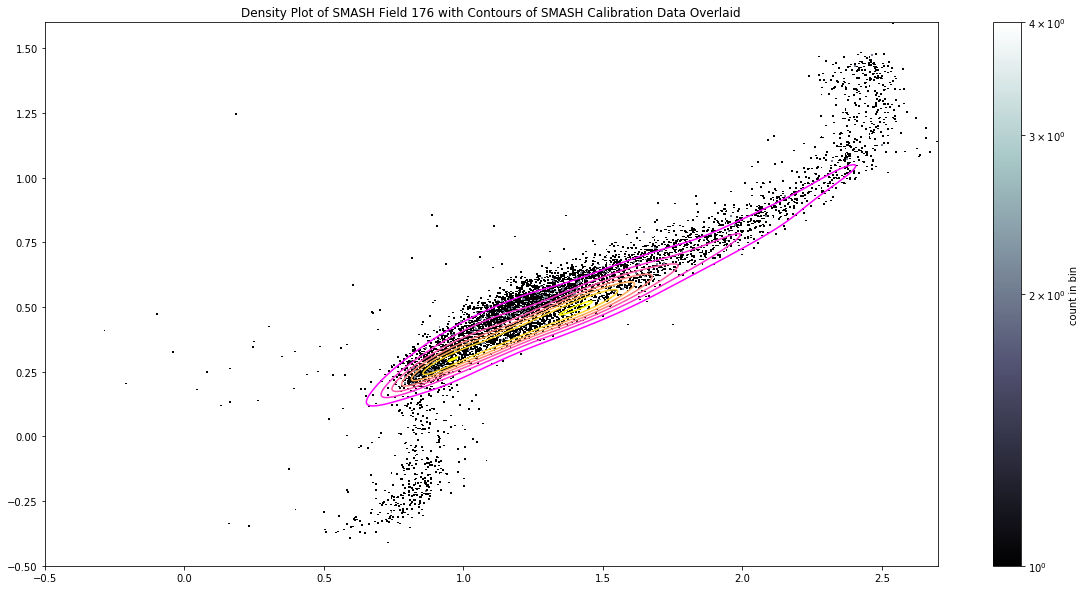

done with field [176]


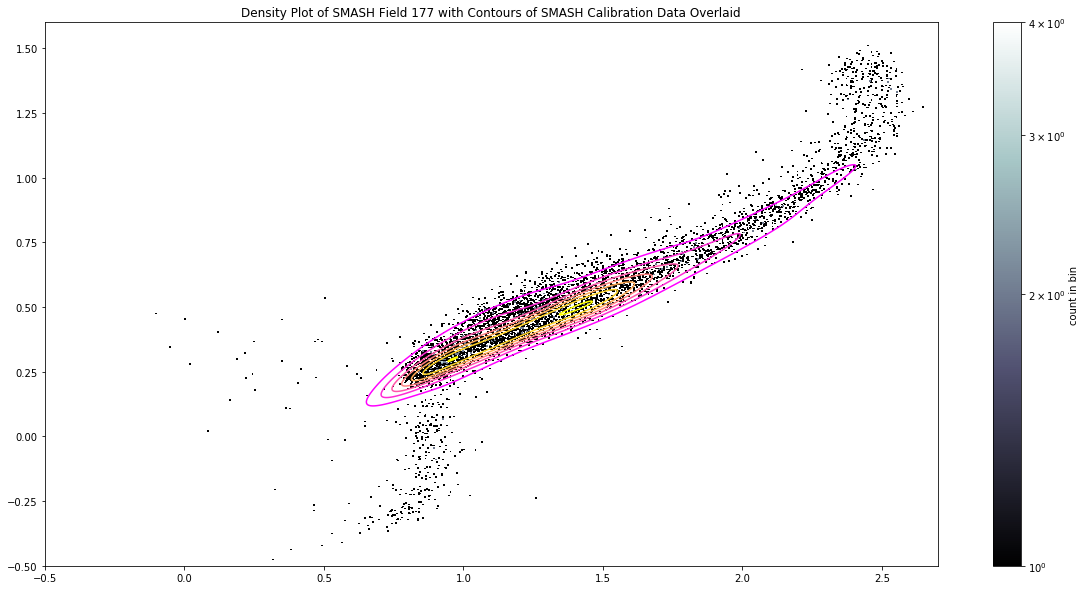

done with field [177]


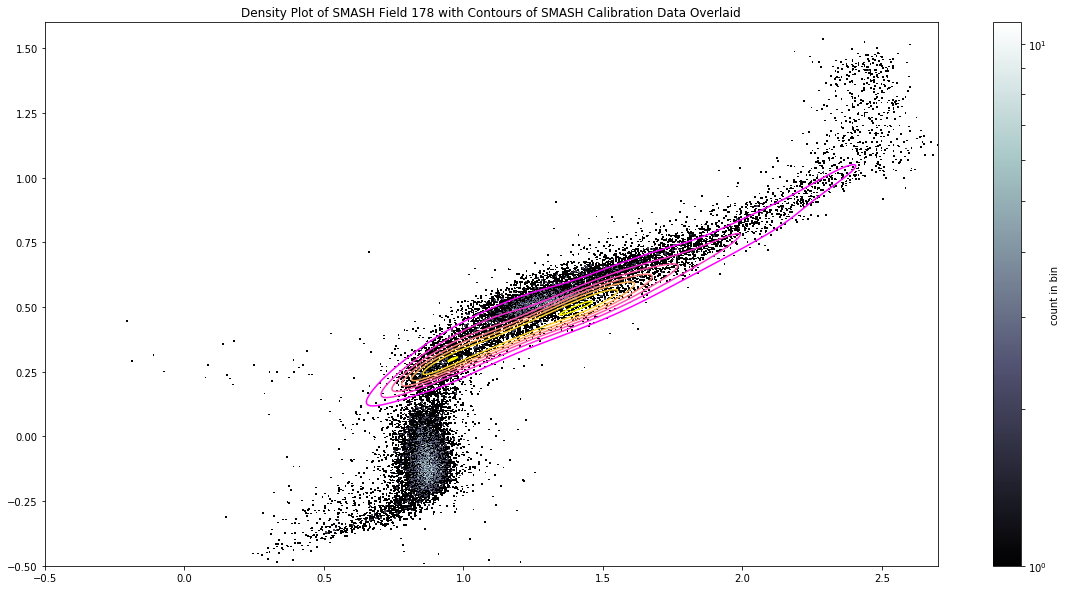

done with field [178]


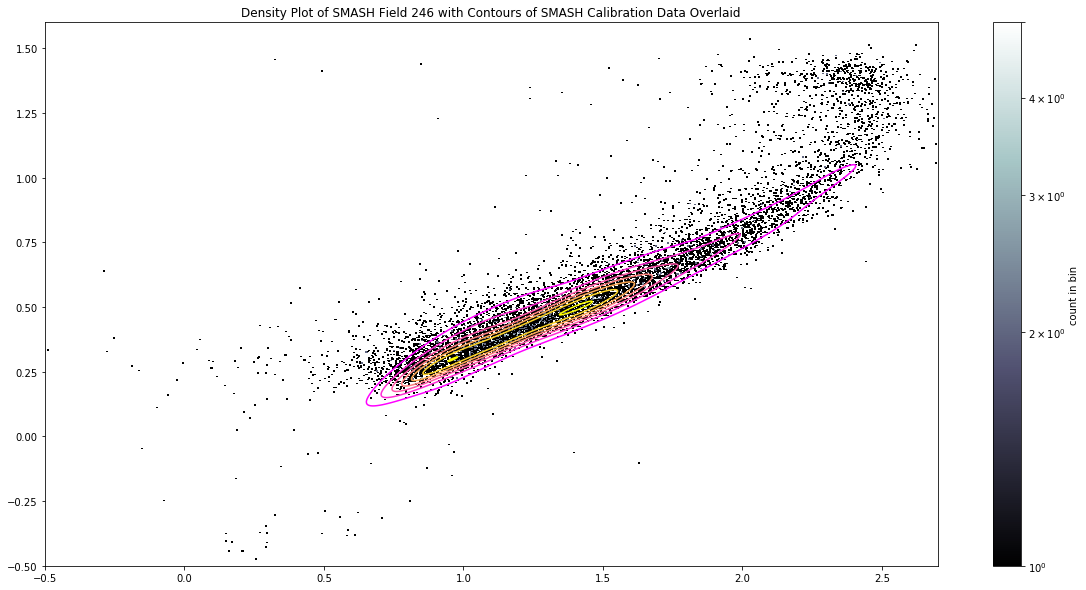

done with field [246]


In [54]:
if __name__=="__main__":
    for number in fields:
        density_plots('/Users/amyel/research/SMASH_project/datafiles/SMASH_fields/vsix/starsthree/Field{}_allobj_deep_stars.fits.gz'.format(number))

              

In [58]:
#function to calculate metallicity in SMASH fields of interest
###calculates metallicity using information from binned_statistic_2d 
###reads out metallicity using yumi's method
###output is four different metallicity values: original calibration, nearest interpolation, linear interpolation, cubic interpolation
def metallicity(filename):
    
    #read fits file
    fx = fitsio.FITS(filename)
    objs_new = fx[1].read()
    
    #extract field number from filename string
    newstr = ''.join((ch if ch in '0123456789' else ' ') for ch in filename)
    field_number = [int(i) for i in newstr.split()]
    
    #initial number of stars in each field
    print("number of initial stars in field "+str(field_number[0])+": "+str(len(objs_new)))
    #initial_stars.append(objs_new)
    
    #deredden the colors from input file
    u = (objs_new["U"]-(4.239*objs_new["EBV"]))
    g = (objs_new["G"]-(3.303*objs_new["EBV"]))
    i = (objs_new["I"]-(1.263*objs_new["EBV"]))
    r = (objs_new["R"]-(2.285*objs_new["EBV"]))

    #make cuts
    selected = np.where(((g-i)>=0.11)&((g-i)<=0.44)&(g>=21.9)&(g<=22.8)&(u<=30)&(r<=30)&(objs_new['CHI']<3)&(abs(objs_new['SHARP'])<1)&(objs_new['PROB']>.8))
    u = u[selected]
    g = g[selected]
    i = i[selected]
    r = r[selected]
    u_g = u-g
    g_r = g-r
    uerr = objs_new['UERR'][selected]
    gerr = objs_new['GERR'][selected]
    rerr = objs_new['RERR'][selected]
    
    #weights to compute weighted average
    wt_uerr = 1/(uerr**2)
    wt_gerr = 1/(gerr**2)
    wt_rerr = 1/(rerr**2)
    wts = [wt_uerr,wt_gerr,wt_rerr]
    
    #number of stars after cuts
    print("number of stars after cuts in field "+str(field_number[0])+": "+str(len(u)))
    #cut_stars.append(len(u))
    stars = len(u)
    
    #original metallicity values from binned_statistic_sd from original calibration sample 
    ind, = np.where(((u_g)>=xedge['original'].min())&((u_g)<=xedge['original'].max())&((g_r)>=yedge['original'].min())&((g_r)<=yedge['original'].max()))
    ix = np.searchsorted(xedge['original'],(u_g)[ind])
    ix = ix - 1
    iy = np.searchsorted(yedge['original'],(g_r)[ind])
    iy = iy - 1
    feh = ret['original'][ix,iy]
    N = np.count_nonzero(~np.isnan(feh))
    #mean_metallicity['original'].append(np.nanmean(feh))
    print("mean metallicity for original method:",(np.nanmean(feh)))
    #median_metallicity['original'].append(np.nanmedian(feh))
    print("median metallicity for original method:",(np.nanmedian(feh)))
    #std['original'].append(np.nanstd(feh))
    #error['original'].append((np.nanstd(feh))/np.sqrt(N))

    #weighted averages computed using error in the u, g, and r bands
    for i, method in enumerate(('uerr','gerr','rerr')):
        wt = 1/(wts[i]**2)
        wt = wt[ind]
        selected = np.where((np.isnan(feh)!=True))
        feh = feh[selected]
        N = np.count_nonzero(~np.isnan(feh))
        wt = wt[selected]
        #mean_metallicity[method].append((np.sum(wt*feh))/(np.sum(wt)))
        #std[method].append(np.nanstd(feh))
        #error[method].append((np.nanstd(feh))/np.sqrt(N))
        print("weighted mean using "+str(method)+': ',((np.sum(wt*feh))/(np.sum(wt))))    
    
    #read out metallicity values from binned_statistic_2d from original calibration sample, and then the different interpolation methods
    for i, method in enumerate(('nearest','linear','cubic')):
        ind, = np.where(((u_g)>=xedge[method].min())&((u_g)<=xedge[method].max())&((g_r)>=yedge[method].min())&((g_r)<=yedge[method].max()))
        ix = np.searchsorted(xedge[method],(u_g)[ind])
        ix = ix - 1
        iy = np.searchsorted(yedge[method],(g_r)[ind])
        iy = iy - 1
        feh = ret[method][ix,iy]
        N = np.count_nonzero(~np.isnan(feh))
        #mean_metallicity[method].append(np.nanmean(feh))
        #median_metallicity[method].append(np.nanmedian(feh))
        print("mean metallicity for "+method+" method:",(np.nanmean(feh)))
        #std[method].append(np.nanstd(feh))
        #error[method].append((np.nanstd(feh))/np.sqrt(N))
        
    #compute mean/median colors inside field, and then metallicity
    for i, method in enumerate(('original','nearest','linear','cubic')):
        ind, = np.where(((u_g)>=xedge[method].min())&((u_g)<=xedge[method].max())&((g_r)>=yedge[method].min())&((g_r)<=yedge[method].max()))
        mean_u_g = np.nanmean(u_g[ind])
        mean_g_r = np.nanmean(g_r[ind])
        ix = np.searchsorted(xedge[method],mean_u_g)
        ix = ix - 1
        iy = np.searchsorted(yedge[method],mean_g_r)
        iy = iy - 1
        feh = ret[method][ix,iy]
        #color_mean[method].append(np.nanmean(feh))
        print("color mean Fe/H for "+method+" method:",(np.nanmean(feh)))
    
    for i, method in enumerate(('original','nearest','linear','cubic')):
        ind, = np.where(((u_g)>=xedge[method].min())&((u_g)<=xedge[method].max())&((g_r)>=yedge[method].min())&((g_r)<=yedge[method].max()))
        median_u_g = np.nanmedian(u_g[ind])
        median_g_r = np.nanmedian(g_r[ind])
        ix = np.searchsorted(xedge[method],median_u_g)
        ix = ix - 1
        iy = np.searchsorted(yedge[method],median_g_r)
        iy = iy - 1
        feh = ret[method][ix,iy]
        #color_median[method].append(np.nanmedian(feh))
        print("color median Fe/H for "+method+" method:",(np.nanmedian(feh)))
        
    #use machine learning algorithm Nearest Neighbors
    ###The target is predicted by local interpolation of the targets associated of the nearest neighbors in the training set.
    sample = np.reshape(np.ravel([u_g,g_r],order='F'),(len(u_g),2))   
    knn = neighbors.KNeighborsRegressor(5,weights='uniform')
    feh = knn.fit(points,feh_cal).predict(sample)
    #mean_metallicity['nearest_regressor'].append(np.nanmean(feh))
    #median_metallicity['nearest_regressor'].append(np.nanmedian(feh))
    print("mean metallicity for nearest neighbor regression method:",(np.nanmean(feh)))
    #std['nearest_regressor'].append(np.nanstd(feh))
    #error['nearest_regressor'].append((np.nanstd(feh))/np.sqrt(stars))
    
    #use equation (4) from Ivezic et al. 2008 to estimate metallicity
    ### x=(u-g) for (g-r)<=0.4; x=(u-g)-2(g-r)+0.8 for (g-r)>0.4
    ### y=(g-r)
    feh = []
    x = u_g -(2*g_r) + 0.8
    index = np.arange(0,len(u_g))
    
    for i in index:
        feh.append([ivezic_equation(u_g[i],g_r[i]) if g_r[i] <= 0.4 else ivezic_equation(x[i],g_r[i])])
    #feh.append(ivezic_equation(u_g[i],g_r[i]))
    
    N = np.count_nonzero(~np.isnan(feh))
    #mean_metallicity['ivezic'].append(np.nanmean(feh))
    #median_metallicity['ivezic'].append(np.nanmedian(feh))
    #std['ivezic'].append(np.nanstd(feh))
    #error['ivezic'].append((np.nanstd(feh))/np.sqrt(N))
    print('mean metallicity for ivezic equation method: ',(np.nanmean(feh)))
    
    return 0


In [59]:
if __name__=="__main__":
    metallicity('/Users/amyel/research/SMASH_project/datafiles/NGC1841_stars.fits')

              

number of initial stars in field 1841: 3405
number of stars after cuts in field 1841: 135
mean metallicity for original method: -1.2822251374522844
median metallicity for original method: -1.3947120308876038
weighted mean using uerr:  -1.0155032897272191
weighted mean using gerr:  -1.32119414431852
weighted mean using rerr:  -1.4200044684187163
mean metallicity for nearest method: -1.264573574066162
mean metallicity for linear method: -1.4439609687474102
mean metallicity for cubic method: -2.2543155003454616
color mean Fe/H for original method: nan
color mean Fe/H for nearest method: nan
color mean Fe/H for linear method: -2.0691107833477527
color mean Fe/H for cubic method: -2.232255044483944
color median Fe/H for original method: nan
color median Fe/H for nearest method: nan
color median Fe/H for linear method: -1.9964266451947972
color median Fe/H for cubic method: -8.970822892945096
mean metallicity for nearest neighbor regression method: -1.7620971
mean metallicity for ivezic equa

/Users/amyel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: Mean of empty slice
/Users/amyel/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


### literature value for NGC 1841: -2.02